In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import pickle as pkl
from tensorflow import keras
import tensorflow.keras.backend as K
from keras.models import Sequential,Model
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten, Input, Reshape, BatchNormalization, Bidirectional, LSTM, Multiply, Activation, Normalization, TimeDistributed
from keras.layers import Conv3D, Conv2D, Conv1D, MaxPool3D, MaxPool2D, MaxPool1D, AvgPool3D, AvgPool2D, AvgPool1D, GlobalMaxPool3D, Attention, Subtract
from keras.layers import GlobalMaxPool2D, GlobalMaxPool1D, SpatialDropout3D, SpatialDropout2D, SpatialDropout1D, GlobalAvgPool3D, MultiHeadAttention
from keras.layers import GlobalAvgPool2D, GlobalAvgPool1D, SeparableConv2D, SeparableConv1D, Add, Concatenate, LeakyReLU, ELU, Activation, PReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.utils import np_utils
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
import gc

# **Data Loading**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
gc.collect()

Mounted at /content/drive/


55

In [ ]:
input_path='/content/drive/MyDrive/data_preprocessed_python/'

In [ ]:
def baseline_remove(XR):
  XT = XR[:, 384:]
  XB_ = (XR[:, :1*128] + XR[:, 1*128:2*128] + XR[:, 2*128:3*128])/3.0
  for i in range(60):
    XT[:, i*128:(i+1)*128] = XT[:, i*128:(i+1)*128] - XB_
  return XT


In [ ]:
skip = 128

In [ ]:
def simple_2D_CNN(x): 
  '''y = AvgPool2D(pool_size=(1,256))(x)
  y = Flatten()(y)
  y = Dense(4,activation='tanh') (y)
  y = Dense(36,activation='softmax') (y)
  x = Multiply()([x, tf.expand_dims(tf.expand_dims(y, axis=2), axis=2)])'''
  x1 = Conv2D(filters = 16, kernel_size = (1,16), strides = (1,1), padding = 'same', activation='selu')(x) #above 8 Hz
  x2 = Conv2D(filters = 16, kernel_size = (1,10), strides = (1,1), padding = 'same', activation='selu')(x) #above 12.8 Hz
  x3 = Conv2D(filters = 16, kernel_size = (1,6), strides = (1,1), padding = 'same', activation='selu')(x) #above 21.3 Hz
  x1 = Subtract()([x1, x2]) #above 8 Hz and below 12.8 Hz
  x1 = MaxPool2D(pool_size=(1,2))(x1) #downsampling by 2
  x1 = Conv2D(filters = 16, kernel_size = (1,16), strides = (1,1), padding = 'same', activation='selu')(x1)
  x1 = MaxPool2D(pool_size=(1,2))(x1)
  x1 = Conv2D(filters = 16, kernel_size = (1,16), strides = (1,1), padding = 'same', activation='selu')(x1)
  x1 = MaxPool2D(pool_size=(1,2))(x1)
  x2 = Subtract()([x2, x3]) #above 12.8 Hz and below 21.3 Hz
  x2 = MaxPool2D(pool_size=(1,2))(x2)
  x2 = Conv2D(filters = 16, kernel_size = (1,10), strides = (1,1), padding = 'same', activation='selu')(x2)
  x2 = MaxPool2D(pool_size=(1,2))(x2)
  x2 = Conv2D(filters = 16, kernel_size = (1,10), strides = (1,1), padding = 'same', activation='selu')(x2)
  x2 = MaxPool2D(pool_size=(1,2))(x2)
  x = Concatenate(axis=3)([x1, x2])
  x = Dropout(0.1)(x)
  x1 = Conv2D(filters = 32, kernel_size = (2,4), strides = (2,1), padding = 'same', activation='selu')(x)
  x1 = Conv2D(filters = 32, kernel_size = (3,4), strides = (3,1), padding = 'same', activation='selu')(x1)
  x1 = Conv2D(filters = 32, kernel_size = (3,4), strides = (3,1), padding = 'same', activation='selu')(x1)
  x1 = MaxPool2D(pool_size=(1,2))(x1)
  x2 = Conv2D(filters = 32, kernel_size = (3,4), strides = (3,1), padding = 'same', activation='selu')(x)
  x2 = Conv2D(filters = 32, kernel_size = (2,4), strides = (2,1), padding = 'same', activation='selu')(x2)
  x2 = Conv2D(filters = 32, kernel_size = (3,4), strides = (3,1), padding = 'same', activation='selu')(x2)
  x2 = MaxPool2D(pool_size=(1,2))(x2)
  x3 = Conv2D(filters = 32, kernel_size = (6,4), strides = (6,1), padding = 'same', activation='selu')(x)
  x3 = Conv2D(filters = 32, kernel_size = (3,4), strides = (3,1), padding = 'same', activation='selu')(x3)
  x3 = MaxPool2D(pool_size=(1,2))(x3)
  x4 = Conv2D(filters = 32, kernel_size = (9,4), strides = (9,1), padding = 'same', activation='selu')(x)
  x4 = Conv2D(filters = 32, kernel_size = (2,4), strides = (2,1), padding = 'same', activation='selu')(x4)
  x4 = MaxPool2D(pool_size=(1,2))(x4)
  x5 = Conv2D(filters = 32, kernel_size = (18,4), strides = (18,1), padding = 'same', activation='selu')(x)
  x5 = MaxPool2D(pool_size=(1,2))(x5)
  x = Concatenate(axis=3)([x1, x2, x3, x4, x5])
  x = Dropout(0.1)(x)
  x = Conv2D(filters = x.shape[3], kernel_size = (2,2), strides = (2,1), padding = 'same', activation='selu')(x)
  x = GlobalAvgPool2D()(x)
  x = Dense(128, activation='tanh')(x)
  x = Dropout(0.1)(x)
  x = Dense(32, activation='relu')(x)
  x = Dropout(0.1)(x)
  x = Dense(2, activation='softmax')(x)
  return x

def get_model(): 
  input_shape = (36, 256, 1) 
  a = Input(input_shape) 
  out = simple_2D_CNN(a) 
  model = Model(a, out) 
  opt = keras.optimizers.Adam(learning_rate=1e-04) 
  model.compile(loss=keras.losses.categorical_crossentropy, metrics=["accuracy"], optimizer=opt) 
  return model 
model = get_model() 
model.summary() 

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 36, 256, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 36, 256, 16)  272         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 36, 256, 16)  176         ['input_1[0][0]']                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 36, 256, 16)  112         ['input_1[0][0]']            

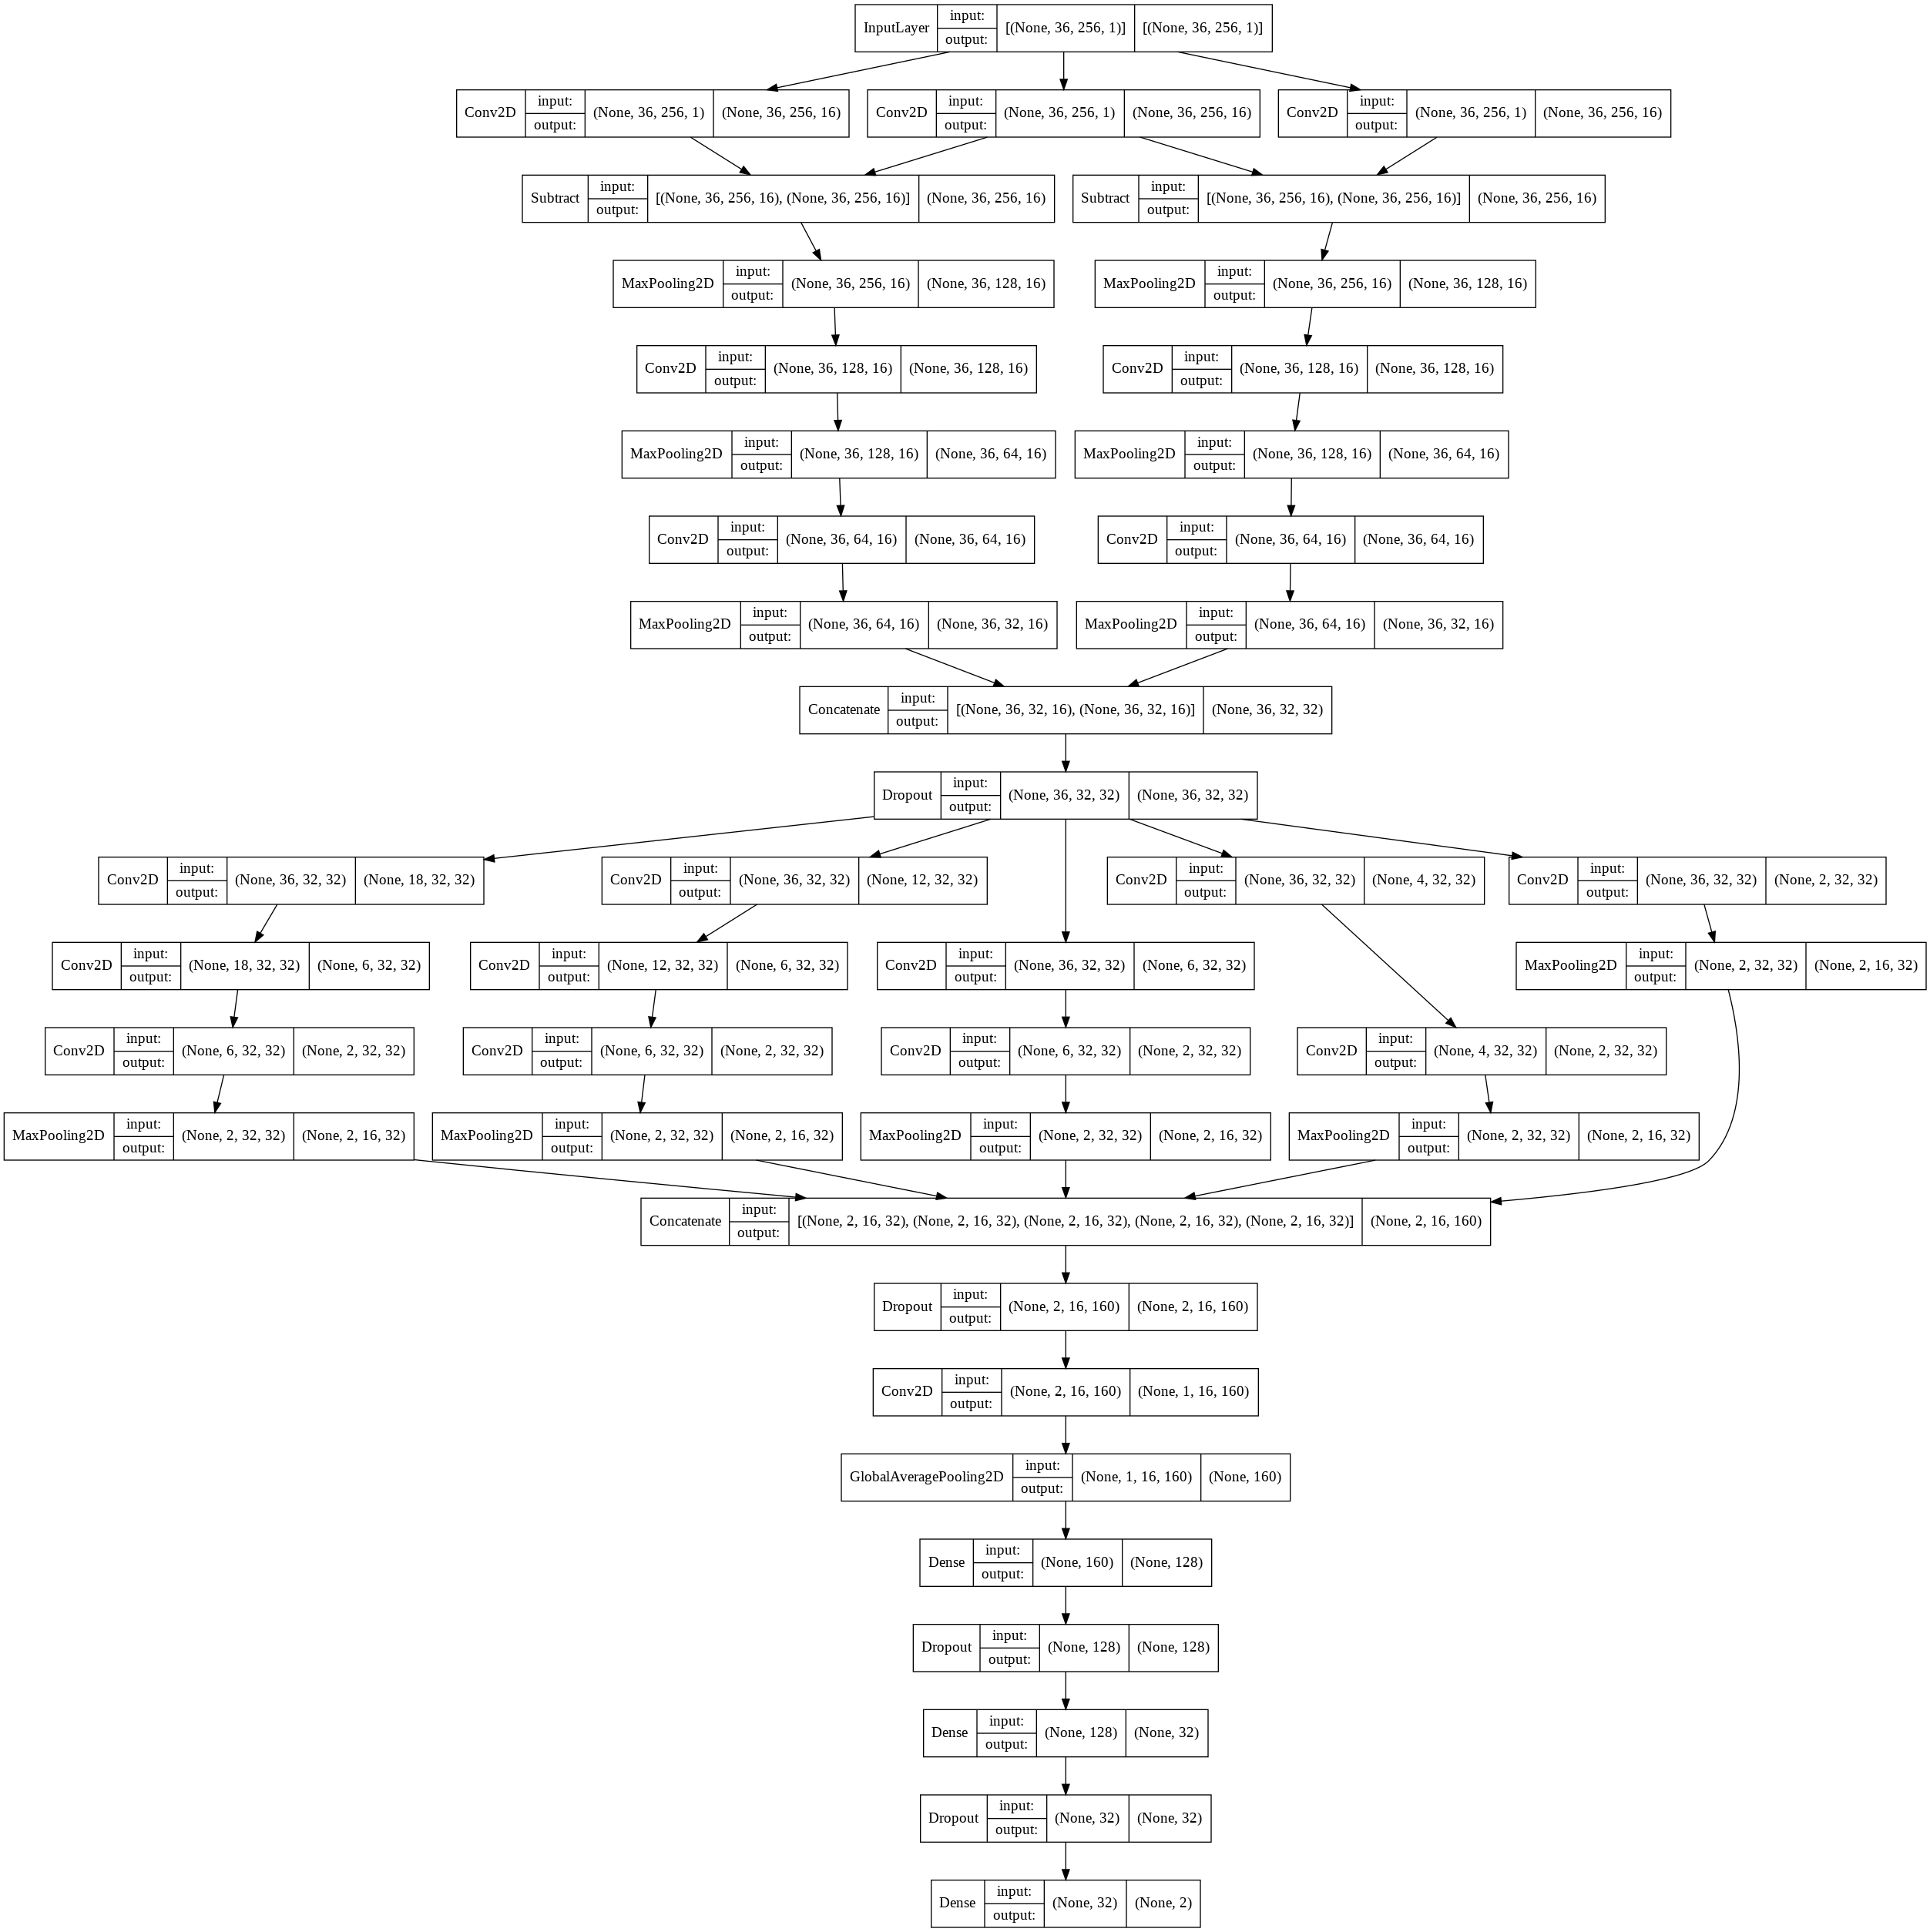

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

In [ ]:
new_channels = [0,1,18,2,3,5,4,23,6,7,9,8,15,10,11,12,14,13,
 16,17,18,19,20,22,21,23,24,25,27,26,15,28,29,30,14,31]

In [ ]:
batch_size = 64
epochs = 100
kfold = KFold(n_splits=10, random_state=1, shuffle=True)
gc.collect()

13569

In [ ]:
def call_class_weights(yt):
  y_integers = np.argmax(yt, axis=1)
  class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(y_integers), y = y_integers)
  d_class_weights = dict(enumerate(class_weights))
  return d_class_weights

# **Subject 13**

In [ ]:
eeg_signal = []
valence = []
arousal = []
window_size = 256
no_channels = 32
no_new_channels = len(new_channels)
no_videos = 40
Trsld = 5

for person in range(13,14):
  print('Person No.' + str(person))
  
  
  # EEG files address
  if person < 10 :
    address = input_path+'s0'+str(person)+'.dat'
  else :
    address = input_path+'s'+str(person)+'.dat'

  with open(address, 'rb') as file:
    data = pkl.load(file, encoding = 'latin1')

  eeg = data['data']
  label = data['labels']
  
  # Assigning classes
  label[label<Trsld] = 0
  label[label>=Trsld] = 1

  val = label.T[0] # Valence label
  aro = label.T[1] # Arousal label

  del data, label
  # Iterating through 40 vidoes/trials
  for i in range(no_videos):
    sig = eeg[i][:no_channels, :]
    sig = baseline_remove(sig)
    temp = []
    for j in new_channels:
      temp.append(sig[j, :])
    sig = np.reshape(temp,[no_new_channels,-1])
    # Segmenting into 2 seconds (256 timesteps) windows without overlap
    start = 0
    while start + window_size <=sig.shape[1]:
      eeg_signal.append(sig[:, start:start+window_size])
      valence.append(val[i])
      arousal.append(aro[i])
      start += skip
  del eeg, val, aro, sig
eeg_signal = np.reshape(eeg_signal,[-1,no_new_channels,window_size,1])
data = np.asarray(eeg_signal, dtype = np.float32) # Using 32 bit floating point value to save memory
del eeg_signal
valence = np.asarray(valence, dtype = np.int8)
arousal = np.asarray(arousal, dtype = np.int8)

print(data.shape)
print(valence.shape, valence[valence == 0].shape, valence[valence == 1].shape)
print(arousal.shape, arousal[arousal == 0].shape, arousal[arousal == 1].shape)

valence = np_utils.to_categorical(valence)
arousal = np_utils.to_categorical(arousal)
gc.collect()

Person No.13
(2360, 36, 256, 1)
(2360,) (1298,) (1062,)
(2360,) (354,) (2006,)


0

# **Valence**

In [ ]:
#valence
X_train, x_test, Y_train, y_test = train_test_split(data, valence, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(2124, 36, 256, 1) (236, 36, 256, 1) (2124, 2) (236, 2)


Results for fold 1
Epoch 1/100
30/30 [==============================] - 4s 69ms/step - loss: 0.7075 - accuracy: 0.5772 - val_loss: 0.6221 - val_accuracy: 0.6995
Epoch 2/100
30/30 [==============================] - 2s 58ms/step - loss: 0.6499 - accuracy: 0.6238 - val_loss: 0.6331 - val_accuracy: 0.5915
Epoch 3/100
30/30 [==============================] - 2s 58ms/step - loss: 0.6379 - accuracy: 0.6264 - val_loss: 0.6202 - val_accuracy: 0.6244
Epoch 4/100
30/30 [==============================] - 2s 58ms/step - loss: 0.5817 - accuracy: 0.6939 - val_loss: 0.5599 - val_accuracy: 0.7183
Epoch 5/100
30/30 [==============================] - 2s 58ms/step - loss: 0.5568 - accuracy: 0.7153 - val_loss: 0.5465 - val_accuracy: 0.7136
Epoch 6/100
30/30 [==============================] - 2s 58ms/step - loss: 0.5444 - accuracy: 0.7232 - val_loss: 0.5080 - val_accuracy: 0.7371
Epoch 7/100
30/30 [==============================] - 2s 58ms/step - loss: 0.5187 - accuracy: 0.7425 - val_loss: 0.4929 - val_accu

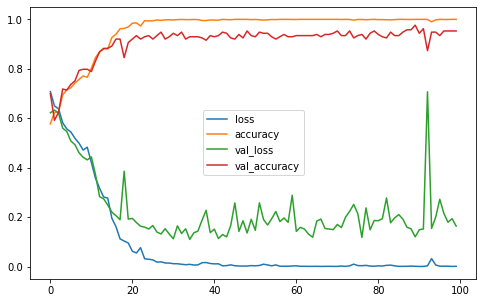

Results for fold 2
Epoch 1/100
30/30 [==============================] - 3s 69ms/step - loss: 0.6818 - accuracy: 0.5845 - val_loss: 0.6030 - val_accuracy: 0.7042
Epoch 2/100
30/30 [==============================] - 2s 58ms/step - loss: 0.6127 - accuracy: 0.6661 - val_loss: 0.5524 - val_accuracy: 0.7371
Epoch 3/100
30/30 [==============================] - 2s 58ms/step - loss: 0.5717 - accuracy: 0.6918 - val_loss: 0.5159 - val_accuracy: 0.7418
Epoch 4/100
30/30 [==============================] - 2s 58ms/step - loss: 0.5363 - accuracy: 0.7195 - val_loss: 0.4862 - val_accuracy: 0.7700
Epoch 5/100
30/30 [==============================] - 2s 58ms/step - loss: 0.5131 - accuracy: 0.7405 - val_loss: 0.4535 - val_accuracy: 0.7793
Epoch 6/100
30/30 [==============================] - 2s 59ms/step - loss: 0.4691 - accuracy: 0.7797 - val_loss: 0.4408 - val_accuracy: 0.8169
Epoch 7/100
30/30 [==============================] - 2s 58ms/step - loss: 0.4420 - accuracy: 0.7959 - val_loss: 0.4097 - val_accu

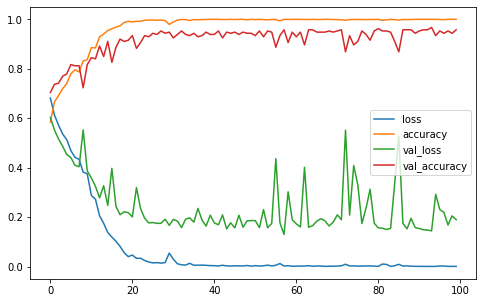

Results for fold 3
Epoch 1/100
30/30 [==============================] - 3s 70ms/step - loss: 0.7729 - accuracy: 0.5029 - val_loss: 0.6491 - val_accuracy: 0.6573
Epoch 2/100
30/30 [==============================] - 2s 59ms/step - loss: 0.6898 - accuracy: 0.5683 - val_loss: 0.6537 - val_accuracy: 0.5822
Epoch 3/100
30/30 [==============================] - 2s 59ms/step - loss: 0.6720 - accuracy: 0.5772 - val_loss: 0.6166 - val_accuracy: 0.7700
Epoch 4/100
30/30 [==============================] - 2s 59ms/step - loss: 0.6209 - accuracy: 0.6614 - val_loss: 0.5366 - val_accuracy: 0.8075
Epoch 5/100
30/30 [==============================] - 2s 59ms/step - loss: 0.6034 - accuracy: 0.6839 - val_loss: 0.5095 - val_accuracy: 0.7934
Epoch 6/100
30/30 [==============================] - 2s 59ms/step - loss: 0.5829 - accuracy: 0.6866 - val_loss: 0.4885 - val_accuracy: 0.7700
Epoch 7/100
30/30 [==============================] - 2s 59ms/step - loss: 0.5411 - accuracy: 0.7347 - val_loss: 0.4667 - val_accu

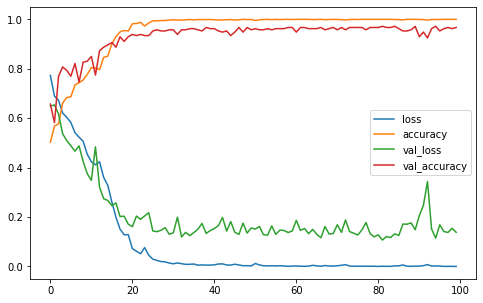

Results for fold 4
Epoch 1/100
30/30 [==============================] - 3s 70ms/step - loss: 0.6912 - accuracy: 0.5500 - val_loss: 0.6405 - val_accuracy: 0.5869
Epoch 2/100
30/30 [==============================] - 2s 59ms/step - loss: 0.6451 - accuracy: 0.6201 - val_loss: 0.5985 - val_accuracy: 0.6901
Epoch 3/100
30/30 [==============================] - 2s 59ms/step - loss: 0.6015 - accuracy: 0.6761 - val_loss: 0.5851 - val_accuracy: 0.6808
Epoch 4/100
30/30 [==============================] - 2s 59ms/step - loss: 0.5704 - accuracy: 0.7075 - val_loss: 0.5862 - val_accuracy: 0.6808
Epoch 5/100
30/30 [==============================] - 2s 59ms/step - loss: 0.5582 - accuracy: 0.7206 - val_loss: 0.5434 - val_accuracy: 0.6995
Epoch 6/100
30/30 [==============================] - 2s 60ms/step - loss: 0.4946 - accuracy: 0.7593 - val_loss: 0.6690 - val_accuracy: 0.6197
Epoch 7/100
30/30 [==============================] - 2s 60ms/step - loss: 0.4760 - accuracy: 0.7718 - val_loss: 0.5047 - val_accu

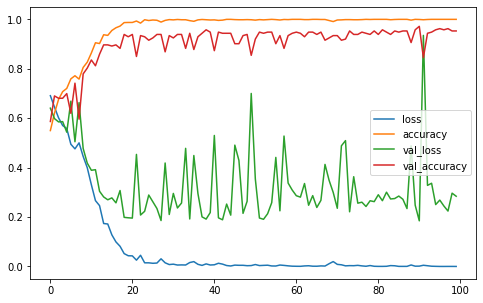

Results for fold 5
Epoch 1/100
30/30 [==============================] - 3s 71ms/step - loss: 0.7153 - accuracy: 0.5549 - val_loss: 0.6493 - val_accuracy: 0.6368
Epoch 2/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6401 - accuracy: 0.6313 - val_loss: 0.5893 - val_accuracy: 0.7123
Epoch 3/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6190 - accuracy: 0.6344 - val_loss: 0.5654 - val_accuracy: 0.7264
Epoch 4/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5890 - accuracy: 0.6883 - val_loss: 0.5426 - val_accuracy: 0.6934
Epoch 5/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5408 - accuracy: 0.7369 - val_loss: 0.4915 - val_accuracy: 0.7500
Epoch 6/100
30/30 [==============================] - 2s 59ms/step - loss: 0.5166 - accuracy: 0.7369 - val_loss: 0.4734 - val_accuracy: 0.7736
Epoch 7/100
30/30 [==============================] - 2s 60ms/step - loss: 0.4604 - accuracy: 0.7871 - val_loss: 0.5064 - val_accu

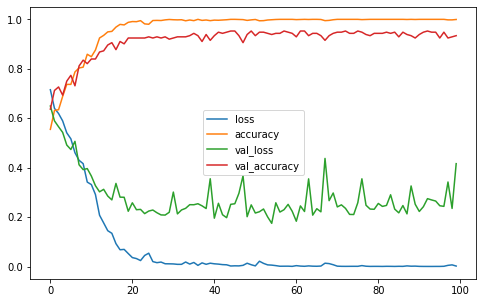

Results for fold 6
Epoch 1/100
30/30 [==============================] - 3s 71ms/step - loss: 0.6915 - accuracy: 0.5879 - val_loss: 0.6296 - val_accuracy: 0.6557
Epoch 2/100
30/30 [==============================] - 2s 59ms/step - loss: 0.6303 - accuracy: 0.6370 - val_loss: 0.5948 - val_accuracy: 0.6981
Epoch 3/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5940 - accuracy: 0.6757 - val_loss: 0.5840 - val_accuracy: 0.6934
Epoch 4/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5671 - accuracy: 0.7040 - val_loss: 0.5751 - val_accuracy: 0.7075
Epoch 5/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5584 - accuracy: 0.7202 - val_loss: 0.5562 - val_accuracy: 0.7123
Epoch 6/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5465 - accuracy: 0.7218 - val_loss: 0.5822 - val_accuracy: 0.6415
Epoch 7/100
30/30 [==============================] - 2s 61ms/step - loss: 0.5101 - accuracy: 0.7469 - val_loss: 0.5396 - val_accu

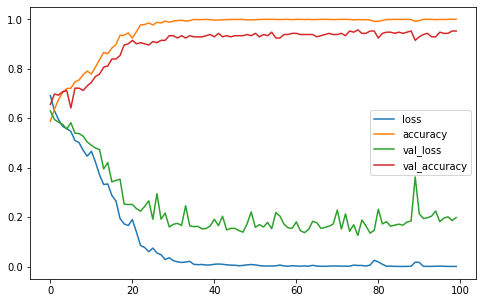

Results for fold 7
Epoch 1/100
30/30 [==============================] - 3s 72ms/step - loss: 0.7758 - accuracy: 0.5256 - val_loss: 0.6386 - val_accuracy: 0.6368
Epoch 2/100
30/30 [==============================] - 2s 61ms/step - loss: 0.6534 - accuracy: 0.6297 - val_loss: 0.5887 - val_accuracy: 0.7406
Epoch 3/100
30/30 [==============================] - 2s 61ms/step - loss: 0.6492 - accuracy: 0.6208 - val_loss: 0.6064 - val_accuracy: 0.6887
Epoch 4/100
30/30 [==============================] - 2s 61ms/step - loss: 0.6015 - accuracy: 0.6642 - val_loss: 0.5468 - val_accuracy: 0.7406
Epoch 5/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5736 - accuracy: 0.6867 - val_loss: 0.5050 - val_accuracy: 0.7547
Epoch 6/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5375 - accuracy: 0.7202 - val_loss: 0.4799 - val_accuracy: 0.7830
Epoch 7/100
30/30 [==============================] - 2s 61ms/step - loss: 0.5301 - accuracy: 0.7406 - val_loss: 0.4802 - val_accu

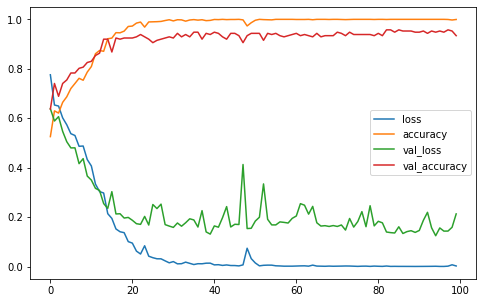

Results for fold 8
Epoch 1/100
30/30 [==============================] - 3s 71ms/step - loss: 0.6845 - accuracy: 0.5675 - val_loss: 0.6267 - val_accuracy: 0.6462
Epoch 2/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6085 - accuracy: 0.6663 - val_loss: 0.5831 - val_accuracy: 0.6887
Epoch 3/100
30/30 [==============================] - 2s 61ms/step - loss: 0.5527 - accuracy: 0.7118 - val_loss: 0.5195 - val_accuracy: 0.7406
Epoch 4/100
30/30 [==============================] - 2s 59ms/step - loss: 0.5194 - accuracy: 0.7469 - val_loss: 0.4946 - val_accuracy: 0.7689
Epoch 5/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5259 - accuracy: 0.7343 - val_loss: 0.5697 - val_accuracy: 0.6792
Epoch 6/100
30/30 [==============================] - 2s 60ms/step - loss: 0.4854 - accuracy: 0.7746 - val_loss: 0.5209 - val_accuracy: 0.7311
Epoch 7/100
30/30 [==============================] - 2s 60ms/step - loss: 0.4619 - accuracy: 0.7856 - val_loss: 0.4465 - val_accu

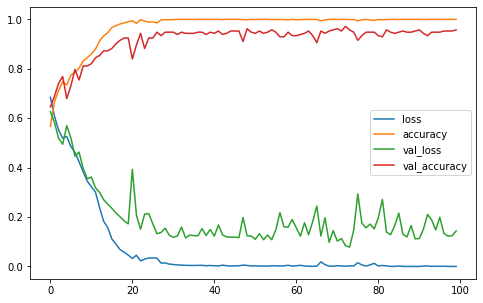

Results for fold 9
Epoch 1/100
30/30 [==============================] - 3s 71ms/step - loss: 0.7097 - accuracy: 0.5528 - val_loss: 0.6332 - val_accuracy: 0.6509
Epoch 2/100
30/30 [==============================] - 2s 61ms/step - loss: 0.6408 - accuracy: 0.6276 - val_loss: 0.6110 - val_accuracy: 0.6698
Epoch 3/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5921 - accuracy: 0.6883 - val_loss: 0.5495 - val_accuracy: 0.7358
Epoch 4/100
30/30 [==============================] - 2s 61ms/step - loss: 0.5625 - accuracy: 0.7139 - val_loss: 0.5142 - val_accuracy: 0.7500
Epoch 5/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5590 - accuracy: 0.7134 - val_loss: 0.5204 - val_accuracy: 0.7311
Epoch 6/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5207 - accuracy: 0.7374 - val_loss: 0.4865 - val_accuracy: 0.7642
Epoch 7/100
30/30 [==============================] - 2s 60ms/step - loss: 0.4780 - accuracy: 0.7772 - val_loss: 0.4333 - val_accu

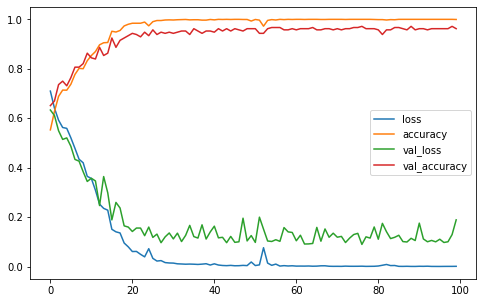

Results for fold 10
Epoch 1/100
30/30 [==============================] - 3s 71ms/step - loss: 0.6917 - accuracy: 0.5816 - val_loss: 0.5909 - val_accuracy: 0.6698
Epoch 2/100
30/30 [==============================] - 2s 59ms/step - loss: 0.6251 - accuracy: 0.6402 - val_loss: 0.5882 - val_accuracy: 0.6698
Epoch 3/100
30/30 [==============================] - 2s 59ms/step - loss: 0.5856 - accuracy: 0.6862 - val_loss: 0.5471 - val_accuracy: 0.7028
Epoch 4/100
30/30 [==============================] - 2s 59ms/step - loss: 0.5645 - accuracy: 0.6993 - val_loss: 0.5333 - val_accuracy: 0.7547
Epoch 5/100
30/30 [==============================] - 2s 61ms/step - loss: 0.5394 - accuracy: 0.7286 - val_loss: 0.5455 - val_accuracy: 0.6981
Epoch 6/100
30/30 [==============================] - 2s 61ms/step - loss: 0.5077 - accuracy: 0.7474 - val_loss: 0.4936 - val_accuracy: 0.7547
Epoch 7/100
30/30 [==============================] - 2s 61ms/step - loss: 0.4776 - accuracy: 0.7673 - val_loss: 0.4549 - val_acc

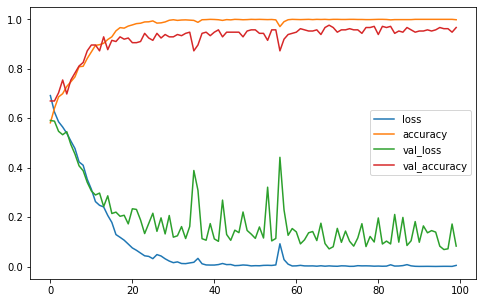

In [ ]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.948305082321167
F1_Score  : 0.9461295505979284


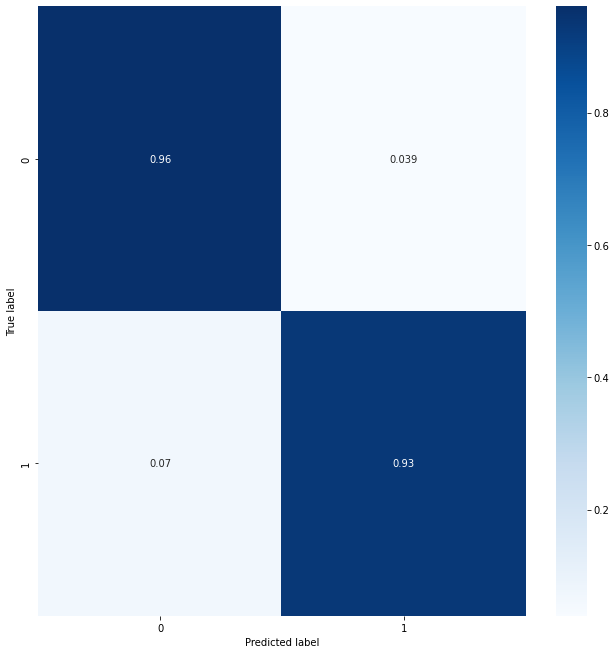

In [ ]:
#50 epochs
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Arousal**

In [ ]:
#arousal
X_train, x_test, Y_train, y_test = train_test_split(data,arousal, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(2124, 36, 256, 1) (236, 36, 256, 1) (2124, 2) (236, 2)


Results for fold 1
Epoch 1/100
30/30 [==============================] - 3s 68ms/step - loss: 0.7280 - accuracy: 0.5463 - val_loss: 0.7590 - val_accuracy: 0.1690
Epoch 2/100
30/30 [==============================] - 2s 58ms/step - loss: 0.6894 - accuracy: 0.5133 - val_loss: 0.6099 - val_accuracy: 0.8404
Epoch 3/100
30/30 [==============================] - 2s 58ms/step - loss: 0.6924 - accuracy: 0.5761 - val_loss: 0.5706 - val_accuracy: 0.8357
Epoch 4/100
30/30 [==============================] - 2s 58ms/step - loss: 0.6643 - accuracy: 0.6143 - val_loss: 0.8606 - val_accuracy: 0.3380
Epoch 5/100
30/30 [==============================] - 2s 58ms/step - loss: 0.6896 - accuracy: 0.4914 - val_loss: 0.5982 - val_accuracy: 0.8216
Epoch 6/100
30/30 [==============================] - 2s 58ms/step - loss: 0.6641 - accuracy: 0.5767 - val_loss: 0.5729 - val_accuracy: 0.8169
Epoch 7/100
30/30 [==============================] - 2s 58ms/step - loss: 0.6260 - accuracy: 0.6091 - val_loss: 0.4578 - val_accu

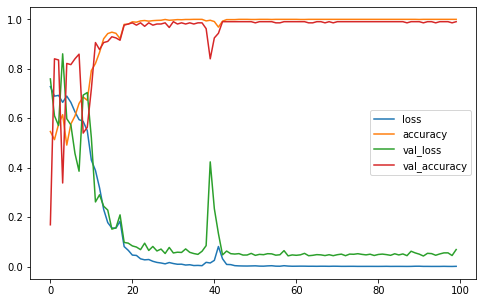

Results for fold 2
Epoch 1/100
30/30 [==============================] - 3s 69ms/step - loss: 0.7171 - accuracy: 0.4778 - val_loss: 0.5636 - val_accuracy: 0.8779
Epoch 2/100
30/30 [==============================] - 2s 58ms/step - loss: 0.6901 - accuracy: 0.5358 - val_loss: 0.6331 - val_accuracy: 0.6526
Epoch 3/100
30/30 [==============================] - 2s 58ms/step - loss: 0.6872 - accuracy: 0.5018 - val_loss: 0.5725 - val_accuracy: 0.7089
Epoch 4/100
30/30 [==============================] - 2s 58ms/step - loss: 0.6531 - accuracy: 0.5468 - val_loss: 0.6515 - val_accuracy: 0.4836
Epoch 5/100
30/30 [==============================] - 2s 58ms/step - loss: 0.6520 - accuracy: 0.5364 - val_loss: 0.5825 - val_accuracy: 0.5775
Epoch 6/100
30/30 [==============================] - 2s 58ms/step - loss: 0.6035 - accuracy: 0.6060 - val_loss: 0.6071 - val_accuracy: 0.5869
Epoch 7/100
30/30 [==============================] - 2s 58ms/step - loss: 0.5983 - accuracy: 0.5615 - val_loss: 0.6065 - val_accu

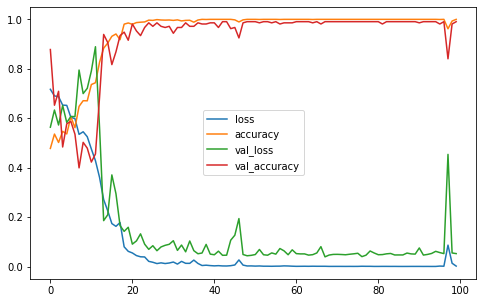

Results for fold 3
Epoch 1/100
30/30 [==============================] - 3s 69ms/step - loss: 0.7217 - accuracy: 0.5102 - val_loss: 0.7353 - val_accuracy: 0.3756
Epoch 2/100
30/30 [==============================] - 2s 58ms/step - loss: 0.6674 - accuracy: 0.6039 - val_loss: 0.7423 - val_accuracy: 0.4131
Epoch 3/100
30/30 [==============================] - 2s 58ms/step - loss: 0.6253 - accuracy: 0.6149 - val_loss: 0.6265 - val_accuracy: 0.5775
Epoch 4/100
30/30 [==============================] - 2s 58ms/step - loss: 0.5871 - accuracy: 0.6410 - val_loss: 0.6348 - val_accuracy: 0.5728
Epoch 5/100
30/30 [==============================] - 2s 59ms/step - loss: 0.4994 - accuracy: 0.7179 - val_loss: 0.4165 - val_accuracy: 0.8075
Epoch 6/100
30/30 [==============================] - 2s 59ms/step - loss: 0.3969 - accuracy: 0.8017 - val_loss: 0.3242 - val_accuracy: 0.8592
Epoch 7/100
30/30 [==============================] - 2s 58ms/step - loss: 0.3404 - accuracy: 0.8524 - val_loss: 0.3947 - val_accu

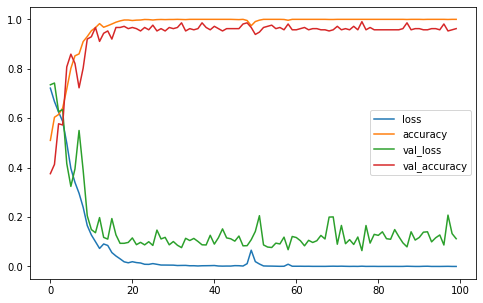

Results for fold 4
Epoch 1/100
30/30 [==============================] - 3s 70ms/step - loss: 0.7228 - accuracy: 0.5426 - val_loss: 0.6711 - val_accuracy: 0.5728
Epoch 2/100
30/30 [==============================] - 2s 59ms/step - loss: 0.6711 - accuracy: 0.5238 - val_loss: 0.4769 - val_accuracy: 0.8216
Epoch 3/100
30/30 [==============================] - 2s 59ms/step - loss: 0.6791 - accuracy: 0.6164 - val_loss: 0.6977 - val_accuracy: 0.5164
Epoch 4/100
30/30 [==============================] - 2s 59ms/step - loss: 0.6263 - accuracy: 0.5871 - val_loss: 0.7644 - val_accuracy: 0.4648
Epoch 5/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6300 - accuracy: 0.6013 - val_loss: 0.5583 - val_accuracy: 0.6385
Epoch 6/100
30/30 [==============================] - 2s 59ms/step - loss: 0.5788 - accuracy: 0.6159 - val_loss: 0.3920 - val_accuracy: 0.8498
Epoch 7/100
30/30 [==============================] - 2s 59ms/step - loss: 0.5701 - accuracy: 0.6395 - val_loss: 0.7782 - val_accu

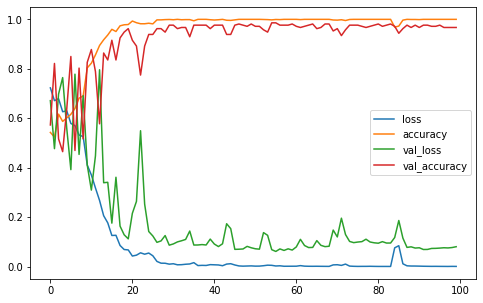

Results for fold 5
Epoch 1/100
30/30 [==============================] - 4s 71ms/step - loss: 0.7314 - accuracy: 0.5000 - val_loss: 0.7216 - val_accuracy: 0.1840
Epoch 2/100
30/30 [==============================] - 2s 59ms/step - loss: 0.6972 - accuracy: 0.5084 - val_loss: 0.6594 - val_accuracy: 0.7877
Epoch 3/100
30/30 [==============================] - 2s 60ms/step - loss: 0.7025 - accuracy: 0.5120 - val_loss: 0.7117 - val_accuracy: 0.3585
Epoch 4/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6909 - accuracy: 0.5539 - val_loss: 0.6120 - val_accuracy: 0.7736
Epoch 5/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6899 - accuracy: 0.5554 - val_loss: 0.7475 - val_accuracy: 0.3396
Epoch 6/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6731 - accuracy: 0.5413 - val_loss: 0.7213 - val_accuracy: 0.4764
Epoch 7/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6770 - accuracy: 0.5099 - val_loss: 0.6664 - val_accu

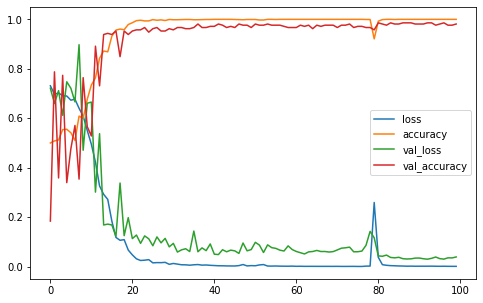

Results for fold 6
Epoch 1/100
30/30 [==============================] - 3s 71ms/step - loss: 0.7099 - accuracy: 0.4691 - val_loss: 0.6962 - val_accuracy: 0.4481
Epoch 2/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6883 - accuracy: 0.6036 - val_loss: 0.6727 - val_accuracy: 0.7689
Epoch 3/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6945 - accuracy: 0.4869 - val_loss: 0.6935 - val_accuracy: 0.4198
Epoch 4/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6772 - accuracy: 0.5288 - val_loss: 0.7599 - val_accuracy: 0.3160
Epoch 5/100
30/30 [==============================] - 2s 59ms/step - loss: 0.6697 - accuracy: 0.5905 - val_loss: 0.6275 - val_accuracy: 0.6038
Epoch 6/100
30/30 [==============================] - 2s 61ms/step - loss: 0.6549 - accuracy: 0.5795 - val_loss: 0.6876 - val_accuracy: 0.4387
Epoch 7/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6243 - accuracy: 0.5800 - val_loss: 0.5184 - val_accu

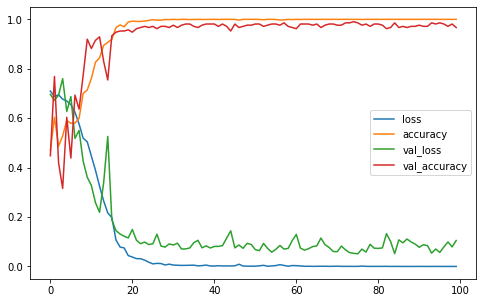

Results for fold 7
Epoch 1/100
30/30 [==============================] - 3s 70ms/step - loss: 0.7135 - accuracy: 0.5392 - val_loss: 0.7708 - val_accuracy: 0.3774
Epoch 2/100
30/30 [==============================] - 2s 61ms/step - loss: 0.7015 - accuracy: 0.5047 - val_loss: 0.6872 - val_accuracy: 0.5283
Epoch 3/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6476 - accuracy: 0.6067 - val_loss: 0.8572 - val_accuracy: 0.3302
Epoch 4/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6489 - accuracy: 0.5502 - val_loss: 0.7507 - val_accuracy: 0.4623
Epoch 5/100
30/30 [==============================] - 2s 61ms/step - loss: 0.5904 - accuracy: 0.6114 - val_loss: 0.4640 - val_accuracy: 0.7453
Epoch 6/100
30/30 [==============================] - 2s 61ms/step - loss: 0.5508 - accuracy: 0.6668 - val_loss: 0.4241 - val_accuracy: 0.7877
Epoch 7/100
30/30 [==============================] - 2s 60ms/step - loss: 0.4709 - accuracy: 0.7406 - val_loss: 0.3600 - val_accu

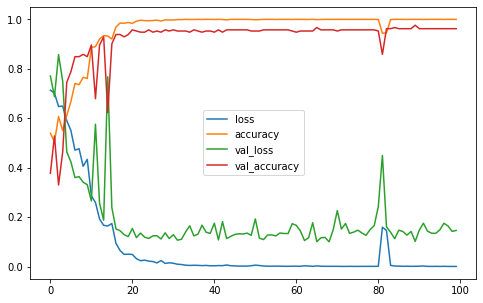

Results for fold 8
Epoch 1/100
30/30 [==============================] - 3s 72ms/step - loss: 0.6994 - accuracy: 0.5214 - val_loss: 0.5808 - val_accuracy: 0.8915
Epoch 2/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6728 - accuracy: 0.5675 - val_loss: 0.7143 - val_accuracy: 0.4575
Epoch 3/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6502 - accuracy: 0.5879 - val_loss: 0.4387 - val_accuracy: 0.8726
Epoch 4/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6354 - accuracy: 0.6098 - val_loss: 0.6605 - val_accuracy: 0.5472
Epoch 5/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5973 - accuracy: 0.5994 - val_loss: 0.6290 - val_accuracy: 0.5660
Epoch 6/100
30/30 [==============================] - 2s 61ms/step - loss: 0.5350 - accuracy: 0.6715 - val_loss: 0.4857 - val_accuracy: 0.6604
Epoch 7/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5088 - accuracy: 0.7087 - val_loss: 0.6102 - val_accu

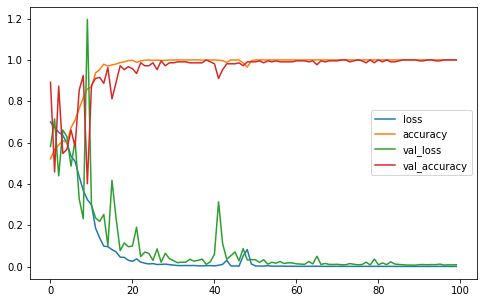

Results for fold 9
Epoch 1/100
30/30 [==============================] - 3s 71ms/step - loss: 0.7192 - accuracy: 0.5031 - val_loss: 0.5958 - val_accuracy: 0.8113
Epoch 2/100
30/30 [==============================] - 2s 60ms/step - loss: 0.7041 - accuracy: 0.6009 - val_loss: 0.6362 - val_accuracy: 0.6509
Epoch 3/100
30/30 [==============================] - 2s 61ms/step - loss: 0.6968 - accuracy: 0.5816 - val_loss: 0.6949 - val_accuracy: 0.5519
Epoch 4/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6597 - accuracy: 0.5758 - val_loss: 0.5084 - val_accuracy: 0.7925
Epoch 5/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6475 - accuracy: 0.6240 - val_loss: 0.7364 - val_accuracy: 0.4670
Epoch 6/100
30/30 [==============================] - 2s 61ms/step - loss: 0.6184 - accuracy: 0.6266 - val_loss: 0.5105 - val_accuracy: 0.7075
Epoch 7/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6033 - accuracy: 0.6820 - val_loss: 0.6011 - val_accu

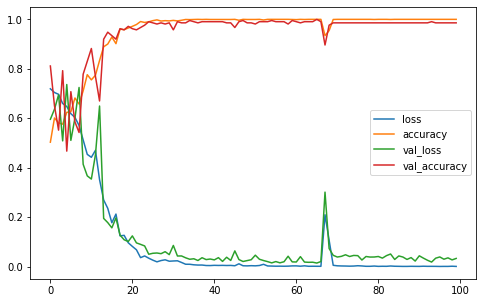

Results for fold 10
Epoch 1/100
30/30 [==============================] - 3s 71ms/step - loss: 0.7621 - accuracy: 0.4555 - val_loss: 0.6524 - val_accuracy: 0.7830
Epoch 2/100
30/30 [==============================] - 2s 61ms/step - loss: 0.6914 - accuracy: 0.5507 - val_loss: 0.8473 - val_accuracy: 0.1509
Epoch 3/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6861 - accuracy: 0.4503 - val_loss: 0.6419 - val_accuracy: 0.6651
Epoch 4/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6640 - accuracy: 0.5643 - val_loss: 0.7285 - val_accuracy: 0.4009
Epoch 5/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6449 - accuracy: 0.5366 - val_loss: 0.5805 - val_accuracy: 0.5660
Epoch 6/100
30/30 [==============================] - 2s 61ms/step - loss: 0.6088 - accuracy: 0.5795 - val_loss: 0.5893 - val_accuracy: 0.5566
Epoch 7/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5669 - accuracy: 0.6355 - val_loss: 0.6039 - val_acc

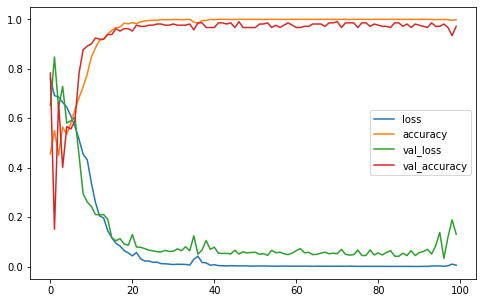

In [ ]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9834745824337006
F1_Score  : 0.9716094280995172


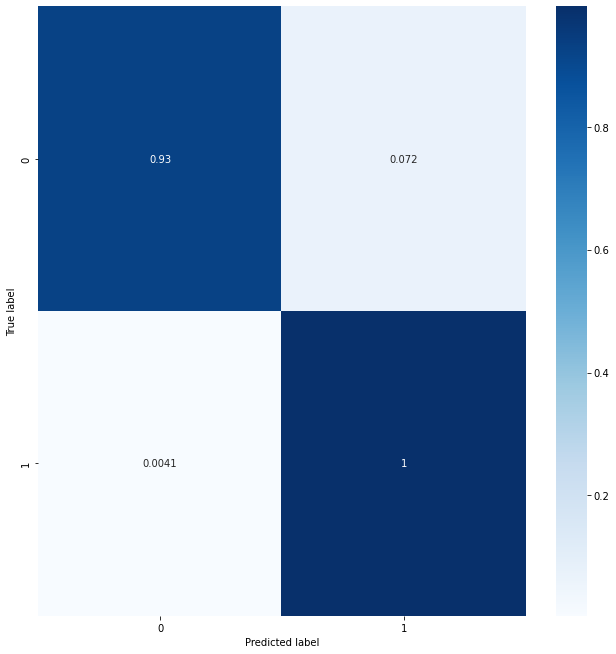

In [ ]:
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Subject 14**

In [ ]:
eeg_signal = []
valence = []
arousal = []
window_size = 256
no_channels = 32
no_new_channels = len(new_channels)
no_videos = 40
Trsld = 5

for person in range(14,15):
  print('Person No.' + str(person))
  
  
  # EEG files address
  if person < 10 :
    address = input_path+'s0'+str(person)+'.dat'
  else :
    address = input_path+'s'+str(person)+'.dat'

  with open(address, 'rb') as file:
    data = pkl.load(file, encoding = 'latin1')

  eeg = data['data']
  label = data['labels']
  
  # Assigning classes
  label[label<Trsld] = 0
  label[label>=Trsld] = 1

  val = label.T[0] # Valence label
  aro = label.T[1] # Arousal label

  del data, label
  # Iterating through 40 vidoes/trials
  for i in range(no_videos):
    sig = eeg[i][:no_channels, :]
    sig = baseline_remove(sig)
    temp = []
    for j in new_channels:
      temp.append(sig[j, :])
    sig = np.reshape(temp,[no_new_channels,-1])
    # Segmenting into 2 seconds (256 timesteps) windows without overlap
    start = 0
    while start + window_size <=sig.shape[1]:
      eeg_signal.append(sig[:, start:start+window_size])
      valence.append(val[i])
      arousal.append(aro[i])
      start += skip
  del eeg, val, aro, sig
eeg_signal = np.reshape(eeg_signal,[-1,no_new_channels,window_size,1])
data = np.asarray(eeg_signal, dtype = np.float32) # Using 32 bit floating point value to save memory
del eeg_signal
valence = np.asarray(valence, dtype = np.int8)
arousal = np.asarray(arousal, dtype = np.int8)

print(data.shape)
print(valence.shape, valence[valence == 0].shape, valence[valence == 1].shape)
print(arousal.shape, arousal[arousal == 0].shape, arousal[arousal == 1].shape)

valence = np_utils.to_categorical(valence)
arousal = np_utils.to_categorical(arousal)
gc.collect()

Person No.14
(2360, 36, 256, 1)
(2360,) (1180,) (1180,)
(2360,) (767,) (1593,)


3576

# **Valence**

In [ ]:
#valence
X_train, x_test, Y_train, y_test = train_test_split(data, valence, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(2124, 36, 256, 1) (236, 36, 256, 1) (2124, 2) (236, 2)


Results for fold 1
Epoch 1/100
30/30 [==============================] - 3s 70ms/step - loss: 0.6858 - accuracy: 0.5835 - val_loss: 0.5941 - val_accuracy: 0.7042
Epoch 2/100
30/30 [==============================] - 2s 58ms/step - loss: 0.6211 - accuracy: 0.6599 - val_loss: 0.5167 - val_accuracy: 0.7371
Epoch 3/100
30/30 [==============================] - 2s 58ms/step - loss: 0.5618 - accuracy: 0.7054 - val_loss: 0.4676 - val_accuracy: 0.7653
Epoch 4/100
30/30 [==============================] - 2s 59ms/step - loss: 0.4958 - accuracy: 0.7525 - val_loss: 0.4088 - val_accuracy: 0.7934
Epoch 5/100
30/30 [==============================] - 2s 58ms/step - loss: 0.4347 - accuracy: 0.7954 - val_loss: 0.3570 - val_accuracy: 0.8404
Epoch 6/100
30/30 [==============================] - 2s 59ms/step - loss: 0.4062 - accuracy: 0.8132 - val_loss: 0.3363 - val_accuracy: 0.8451
Epoch 7/100
30/30 [==============================] - 2s 58ms/step - loss: 0.3609 - accuracy: 0.8378 - val_loss: 0.3178 - val_accu

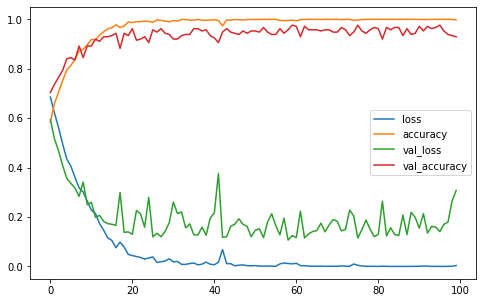

Results for fold 2
Epoch 1/100
30/30 [==============================] - 3s 70ms/step - loss: 0.7643 - accuracy: 0.5003 - val_loss: 0.6641 - val_accuracy: 0.5493
Epoch 2/100
30/30 [==============================] - 2s 58ms/step - loss: 0.6882 - accuracy: 0.5458 - val_loss: 0.6350 - val_accuracy: 0.6714
Epoch 3/100
30/30 [==============================] - 2s 58ms/step - loss: 0.6458 - accuracy: 0.6463 - val_loss: 0.6283 - val_accuracy: 0.6009
Epoch 4/100
30/30 [==============================] - 2s 59ms/step - loss: 0.5963 - accuracy: 0.6876 - val_loss: 0.5882 - val_accuracy: 0.6714
Epoch 5/100
30/30 [==============================] - 2s 59ms/step - loss: 0.5418 - accuracy: 0.7321 - val_loss: 0.5016 - val_accuracy: 0.7606
Epoch 6/100
30/30 [==============================] - 2s 59ms/step - loss: 0.5090 - accuracy: 0.7425 - val_loss: 0.4644 - val_accuracy: 0.7793
Epoch 7/100
30/30 [==============================] - 2s 59ms/step - loss: 0.4874 - accuracy: 0.7609 - val_loss: 0.4508 - val_accu

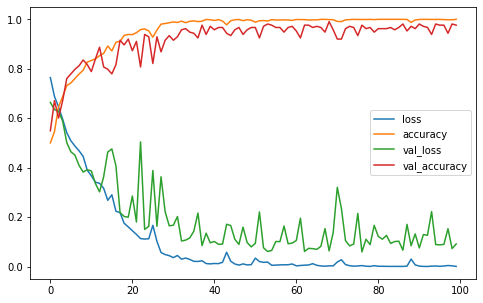

Results for fold 3
Epoch 1/100
30/30 [==============================] - 3s 70ms/step - loss: 0.7256 - accuracy: 0.5348 - val_loss: 0.6430 - val_accuracy: 0.6573
Epoch 2/100
30/30 [==============================] - 2s 59ms/step - loss: 0.6567 - accuracy: 0.6117 - val_loss: 0.6463 - val_accuracy: 0.5869
Epoch 3/100
30/30 [==============================] - 2s 59ms/step - loss: 0.6222 - accuracy: 0.6478 - val_loss: 0.6504 - val_accuracy: 0.5728
Epoch 4/100
30/30 [==============================] - 2s 59ms/step - loss: 0.5652 - accuracy: 0.6944 - val_loss: 0.6805 - val_accuracy: 0.6197
Epoch 5/100
30/30 [==============================] - 2s 59ms/step - loss: 0.5454 - accuracy: 0.7237 - val_loss: 0.5303 - val_accuracy: 0.7324
Epoch 6/100
30/30 [==============================] - 2s 59ms/step - loss: 0.4950 - accuracy: 0.7483 - val_loss: 0.4768 - val_accuracy: 0.7512
Epoch 7/100
30/30 [==============================] - 2s 60ms/step - loss: 0.4677 - accuracy: 0.7750 - val_loss: 0.5100 - val_accu

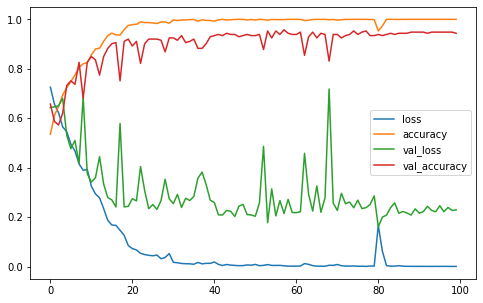

Results for fold 4
Epoch 1/100
30/30 [==============================] - 3s 70ms/step - loss: 0.7110 - accuracy: 0.5374 - val_loss: 0.6148 - val_accuracy: 0.7042
Epoch 2/100
30/30 [==============================] - 2s 59ms/step - loss: 0.6471 - accuracy: 0.6102 - val_loss: 0.5656 - val_accuracy: 0.7746
Epoch 3/100
30/30 [==============================] - 2s 59ms/step - loss: 0.6200 - accuracy: 0.6588 - val_loss: 0.4923 - val_accuracy: 0.7887
Epoch 4/100
30/30 [==============================] - 2s 59ms/step - loss: 0.5599 - accuracy: 0.6965 - val_loss: 0.4303 - val_accuracy: 0.8075
Epoch 5/100
30/30 [==============================] - 2s 59ms/step - loss: 0.5124 - accuracy: 0.7457 - val_loss: 0.4518 - val_accuracy: 0.7606
Epoch 6/100
30/30 [==============================] - 2s 60ms/step - loss: 0.4692 - accuracy: 0.7698 - val_loss: 0.4217 - val_accuracy: 0.7887
Epoch 7/100
30/30 [==============================] - 2s 60ms/step - loss: 0.4304 - accuracy: 0.7970 - val_loss: 0.3367 - val_accu

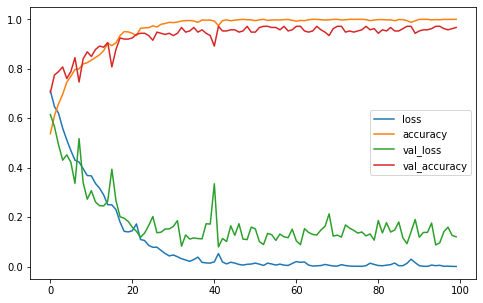

Results for fold 5
Epoch 1/100
30/30 [==============================] - 3s 71ms/step - loss: 0.6900 - accuracy: 0.5533 - val_loss: 0.6266 - val_accuracy: 0.6792
Epoch 2/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6228 - accuracy: 0.6637 - val_loss: 0.5413 - val_accuracy: 0.7547
Epoch 3/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5850 - accuracy: 0.6977 - val_loss: 0.5407 - val_accuracy: 0.7075
Epoch 4/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5217 - accuracy: 0.7495 - val_loss: 0.4659 - val_accuracy: 0.7783
Epoch 5/100
30/30 [==============================] - 2s 60ms/step - loss: 0.4807 - accuracy: 0.7673 - val_loss: 0.4344 - val_accuracy: 0.8066
Epoch 6/100
30/30 [==============================] - 2s 60ms/step - loss: 0.4493 - accuracy: 0.7882 - val_loss: 0.3886 - val_accuracy: 0.8208
Epoch 7/100
30/30 [==============================] - 2s 60ms/step - loss: 0.4142 - accuracy: 0.8149 - val_loss: 0.3522 - val_accu

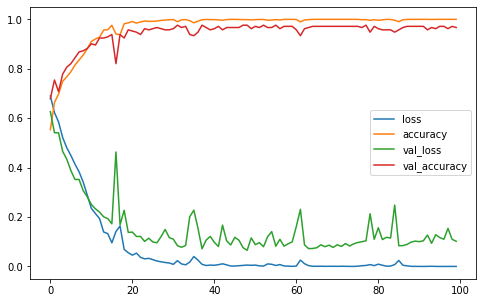

Results for fold 6
Epoch 1/100
30/30 [==============================] - 3s 71ms/step - loss: 0.6685 - accuracy: 0.6030 - val_loss: 0.6088 - val_accuracy: 0.6745
Epoch 2/100
30/30 [==============================] - 2s 59ms/step - loss: 0.6026 - accuracy: 0.6705 - val_loss: 0.5260 - val_accuracy: 0.7642
Epoch 3/100
30/30 [==============================] - 2s 61ms/step - loss: 0.5368 - accuracy: 0.7312 - val_loss: 0.4725 - val_accuracy: 0.7925
Epoch 4/100
30/30 [==============================] - 2s 59ms/step - loss: 0.4652 - accuracy: 0.7709 - val_loss: 0.4219 - val_accuracy: 0.8160
Epoch 5/100
30/30 [==============================] - 2s 60ms/step - loss: 0.4327 - accuracy: 0.7971 - val_loss: 0.5073 - val_accuracy: 0.7217
Epoch 6/100
30/30 [==============================] - 2s 60ms/step - loss: 0.3789 - accuracy: 0.8300 - val_loss: 0.5076 - val_accuracy: 0.7453
Epoch 7/100
30/30 [==============================] - 2s 61ms/step - loss: 0.3592 - accuracy: 0.8353 - val_loss: 0.3248 - val_accu

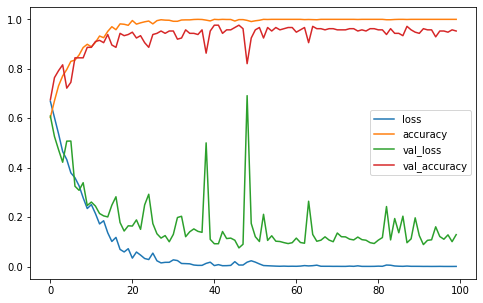

Results for fold 7
Epoch 1/100
30/30 [==============================] - 3s 71ms/step - loss: 0.7005 - accuracy: 0.5418 - val_loss: 0.6590 - val_accuracy: 0.6274
Epoch 2/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6362 - accuracy: 0.6454 - val_loss: 0.5734 - val_accuracy: 0.6981
Epoch 3/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5675 - accuracy: 0.7024 - val_loss: 0.5278 - val_accuracy: 0.7170
Epoch 4/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5065 - accuracy: 0.7474 - val_loss: 0.4881 - val_accuracy: 0.7736
Epoch 5/100
30/30 [==============================] - 2s 61ms/step - loss: 0.4500 - accuracy: 0.7882 - val_loss: 0.4583 - val_accuracy: 0.7877
Epoch 6/100
30/30 [==============================] - 2s 61ms/step - loss: 0.3970 - accuracy: 0.8237 - val_loss: 0.3986 - val_accuracy: 0.8160
Epoch 7/100
30/30 [==============================] - 2s 61ms/step - loss: 0.3715 - accuracy: 0.8379 - val_loss: 0.3856 - val_accu

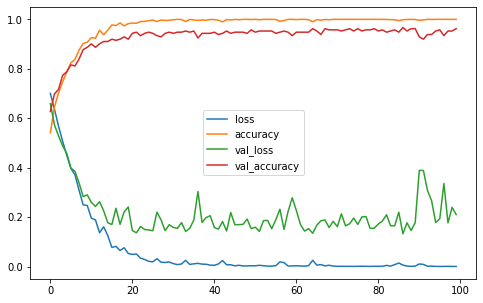

Results for fold 8
Epoch 1/100
30/30 [==============================] - 4s 72ms/step - loss: 0.7627 - accuracy: 0.5361 - val_loss: 0.6468 - val_accuracy: 0.6132
Epoch 2/100
30/30 [==============================] - 2s 61ms/step - loss: 0.6528 - accuracy: 0.6177 - val_loss: 0.5807 - val_accuracy: 0.7311
Epoch 3/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6038 - accuracy: 0.6663 - val_loss: 0.6334 - val_accuracy: 0.6698
Epoch 4/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5200 - accuracy: 0.7296 - val_loss: 0.4614 - val_accuracy: 0.7925
Epoch 5/100
30/30 [==============================] - 2s 60ms/step - loss: 0.4958 - accuracy: 0.7500 - val_loss: 0.4384 - val_accuracy: 0.7925
Epoch 6/100
30/30 [==============================] - 2s 60ms/step - loss: 0.4460 - accuracy: 0.7866 - val_loss: 0.4372 - val_accuracy: 0.8019
Epoch 7/100
30/30 [==============================] - 2s 61ms/step - loss: 0.4080 - accuracy: 0.8169 - val_loss: 0.3985 - val_accu

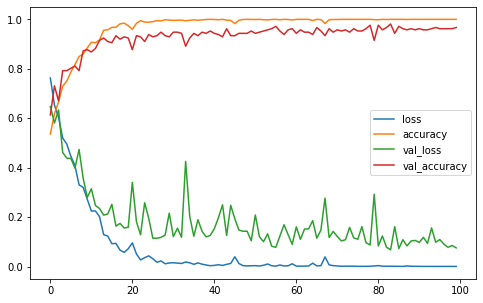

Results for fold 9
Epoch 1/100
30/30 [==============================] - 4s 73ms/step - loss: 0.7153 - accuracy: 0.5293 - val_loss: 0.6338 - val_accuracy: 0.6462
Epoch 2/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6707 - accuracy: 0.5816 - val_loss: 0.5605 - val_accuracy: 0.7689
Epoch 3/100
30/30 [==============================] - 2s 61ms/step - loss: 0.6010 - accuracy: 0.6757 - val_loss: 0.5170 - val_accuracy: 0.7783
Epoch 4/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5688 - accuracy: 0.7129 - val_loss: 0.4637 - val_accuracy: 0.7972
Epoch 5/100
30/30 [==============================] - 2s 61ms/step - loss: 0.5241 - accuracy: 0.7395 - val_loss: 0.5053 - val_accuracy: 0.7453
Epoch 6/100
30/30 [==============================] - 2s 61ms/step - loss: 0.4861 - accuracy: 0.7688 - val_loss: 0.4224 - val_accuracy: 0.8019
Epoch 7/100
30/30 [==============================] - 2s 61ms/step - loss: 0.4535 - accuracy: 0.7861 - val_loss: 0.4188 - val_accu

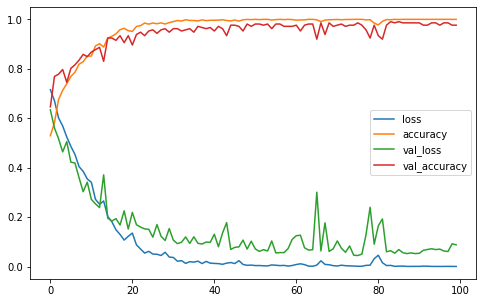

Results for fold 10
Epoch 1/100
30/30 [==============================] - 3s 72ms/step - loss: 0.8037 - accuracy: 0.5167 - val_loss: 0.7019 - val_accuracy: 0.4764
Epoch 2/100
30/30 [==============================] - 2s 61ms/step - loss: 0.6968 - accuracy: 0.5465 - val_loss: 0.6679 - val_accuracy: 0.6085
Epoch 3/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6549 - accuracy: 0.6208 - val_loss: 0.6199 - val_accuracy: 0.6462
Epoch 4/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6122 - accuracy: 0.6496 - val_loss: 0.6156 - val_accuracy: 0.6415
Epoch 5/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5715 - accuracy: 0.6961 - val_loss: 0.5548 - val_accuracy: 0.6887
Epoch 6/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5365 - accuracy: 0.7395 - val_loss: 0.5503 - val_accuracy: 0.7217
Epoch 7/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5124 - accuracy: 0.7526 - val_loss: 0.6653 - val_acc

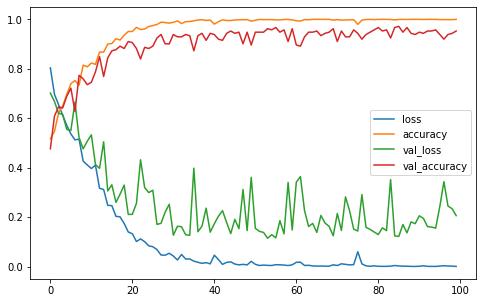

In [ ]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9635593354701996
F1_Score  : 0.9634439239290652


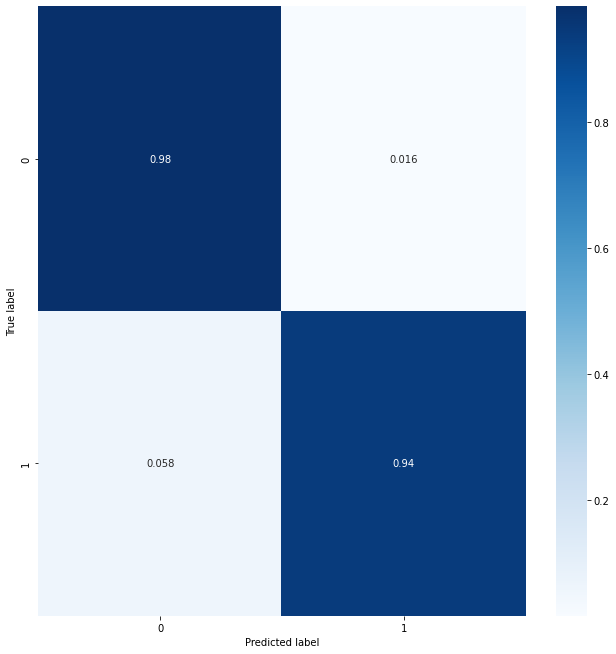

In [ ]:
#50 epochs
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Arousal**

In [ ]:
#arousal
X_train, x_test, Y_train, y_test = train_test_split(data,arousal, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(2124, 36, 256, 1) (236, 36, 256, 1) (2124, 2) (236, 2)


Results for fold 1
Epoch 1/100
30/30 [==============================] - 3s 69ms/step - loss: 0.7386 - accuracy: 0.5322 - val_loss: 0.6580 - val_accuracy: 0.6854
Epoch 2/100
30/30 [==============================] - 2s 58ms/step - loss: 0.6987 - accuracy: 0.5515 - val_loss: 0.6072 - val_accuracy: 0.7136
Epoch 3/100
30/30 [==============================] - 2s 58ms/step - loss: 0.6667 - accuracy: 0.5981 - val_loss: 0.7313 - val_accuracy: 0.4836
Epoch 4/100
30/30 [==============================] - 2s 58ms/step - loss: 0.6344 - accuracy: 0.6295 - val_loss: 0.5384 - val_accuracy: 0.7042
Epoch 5/100
30/30 [==============================] - 2s 58ms/step - loss: 0.5935 - accuracy: 0.6939 - val_loss: 0.5478 - val_accuracy: 0.7606
Epoch 6/100
30/30 [==============================] - 2s 58ms/step - loss: 0.5517 - accuracy: 0.7274 - val_loss: 0.4462 - val_accuracy: 0.8216
Epoch 7/100
30/30 [==============================] - 2s 58ms/step - loss: 0.4909 - accuracy: 0.7828 - val_loss: 0.3926 - val_accu

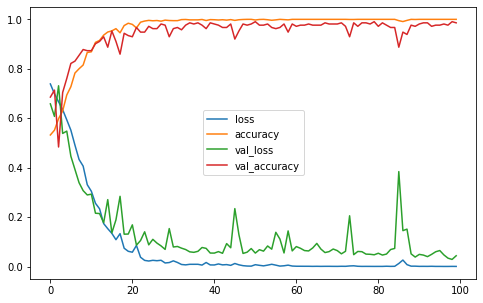

Results for fold 2
Epoch 1/100
30/30 [==============================] - 3s 69ms/step - loss: 0.7073 - accuracy: 0.5071 - val_loss: 0.6436 - val_accuracy: 0.7230
Epoch 2/100
30/30 [==============================] - 2s 58ms/step - loss: 0.6747 - accuracy: 0.5950 - val_loss: 0.5806 - val_accuracy: 0.7700
Epoch 3/100
30/30 [==============================] - 2s 59ms/step - loss: 0.6582 - accuracy: 0.5856 - val_loss: 0.5447 - val_accuracy: 0.7700
Epoch 4/100
30/30 [==============================] - 2s 58ms/step - loss: 0.6028 - accuracy: 0.6782 - val_loss: 0.5049 - val_accuracy: 0.7981
Epoch 5/100
30/30 [==============================] - 2s 58ms/step - loss: 0.5770 - accuracy: 0.7091 - val_loss: 0.7230 - val_accuracy: 0.5634
Epoch 6/100
30/30 [==============================] - 2s 58ms/step - loss: 0.5217 - accuracy: 0.7561 - val_loss: 0.4218 - val_accuracy: 0.8404
Epoch 7/100
30/30 [==============================] - 2s 59ms/step - loss: 0.4441 - accuracy: 0.8090 - val_loss: 0.3673 - val_accu

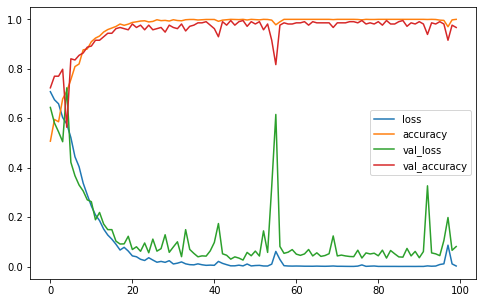

Results for fold 3
Epoch 1/100
30/30 [==============================] - 3s 69ms/step - loss: 0.7163 - accuracy: 0.5212 - val_loss: 0.6706 - val_accuracy: 0.6338
Epoch 2/100
30/30 [==============================] - 2s 59ms/step - loss: 0.6786 - accuracy: 0.5735 - val_loss: 0.6918 - val_accuracy: 0.5352
Epoch 3/100
30/30 [==============================] - 2s 58ms/step - loss: 0.6569 - accuracy: 0.6018 - val_loss: 0.6379 - val_accuracy: 0.6620
Epoch 4/100
30/30 [==============================] - 2s 59ms/step - loss: 0.6450 - accuracy: 0.6170 - val_loss: 0.5901 - val_accuracy: 0.6948
Epoch 5/100
30/30 [==============================] - 2s 59ms/step - loss: 0.5956 - accuracy: 0.6803 - val_loss: 0.5681 - val_accuracy: 0.6995
Epoch 6/100
30/30 [==============================] - 2s 58ms/step - loss: 0.6015 - accuracy: 0.6635 - val_loss: 0.5367 - val_accuracy: 0.7465
Epoch 7/100
30/30 [==============================] - 2s 59ms/step - loss: 0.5361 - accuracy: 0.7394 - val_loss: 0.5079 - val_accu

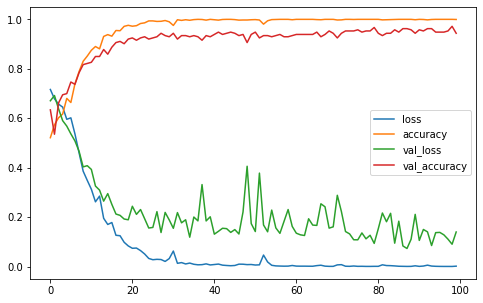

Results for fold 4
Epoch 1/100
30/30 [==============================] - 3s 71ms/step - loss: 0.7217 - accuracy: 0.5275 - val_loss: 0.7120 - val_accuracy: 0.4319
Epoch 2/100
30/30 [==============================] - 2s 59ms/step - loss: 0.6885 - accuracy: 0.5390 - val_loss: 0.6505 - val_accuracy: 0.6432
Epoch 3/100
30/30 [==============================] - 2s 59ms/step - loss: 0.6815 - accuracy: 0.5631 - val_loss: 0.6191 - val_accuracy: 0.7042
Epoch 4/100
30/30 [==============================] - 2s 59ms/step - loss: 0.6681 - accuracy: 0.6018 - val_loss: 0.6726 - val_accuracy: 0.5399
Epoch 5/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6301 - accuracy: 0.6170 - val_loss: 0.5738 - val_accuracy: 0.6948
Epoch 6/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5596 - accuracy: 0.7080 - val_loss: 0.4751 - val_accuracy: 0.7887
Epoch 7/100
30/30 [==============================] - 2s 60ms/step - loss: 0.4962 - accuracy: 0.7535 - val_loss: 0.3801 - val_accu

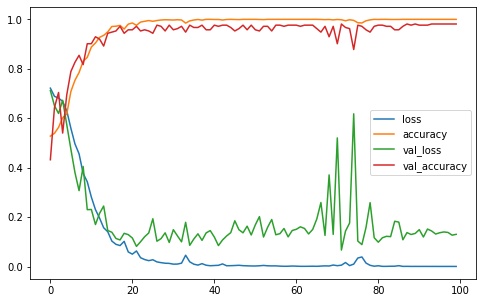

Results for fold 5
Epoch 1/100
30/30 [==============================] - 3s 70ms/step - loss: 0.8121 - accuracy: 0.5131 - val_loss: 0.6665 - val_accuracy: 0.6462
Epoch 2/100
30/30 [==============================] - 2s 59ms/step - loss: 0.7304 - accuracy: 0.5513 - val_loss: 0.6207 - val_accuracy: 0.6462
Epoch 3/100
30/30 [==============================] - 2s 59ms/step - loss: 0.7011 - accuracy: 0.5497 - val_loss: 0.6021 - val_accuracy: 0.7217
Epoch 4/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6912 - accuracy: 0.5879 - val_loss: 0.6066 - val_accuracy: 0.7783
Epoch 5/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6808 - accuracy: 0.5737 - val_loss: 0.6158 - val_accuracy: 0.7406
Epoch 6/100
30/30 [==============================] - 2s 59ms/step - loss: 0.6418 - accuracy: 0.6334 - val_loss: 0.5567 - val_accuracy: 0.7123
Epoch 7/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5977 - accuracy: 0.6794 - val_loss: 0.4840 - val_accu

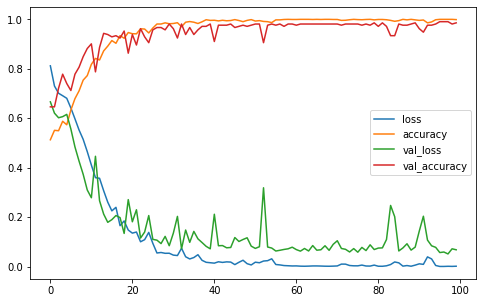

Results for fold 6
Epoch 1/100
30/30 [==============================] - 3s 70ms/step - loss: 0.7308 - accuracy: 0.5105 - val_loss: 0.6814 - val_accuracy: 0.6557
Epoch 2/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6992 - accuracy: 0.5523 - val_loss: 0.6711 - val_accuracy: 0.6462
Epoch 3/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6876 - accuracy: 0.5690 - val_loss: 0.6919 - val_accuracy: 0.4292
Epoch 4/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6693 - accuracy: 0.5931 - val_loss: 0.6189 - val_accuracy: 0.7217
Epoch 5/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6548 - accuracy: 0.6428 - val_loss: 0.5765 - val_accuracy: 0.7689
Epoch 6/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6252 - accuracy: 0.6438 - val_loss: 0.5574 - val_accuracy: 0.7783
Epoch 7/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5779 - accuracy: 0.6825 - val_loss: 0.4586 - val_accu

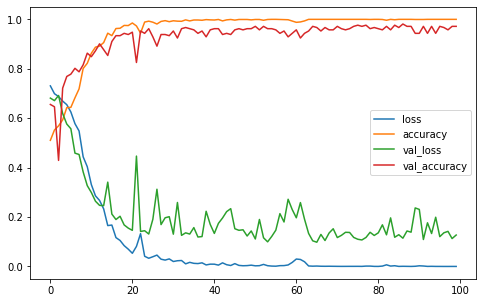

Results for fold 7
Epoch 1/100
30/30 [==============================] - 4s 71ms/step - loss: 0.7255 - accuracy: 0.5146 - val_loss: 0.6942 - val_accuracy: 0.5142
Epoch 2/100
30/30 [==============================] - 2s 59ms/step - loss: 0.6922 - accuracy: 0.5507 - val_loss: 0.7306 - val_accuracy: 0.4575
Epoch 3/100
30/30 [==============================] - 2s 59ms/step - loss: 0.6612 - accuracy: 0.5842 - val_loss: 0.5860 - val_accuracy: 0.7170
Epoch 4/100
30/30 [==============================] - 2s 59ms/step - loss: 0.6414 - accuracy: 0.6386 - val_loss: 0.5464 - val_accuracy: 0.7406
Epoch 5/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5899 - accuracy: 0.6930 - val_loss: 0.4704 - val_accuracy: 0.8302
Epoch 6/100
30/30 [==============================] - 2s 61ms/step - loss: 0.5018 - accuracy: 0.7610 - val_loss: 0.3761 - val_accuracy: 0.8443
Epoch 7/100
30/30 [==============================] - 2s 61ms/step - loss: 0.4327 - accuracy: 0.8112 - val_loss: 0.3426 - val_accu

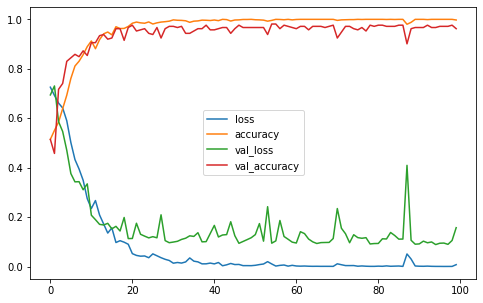

Results for fold 8
Epoch 1/100
30/30 [==============================] - 4s 73ms/step - loss: 0.7256 - accuracy: 0.5288 - val_loss: 0.6228 - val_accuracy: 0.6981
Epoch 2/100
30/30 [==============================] - 2s 61ms/step - loss: 0.6812 - accuracy: 0.5696 - val_loss: 0.6520 - val_accuracy: 0.6462
Epoch 3/100
30/30 [==============================] - 2s 61ms/step - loss: 0.6632 - accuracy: 0.6124 - val_loss: 0.5969 - val_accuracy: 0.7500
Epoch 4/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6472 - accuracy: 0.6308 - val_loss: 0.5526 - val_accuracy: 0.7358
Epoch 5/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6200 - accuracy: 0.6538 - val_loss: 0.5097 - val_accuracy: 0.7547
Epoch 6/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6081 - accuracy: 0.6705 - val_loss: 0.5263 - val_accuracy: 0.7358
Epoch 7/100
30/30 [==============================] - 2s 61ms/step - loss: 0.5166 - accuracy: 0.7469 - val_loss: 0.4342 - val_accu

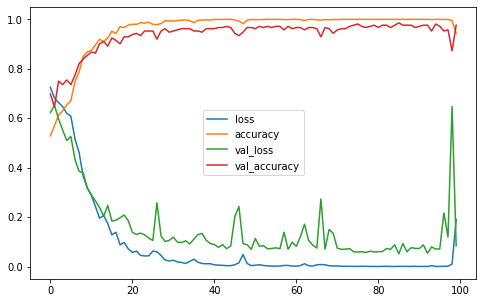

Results for fold 9
Epoch 1/100
30/30 [==============================] - 3s 72ms/step - loss: 0.7072 - accuracy: 0.5486 - val_loss: 0.8186 - val_accuracy: 0.3160
Epoch 2/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6793 - accuracy: 0.5649 - val_loss: 0.6207 - val_accuracy: 0.7028
Epoch 3/100
30/30 [==============================] - 2s 59ms/step - loss: 0.6418 - accuracy: 0.6459 - val_loss: 0.6410 - val_accuracy: 0.6462
Epoch 4/100
30/30 [==============================] - 2s 61ms/step - loss: 0.5935 - accuracy: 0.6982 - val_loss: 0.5939 - val_accuracy: 0.6981
Epoch 5/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5202 - accuracy: 0.7573 - val_loss: 0.5677 - val_accuracy: 0.7123
Epoch 6/100
30/30 [==============================] - 2s 60ms/step - loss: 0.4664 - accuracy: 0.8033 - val_loss: 0.4418 - val_accuracy: 0.8255
Epoch 7/100
30/30 [==============================] - 2s 61ms/step - loss: 0.4266 - accuracy: 0.8159 - val_loss: 0.6533 - val_accu

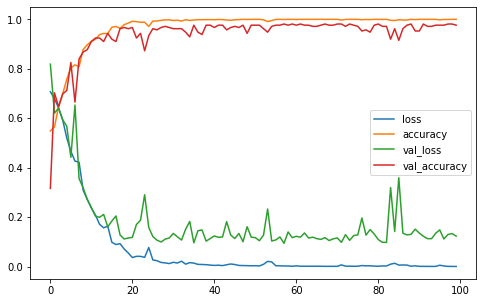

Results for fold 10
Epoch 1/100
30/30 [==============================] - 3s 71ms/step - loss: 0.7188 - accuracy: 0.5601 - val_loss: 0.7102 - val_accuracy: 0.4764
Epoch 2/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6761 - accuracy: 0.5748 - val_loss: 0.5718 - val_accuracy: 0.7783
Epoch 3/100
30/30 [==============================] - 2s 61ms/step - loss: 0.6267 - accuracy: 0.6527 - val_loss: 0.5041 - val_accuracy: 0.7594
Epoch 4/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5794 - accuracy: 0.7003 - val_loss: 0.4484 - val_accuracy: 0.8255
Epoch 5/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5144 - accuracy: 0.7463 - val_loss: 0.3869 - val_accuracy: 0.8632
Epoch 6/100
30/30 [==============================] - 2s 61ms/step - loss: 0.4424 - accuracy: 0.8101 - val_loss: 0.4599 - val_accuracy: 0.7594
Epoch 7/100
30/30 [==============================] - 2s 61ms/step - loss: 0.4380 - accuracy: 0.8002 - val_loss: 0.4364 - val_acc

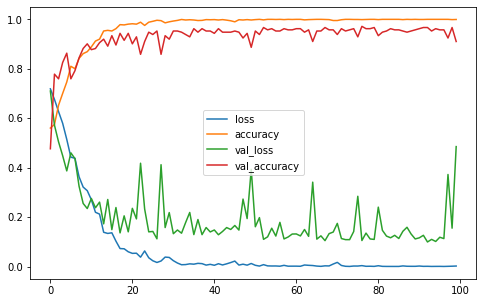

In [ ]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9461864471435547
F1_Score  : 0.9412203979941702


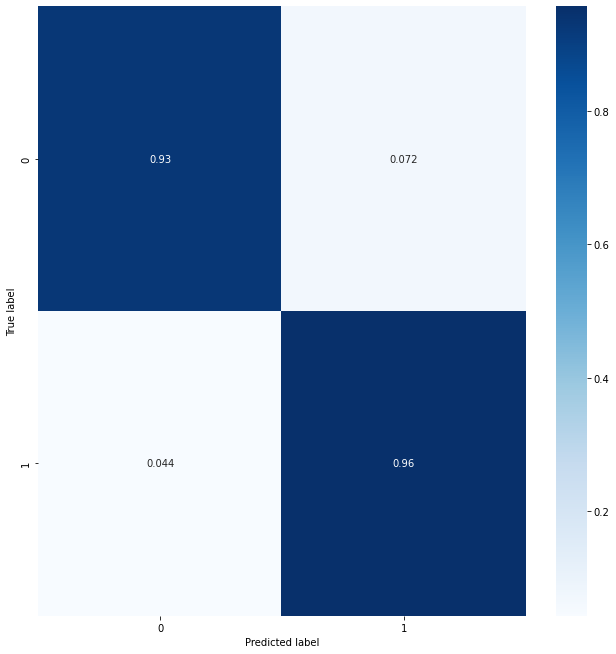

In [ ]:
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Subject 15**

In [ ]:
eeg_signal = []
valence = []
arousal = []
window_size = 256
no_channels = 32
no_new_channels = len(new_channels)
no_videos = 40
Trsld = 5

for person in range(15,16):
  print('Person No.' + str(person))
  
  
  # EEG files address
  if person < 10 :
    address = input_path+'s0'+str(person)+'.dat'
  else :
    address = input_path+'s'+str(person)+'.dat'

  with open(address, 'rb') as file:
    data = pkl.load(file, encoding = 'latin1')

  eeg = data['data']
  label = data['labels']
  
  # Assigning classes
  label[label<Trsld] = 0
  label[label>=Trsld] = 1

  val = label.T[0] # Valence label
  aro = label.T[1] # Arousal label

  del data, label
  # Iterating through 40 vidoes/trials
  for i in range(no_videos):
    sig = eeg[i][:no_channels, :]
    sig = baseline_remove(sig)
    temp = []
    for j in new_channels:
      temp.append(sig[j, :])
    sig = np.reshape(temp,[no_new_channels,-1])
    # Segmenting into 2 seconds (256 timesteps) windows without overlap
    start = 0
    while start + window_size <=sig.shape[1]:
      eeg_signal.append(sig[:, start:start+window_size])
      valence.append(val[i])
      arousal.append(aro[i])
      start += skip
  del eeg, val, aro, sig
eeg_signal = np.reshape(eeg_signal,[-1,no_new_channels,window_size,1])
data = np.asarray(eeg_signal, dtype = np.float32) # Using 32 bit floating point value to save memory
del eeg_signal
valence = np.asarray(valence, dtype = np.int8)
arousal = np.asarray(arousal, dtype = np.int8)

print(data.shape)
print(valence.shape, valence[valence == 0].shape, valence[valence == 1].shape)
print(arousal.shape, arousal[arousal == 0].shape, arousal[arousal == 1].shape)

valence = np_utils.to_categorical(valence)
arousal = np_utils.to_categorical(arousal)
gc.collect()

Person No.15
(2360, 36, 256, 1)
(2360,) (1180,) (1180,)
(2360,) (1121,) (1239,)


3576

# **Valence**

In [ ]:
#valence
X_train, x_test, Y_train, y_test = train_test_split(data, valence, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(2124, 36, 256, 1) (236, 36, 256, 1) (2124, 2) (236, 2)


Results for fold 1
Epoch 1/100
30/30 [==============================] - 3s 69ms/step - loss: 0.7373 - accuracy: 0.5500 - val_loss: 0.6481 - val_accuracy: 0.6808
Epoch 2/100
30/30 [==============================] - 2s 58ms/step - loss: 0.6476 - accuracy: 0.6096 - val_loss: 0.5683 - val_accuracy: 0.6948
Epoch 3/100
30/30 [==============================] - 2s 58ms/step - loss: 0.5559 - accuracy: 0.7138 - val_loss: 0.5055 - val_accuracy: 0.7277
Epoch 4/100
30/30 [==============================] - 2s 58ms/step - loss: 0.4500 - accuracy: 0.8137 - val_loss: 0.2968 - val_accuracy: 0.8920
Epoch 5/100
30/30 [==============================] - 2s 58ms/step - loss: 0.3785 - accuracy: 0.8409 - val_loss: 0.2386 - val_accuracy: 0.9155
Epoch 6/100
30/30 [==============================] - 2s 58ms/step - loss: 0.2965 - accuracy: 0.8833 - val_loss: 0.1946 - val_accuracy: 0.9437
Epoch 7/100
30/30 [==============================] - 2s 58ms/step - loss: 0.2348 - accuracy: 0.9110 - val_loss: 0.1761 - val_accu

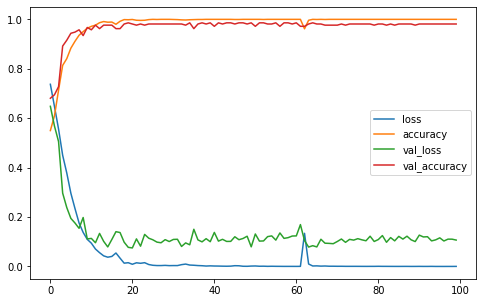

Results for fold 2
Epoch 1/100
30/30 [==============================] - 3s 69ms/step - loss: 0.7333 - accuracy: 0.5615 - val_loss: 0.6395 - val_accuracy: 0.6009
Epoch 2/100
30/30 [==============================] - 2s 58ms/step - loss: 0.6425 - accuracy: 0.6253 - val_loss: 0.5655 - val_accuracy: 0.7089
Epoch 3/100
30/30 [==============================] - 2s 58ms/step - loss: 0.5723 - accuracy: 0.6981 - val_loss: 0.4163 - val_accuracy: 0.8451
Epoch 4/100
30/30 [==============================] - 2s 58ms/step - loss: 0.4414 - accuracy: 0.8027 - val_loss: 0.2944 - val_accuracy: 0.8826
Epoch 5/100
30/30 [==============================] - 2s 58ms/step - loss: 0.3530 - accuracy: 0.8681 - val_loss: 0.2357 - val_accuracy: 0.9014
Epoch 6/100
30/30 [==============================] - 2s 58ms/step - loss: 0.2796 - accuracy: 0.8875 - val_loss: 0.1862 - val_accuracy: 0.9249
Epoch 7/100
30/30 [==============================] - 2s 59ms/step - loss: 0.2210 - accuracy: 0.9173 - val_loss: 0.1365 - val_accu

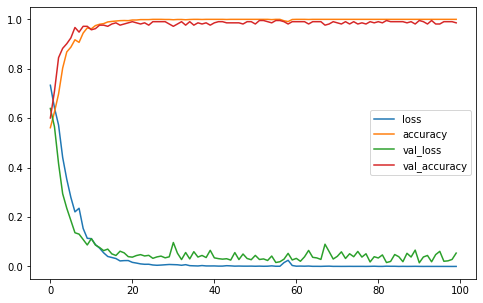

Results for fold 3
Epoch 1/100
30/30 [==============================] - 3s 71ms/step - loss: 0.6798 - accuracy: 0.5850 - val_loss: 0.5716 - val_accuracy: 0.7183
Epoch 2/100
30/30 [==============================] - 2s 59ms/step - loss: 0.5942 - accuracy: 0.6829 - val_loss: 0.5118 - val_accuracy: 0.7418
Epoch 3/100
30/30 [==============================] - 2s 59ms/step - loss: 0.5068 - accuracy: 0.7493 - val_loss: 0.4219 - val_accuracy: 0.8404
Epoch 4/100
30/30 [==============================] - 2s 59ms/step - loss: 0.3997 - accuracy: 0.8341 - val_loss: 0.3186 - val_accuracy: 0.8873
Epoch 5/100
30/30 [==============================] - 2s 59ms/step - loss: 0.3202 - accuracy: 0.8817 - val_loss: 0.2813 - val_accuracy: 0.8920
Epoch 6/100
30/30 [==============================] - 2s 59ms/step - loss: 0.2905 - accuracy: 0.8938 - val_loss: 0.2860 - val_accuracy: 0.8873
Epoch 7/100
30/30 [==============================] - 2s 59ms/step - loss: 0.2486 - accuracy: 0.9079 - val_loss: 0.1966 - val_accu

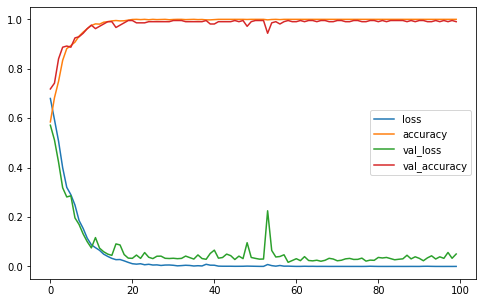

Results for fold 4
Epoch 1/100
30/30 [==============================] - 3s 70ms/step - loss: 0.6453 - accuracy: 0.6238 - val_loss: 0.5756 - val_accuracy: 0.6714
Epoch 2/100
30/30 [==============================] - 2s 59ms/step - loss: 0.5369 - accuracy: 0.7227 - val_loss: 0.4054 - val_accuracy: 0.8263
Epoch 3/100
30/30 [==============================] - 2s 59ms/step - loss: 0.3899 - accuracy: 0.8399 - val_loss: 0.2949 - val_accuracy: 0.8779
Epoch 4/100
30/30 [==============================] - 2s 59ms/step - loss: 0.3476 - accuracy: 0.8613 - val_loss: 0.2999 - val_accuracy: 0.8779
Epoch 5/100
30/30 [==============================] - 2s 59ms/step - loss: 0.2525 - accuracy: 0.9042 - val_loss: 0.1835 - val_accuracy: 0.9390
Epoch 6/100
30/30 [==============================] - 2s 60ms/step - loss: 0.1999 - accuracy: 0.9226 - val_loss: 0.1569 - val_accuracy: 0.9484
Epoch 7/100
30/30 [==============================] - 2s 59ms/step - loss: 0.1527 - accuracy: 0.9492 - val_loss: 0.1080 - val_accu

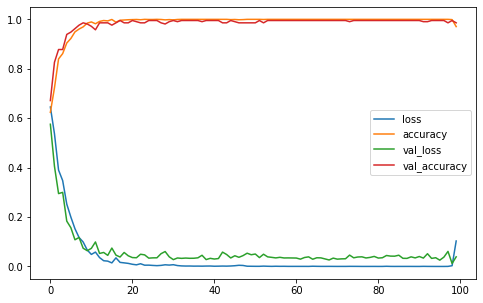

Results for fold 5
Epoch 1/100
30/30 [==============================] - 3s 71ms/step - loss: 0.6700 - accuracy: 0.5863 - val_loss: 0.5603 - val_accuracy: 0.7406
Epoch 2/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5639 - accuracy: 0.7113 - val_loss: 0.4673 - val_accuracy: 0.8349
Epoch 3/100
30/30 [==============================] - 2s 59ms/step - loss: 0.4634 - accuracy: 0.7955 - val_loss: 0.3872 - val_accuracy: 0.8491
Epoch 4/100
30/30 [==============================] - 2s 60ms/step - loss: 0.3746 - accuracy: 0.8530 - val_loss: 0.3224 - val_accuracy: 0.8821
Epoch 5/100
30/30 [==============================] - 2s 60ms/step - loss: 0.3040 - accuracy: 0.8828 - val_loss: 0.3126 - val_accuracy: 0.8632
Epoch 6/100
30/30 [==============================] - 2s 60ms/step - loss: 0.2802 - accuracy: 0.8933 - val_loss: 0.2125 - val_accuracy: 0.9245
Epoch 7/100
30/30 [==============================] - 2s 60ms/step - loss: 0.1995 - accuracy: 0.9320 - val_loss: 0.1317 - val_accu

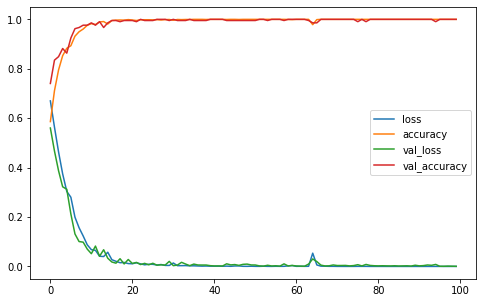

Results for fold 6
Epoch 1/100
30/30 [==============================] - 3s 69ms/step - loss: 0.7156 - accuracy: 0.5345 - val_loss: 0.6298 - val_accuracy: 0.6038
Epoch 2/100
30/30 [==============================] - 2s 59ms/step - loss: 0.6625 - accuracy: 0.6004 - val_loss: 0.5911 - val_accuracy: 0.7311
Epoch 3/100
30/30 [==============================] - 2s 59ms/step - loss: 0.5840 - accuracy: 0.7003 - val_loss: 0.4853 - val_accuracy: 0.7783
Epoch 4/100
30/30 [==============================] - 2s 60ms/step - loss: 0.4818 - accuracy: 0.7845 - val_loss: 0.3880 - val_accuracy: 0.8208
Epoch 5/100
30/30 [==============================] - 2s 60ms/step - loss: 0.4243 - accuracy: 0.8169 - val_loss: 0.3589 - val_accuracy: 0.8396
Epoch 6/100
30/30 [==============================] - 2s 59ms/step - loss: 0.3246 - accuracy: 0.8771 - val_loss: 0.3518 - val_accuracy: 0.8349
Epoch 7/100
30/30 [==============================] - 2s 60ms/step - loss: 0.2696 - accuracy: 0.9017 - val_loss: 0.2445 - val_accu

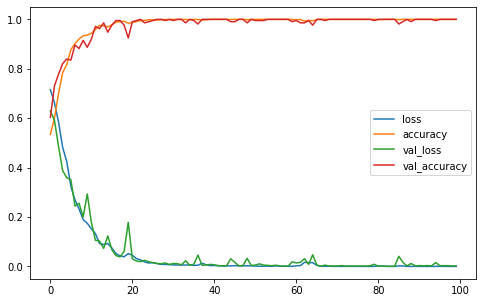

Results for fold 7
Epoch 1/100
30/30 [==============================] - 3s 71ms/step - loss: 0.7732 - accuracy: 0.5335 - val_loss: 0.6474 - val_accuracy: 0.6368
Epoch 2/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6889 - accuracy: 0.5795 - val_loss: 0.6299 - val_accuracy: 0.6132
Epoch 3/100
30/30 [==============================] - 2s 59ms/step - loss: 0.6189 - accuracy: 0.6522 - val_loss: 0.5892 - val_accuracy: 0.6604
Epoch 4/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5105 - accuracy: 0.7683 - val_loss: 0.4441 - val_accuracy: 0.8160
Epoch 5/100
30/30 [==============================] - 2s 60ms/step - loss: 0.4451 - accuracy: 0.7971 - val_loss: 0.5091 - val_accuracy: 0.7736
Epoch 6/100
30/30 [==============================] - 2s 60ms/step - loss: 0.3666 - accuracy: 0.8415 - val_loss: 0.3586 - val_accuracy: 0.8491
Epoch 7/100
30/30 [==============================] - 2s 60ms/step - loss: 0.3054 - accuracy: 0.8792 - val_loss: 0.3064 - val_accu

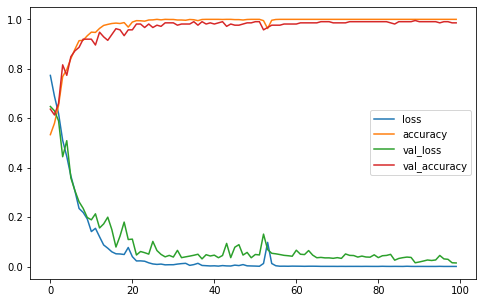

Results for fold 8
Epoch 1/100
30/30 [==============================] - 4s 70ms/step - loss: 0.7198 - accuracy: 0.5350 - val_loss: 0.6295 - val_accuracy: 0.6321
Epoch 2/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6330 - accuracy: 0.6417 - val_loss: 0.5604 - val_accuracy: 0.7028
Epoch 3/100
30/30 [==============================] - 2s 59ms/step - loss: 0.5464 - accuracy: 0.7238 - val_loss: 0.4529 - val_accuracy: 0.8160
Epoch 4/100
30/30 [==============================] - 2s 61ms/step - loss: 0.4326 - accuracy: 0.8164 - val_loss: 0.2870 - val_accuracy: 0.9057
Epoch 5/100
30/30 [==============================] - 2s 61ms/step - loss: 0.3606 - accuracy: 0.8609 - val_loss: 0.2296 - val_accuracy: 0.9198
Epoch 6/100
30/30 [==============================] - 2s 60ms/step - loss: 0.2847 - accuracy: 0.9053 - val_loss: 0.1865 - val_accuracy: 0.9387
Epoch 7/100
30/30 [==============================] - 2s 61ms/step - loss: 0.2199 - accuracy: 0.9189 - val_loss: 0.1422 - val_accu

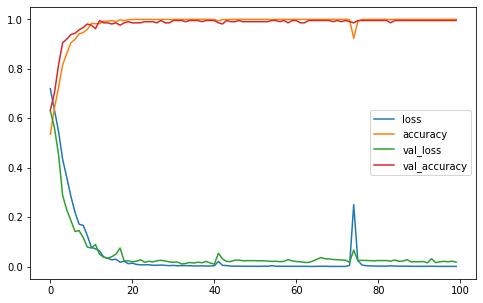

Results for fold 9
Epoch 1/100
30/30 [==============================] - 3s 71ms/step - loss: 0.6765 - accuracy: 0.5816 - val_loss: 0.6221 - val_accuracy: 0.6509
Epoch 2/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6328 - accuracy: 0.6334 - val_loss: 0.5266 - val_accuracy: 0.7736
Epoch 3/100
30/30 [==============================] - 2s 59ms/step - loss: 0.5222 - accuracy: 0.7516 - val_loss: 0.4079 - val_accuracy: 0.8066
Epoch 4/100
30/30 [==============================] - 2s 60ms/step - loss: 0.4496 - accuracy: 0.7992 - val_loss: 0.3534 - val_accuracy: 0.8774
Epoch 5/100
30/30 [==============================] - 2s 60ms/step - loss: 0.3621 - accuracy: 0.8609 - val_loss: 0.2493 - val_accuracy: 0.9104
Epoch 6/100
30/30 [==============================] - 2s 60ms/step - loss: 0.2887 - accuracy: 0.8944 - val_loss: 0.1785 - val_accuracy: 0.9434
Epoch 7/100
30/30 [==============================] - 2s 61ms/step - loss: 0.2637 - accuracy: 0.9012 - val_loss: 0.1433 - val_accu

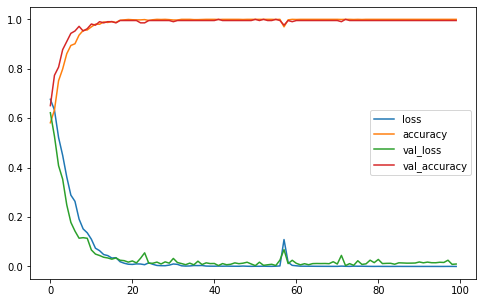

Results for fold 10
Epoch 1/100
30/30 [==============================] - 3s 72ms/step - loss: 0.7236 - accuracy: 0.5502 - val_loss: 0.6256 - val_accuracy: 0.6415
Epoch 2/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6188 - accuracy: 0.6470 - val_loss: 0.5537 - val_accuracy: 0.7500
Epoch 3/100
30/30 [==============================] - 2s 61ms/step - loss: 0.5142 - accuracy: 0.7542 - val_loss: 0.4588 - val_accuracy: 0.7783
Epoch 4/100
30/30 [==============================] - 2s 60ms/step - loss: 0.4137 - accuracy: 0.8175 - val_loss: 0.4852 - val_accuracy: 0.7642
Epoch 5/100
30/30 [==============================] - 2s 60ms/step - loss: 0.3582 - accuracy: 0.8473 - val_loss: 0.3355 - val_accuracy: 0.8585
Epoch 6/100
30/30 [==============================] - 2s 60ms/step - loss: 0.2802 - accuracy: 0.8865 - val_loss: 0.2781 - val_accuracy: 0.8679
Epoch 7/100
30/30 [==============================] - 2s 60ms/step - loss: 0.2853 - accuracy: 0.8828 - val_loss: 0.2621 - val_acc

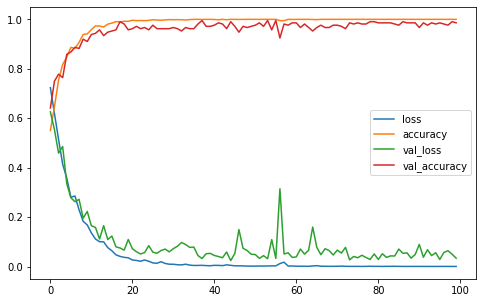

In [ ]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9927965998649597
F1_Score  : 0.9927963590883548


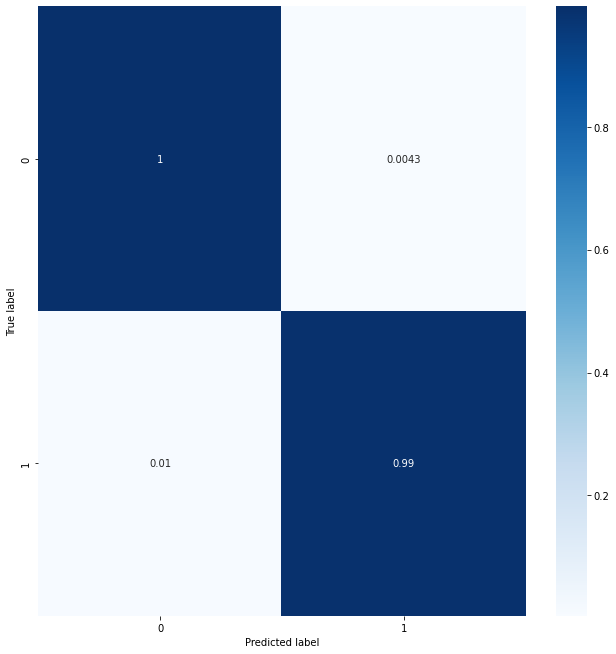

In [ ]:
#50 epochs
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Arousal**

In [ ]:
#arousal
X_train, x_test, Y_train, y_test = train_test_split(data,arousal, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(2124, 36, 256, 1) (236, 36, 256, 1) (2124, 2) (236, 2)


Results for fold 1
Epoch 1/100
30/30 [==============================] - 3s 70ms/step - loss: 0.7120 - accuracy: 0.5426 - val_loss: 0.6523 - val_accuracy: 0.5728
Epoch 2/100
30/30 [==============================] - 2s 58ms/step - loss: 0.6207 - accuracy: 0.6426 - val_loss: 0.6052 - val_accuracy: 0.5869
Epoch 3/100
30/30 [==============================] - 2s 58ms/step - loss: 0.5557 - accuracy: 0.7091 - val_loss: 0.4328 - val_accuracy: 0.8451
Epoch 4/100
30/30 [==============================] - 2s 58ms/step - loss: 0.4266 - accuracy: 0.8064 - val_loss: 0.3397 - val_accuracy: 0.8826
Epoch 5/100
30/30 [==============================] - 2s 58ms/step - loss: 0.3331 - accuracy: 0.8613 - val_loss: 0.2489 - val_accuracy: 0.9202
Epoch 6/100
30/30 [==============================] - 2s 58ms/step - loss: 0.2498 - accuracy: 0.9006 - val_loss: 0.3151 - val_accuracy: 0.8545
Epoch 7/100
30/30 [==============================] - 2s 58ms/step - loss: 0.1893 - accuracy: 0.9367 - val_loss: 0.1400 - val_accu

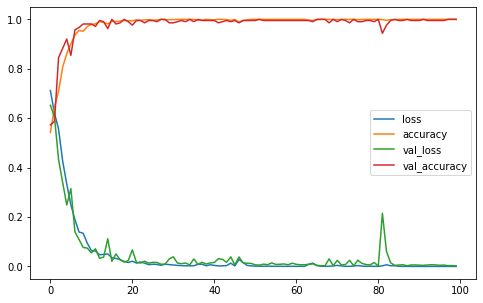

Results for fold 2
Epoch 1/100
30/30 [==============================] - 3s 70ms/step - loss: 0.7258 - accuracy: 0.5437 - val_loss: 0.6546 - val_accuracy: 0.6056
Epoch 2/100
30/30 [==============================] - 2s 58ms/step - loss: 0.6600 - accuracy: 0.6091 - val_loss: 0.5903 - val_accuracy: 0.6714
Epoch 3/100
30/30 [==============================] - 2s 58ms/step - loss: 0.5728 - accuracy: 0.7038 - val_loss: 0.4984 - val_accuracy: 0.7559
Epoch 4/100
30/30 [==============================] - 2s 58ms/step - loss: 0.4935 - accuracy: 0.7525 - val_loss: 0.3720 - val_accuracy: 0.8357
Epoch 5/100
30/30 [==============================] - 2s 58ms/step - loss: 0.3817 - accuracy: 0.8310 - val_loss: 0.2726 - val_accuracy: 0.9249
Epoch 6/100
30/30 [==============================] - 2s 58ms/step - loss: 0.3430 - accuracy: 0.8472 - val_loss: 0.2080 - val_accuracy: 0.9155
Epoch 7/100
30/30 [==============================] - 2s 59ms/step - loss: 0.2924 - accuracy: 0.8744 - val_loss: 0.1633 - val_accu

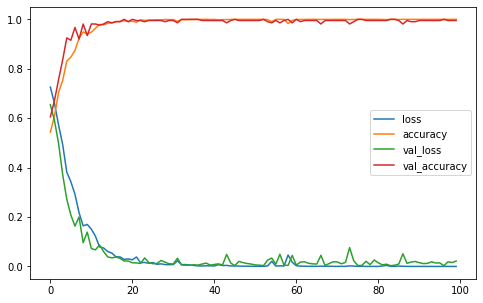

Results for fold 3
Epoch 1/100
30/30 [==============================] - 3s 69ms/step - loss: 0.7607 - accuracy: 0.5060 - val_loss: 0.6969 - val_accuracy: 0.5164
Epoch 2/100
30/30 [==============================] - 2s 58ms/step - loss: 0.6736 - accuracy: 0.5772 - val_loss: 0.5885 - val_accuracy: 0.7277
Epoch 3/100
30/30 [==============================] - 2s 59ms/step - loss: 0.5953 - accuracy: 0.6996 - val_loss: 0.5283 - val_accuracy: 0.7277
Epoch 4/100
30/30 [==============================] - 2s 59ms/step - loss: 0.5015 - accuracy: 0.7593 - val_loss: 0.4129 - val_accuracy: 0.8451
Epoch 5/100
30/30 [==============================] - 2s 59ms/step - loss: 0.3930 - accuracy: 0.8394 - val_loss: 0.2906 - val_accuracy: 0.8826
Epoch 6/100
30/30 [==============================] - 2s 58ms/step - loss: 0.3241 - accuracy: 0.8676 - val_loss: 0.2499 - val_accuracy: 0.9014
Epoch 7/100
30/30 [==============================] - 2s 58ms/step - loss: 0.2577 - accuracy: 0.8995 - val_loss: 0.1873 - val_accu

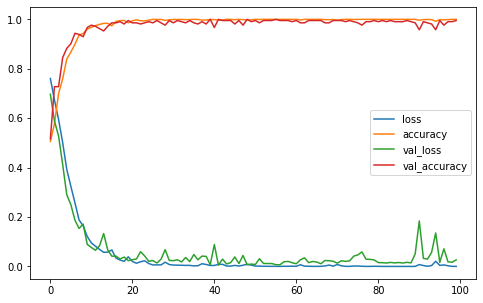

Results for fold 4
Epoch 1/100
30/30 [==============================] - 3s 70ms/step - loss: 0.7488 - accuracy: 0.5123 - val_loss: 0.6110 - val_accuracy: 0.6901
Epoch 2/100
30/30 [==============================] - 2s 59ms/step - loss: 0.6309 - accuracy: 0.6384 - val_loss: 0.5739 - val_accuracy: 0.6761
Epoch 3/100
30/30 [==============================] - 2s 59ms/step - loss: 0.5162 - accuracy: 0.7420 - val_loss: 0.4032 - val_accuracy: 0.8216
Epoch 4/100
30/30 [==============================] - 2s 59ms/step - loss: 0.4001 - accuracy: 0.8284 - val_loss: 0.3910 - val_accuracy: 0.8169
Epoch 5/100
30/30 [==============================] - 2s 59ms/step - loss: 0.3614 - accuracy: 0.8472 - val_loss: 0.2639 - val_accuracy: 0.8920
Epoch 6/100
30/30 [==============================] - 2s 59ms/step - loss: 0.2759 - accuracy: 0.8943 - val_loss: 0.2506 - val_accuracy: 0.8920
Epoch 7/100
30/30 [==============================] - 2s 59ms/step - loss: 0.2110 - accuracy: 0.9236 - val_loss: 0.1795 - val_accu

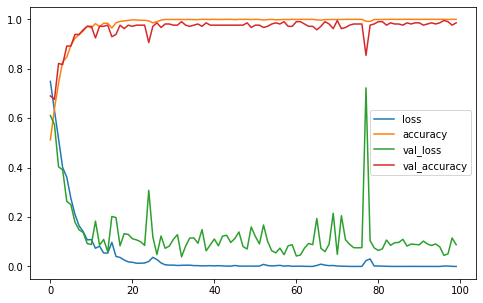

Results for fold 5
Epoch 1/100
30/30 [==============================] - 3s 69ms/step - loss: 0.7158 - accuracy: 0.5690 - val_loss: 0.5674 - val_accuracy: 0.7736
Epoch 2/100
30/30 [==============================] - 2s 59ms/step - loss: 0.6220 - accuracy: 0.6470 - val_loss: 0.4648 - val_accuracy: 0.7972
Epoch 3/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5613 - accuracy: 0.7123 - val_loss: 0.3638 - val_accuracy: 0.8821
Epoch 4/100
30/30 [==============================] - 2s 59ms/step - loss: 0.4142 - accuracy: 0.8180 - val_loss: 0.2882 - val_accuracy: 0.9009
Epoch 5/100
30/30 [==============================] - 2s 59ms/step - loss: 0.3419 - accuracy: 0.8583 - val_loss: 0.2224 - val_accuracy: 0.9340
Epoch 6/100
30/30 [==============================] - 2s 60ms/step - loss: 0.2644 - accuracy: 0.9012 - val_loss: 0.1853 - val_accuracy: 0.9292
Epoch 7/100
30/30 [==============================] - 2s 59ms/step - loss: 0.2179 - accuracy: 0.9137 - val_loss: 0.1406 - val_accu

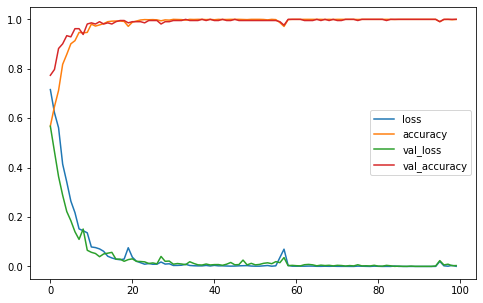

Results for fold 6
Epoch 1/100
30/30 [==============================] - 3s 71ms/step - loss: 0.7283 - accuracy: 0.5361 - val_loss: 0.6426 - val_accuracy: 0.6934
Epoch 2/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6361 - accuracy: 0.6318 - val_loss: 0.5705 - val_accuracy: 0.7783
Epoch 3/100
30/30 [==============================] - 2s 59ms/step - loss: 0.5778 - accuracy: 0.7014 - val_loss: 0.4698 - val_accuracy: 0.8160
Epoch 4/100
30/30 [==============================] - 2s 60ms/step - loss: 0.4850 - accuracy: 0.7683 - val_loss: 0.5689 - val_accuracy: 0.6745
Epoch 5/100
30/30 [==============================] - 2s 60ms/step - loss: 0.4073 - accuracy: 0.8149 - val_loss: 0.2685 - val_accuracy: 0.9292
Epoch 6/100
30/30 [==============================] - 2s 60ms/step - loss: 0.3159 - accuracy: 0.8734 - val_loss: 0.1762 - val_accuracy: 0.9575
Epoch 7/100
30/30 [==============================] - 2s 60ms/step - loss: 0.2776 - accuracy: 0.8923 - val_loss: 0.2413 - val_accu

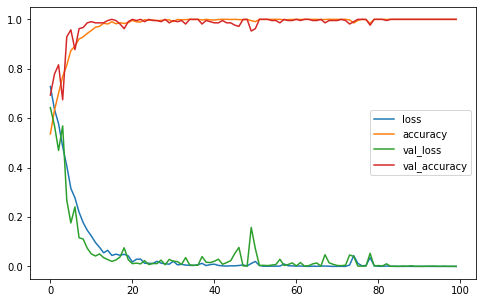

Results for fold 7
Epoch 1/100
30/30 [==============================] - 3s 71ms/step - loss: 0.6938 - accuracy: 0.5680 - val_loss: 0.5482 - val_accuracy: 0.7406
Epoch 2/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6093 - accuracy: 0.6653 - val_loss: 0.5235 - val_accuracy: 0.7736
Epoch 3/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5259 - accuracy: 0.7359 - val_loss: 0.3850 - val_accuracy: 0.8349
Epoch 4/100
30/30 [==============================] - 2s 60ms/step - loss: 0.4353 - accuracy: 0.7981 - val_loss: 0.2858 - val_accuracy: 0.9057
Epoch 5/100
30/30 [==============================] - 2s 60ms/step - loss: 0.3489 - accuracy: 0.8483 - val_loss: 0.2271 - val_accuracy: 0.9151
Epoch 6/100
30/30 [==============================] - 2s 60ms/step - loss: 0.2505 - accuracy: 0.8996 - val_loss: 0.1957 - val_accuracy: 0.9434
Epoch 7/100
30/30 [==============================] - 2s 60ms/step - loss: 0.2458 - accuracy: 0.9022 - val_loss: 0.1460 - val_accu

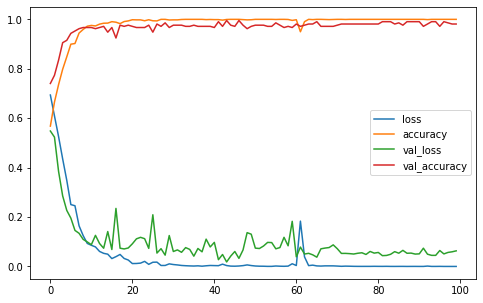

Results for fold 8
Epoch 1/100
30/30 [==============================] - 3s 71ms/step - loss: 0.7249 - accuracy: 0.5350 - val_loss: 0.6713 - val_accuracy: 0.6038
Epoch 2/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6822 - accuracy: 0.5722 - val_loss: 0.6806 - val_accuracy: 0.5236
Epoch 3/100
30/30 [==============================] - 2s 59ms/step - loss: 0.6264 - accuracy: 0.6506 - val_loss: 0.5216 - val_accuracy: 0.7925
Epoch 4/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5375 - accuracy: 0.7448 - val_loss: 0.6493 - val_accuracy: 0.6274
Epoch 5/100
30/30 [==============================] - 2s 60ms/step - loss: 0.4569 - accuracy: 0.7924 - val_loss: 0.3660 - val_accuracy: 0.8774
Epoch 6/100
30/30 [==============================] - 2s 60ms/step - loss: 0.4036 - accuracy: 0.8264 - val_loss: 0.2998 - val_accuracy: 0.9104
Epoch 7/100
30/30 [==============================] - 2s 60ms/step - loss: 0.3090 - accuracy: 0.8834 - val_loss: 0.2501 - val_accu

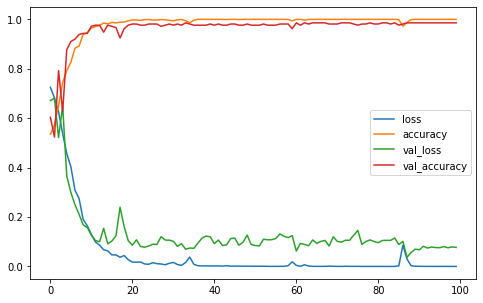

Results for fold 9
Epoch 1/100
30/30 [==============================] - 3s 71ms/step - loss: 0.6919 - accuracy: 0.5507 - val_loss: 0.6051 - val_accuracy: 0.7075
Epoch 2/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6250 - accuracy: 0.6433 - val_loss: 0.6386 - val_accuracy: 0.5943
Epoch 3/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5592 - accuracy: 0.7040 - val_loss: 0.5591 - val_accuracy: 0.6934
Epoch 4/100
30/30 [==============================] - 2s 61ms/step - loss: 0.4605 - accuracy: 0.7871 - val_loss: 0.3869 - val_accuracy: 0.8302
Epoch 5/100
30/30 [==============================] - 2s 60ms/step - loss: 0.3853 - accuracy: 0.8279 - val_loss: 0.3159 - val_accuracy: 0.8915
Epoch 6/100
30/30 [==============================] - 2s 61ms/step - loss: 0.3055 - accuracy: 0.8797 - val_loss: 0.2967 - val_accuracy: 0.8726
Epoch 7/100
30/30 [==============================] - 2s 61ms/step - loss: 0.2427 - accuracy: 0.9095 - val_loss: 0.2028 - val_accu

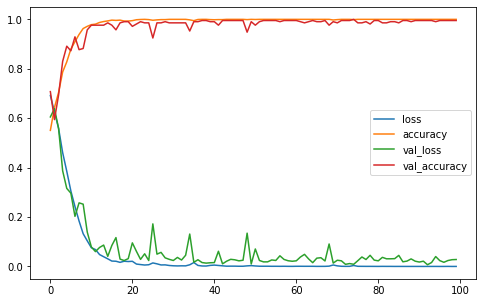

Results for fold 10
Epoch 1/100
30/30 [==============================] - 4s 73ms/step - loss: 0.6846 - accuracy: 0.5795 - val_loss: 0.6262 - val_accuracy: 0.6509
Epoch 2/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5774 - accuracy: 0.6951 - val_loss: 0.5717 - val_accuracy: 0.7028
Epoch 3/100
30/30 [==============================] - 2s 60ms/step - loss: 0.4660 - accuracy: 0.7945 - val_loss: 0.4764 - val_accuracy: 0.7877
Epoch 4/100
30/30 [==============================] - 2s 60ms/step - loss: 0.3850 - accuracy: 0.8462 - val_loss: 0.3520 - val_accuracy: 0.8208
Epoch 5/100
30/30 [==============================] - 2s 60ms/step - loss: 0.3092 - accuracy: 0.8776 - val_loss: 0.3364 - val_accuracy: 0.8349
Epoch 6/100
30/30 [==============================] - 2s 60ms/step - loss: 0.2425 - accuracy: 0.9153 - val_loss: 0.2325 - val_accuracy: 0.8962
Epoch 7/100
30/30 [==============================] - 2s 60ms/step - loss: 0.1730 - accuracy: 0.9430 - val_loss: 0.1747 - val_acc

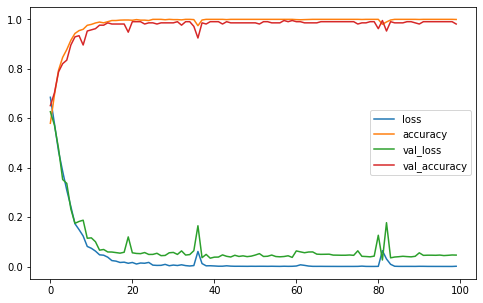

In [ ]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9877118468284607
F1_Score  : 0.9876930194239393


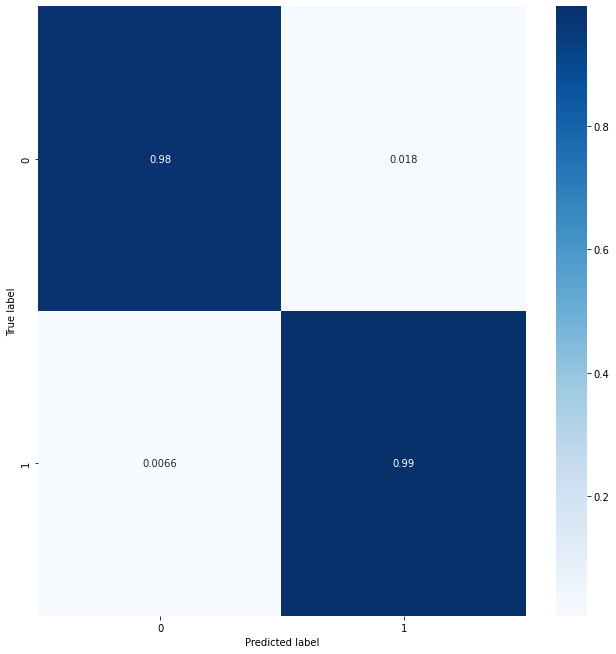

In [ ]:
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Subject 16**

In [ ]:
eeg_signal = []
valence = []
arousal = []
window_size = 256
no_channels = 32
no_new_channels = len(new_channels)
no_videos = 40
Trsld = 5

for person in range(16,17):
  print('Person No.' + str(person))
  
  
  # EEG files address
  if person < 10 :
    address = input_path+'s0'+str(person)+'.dat'
  else :
    address = input_path+'s'+str(person)+'.dat'

  with open(address, 'rb') as file:
    data = pkl.load(file, encoding = 'latin1')

  eeg = data['data']
  label = data['labels']
  
  # Assigning classes
  label[label<Trsld] = 0
  label[label>=Trsld] = 1

  val = label.T[0] # Valence label
  aro = label.T[1] # Arousal label

  del data, label
  # Iterating through 40 vidoes/trials
  for i in range(no_videos):
    sig = eeg[i][:no_channels, :]
    sig = baseline_remove(sig)
    temp = []
    for j in new_channels:
      temp.append(sig[j, :])
    sig = np.reshape(temp,[no_new_channels,-1])
    # Segmenting into 2 seconds (256 timesteps) windows without overlap
    start = 0
    while start + window_size <=sig.shape[1]:
      eeg_signal.append(sig[:, start:start+window_size])
      valence.append(val[i])
      arousal.append(aro[i])
      start += skip
  del eeg, val, aro, sig
eeg_signal = np.reshape(eeg_signal,[-1,no_new_channels,window_size,1])
data = np.asarray(eeg_signal, dtype = np.float32) # Using 32 bit floating point value to save memory
del eeg_signal
valence = np.asarray(valence, dtype = np.int8)
arousal = np.asarray(arousal, dtype = np.int8)

print(data.shape)
print(valence.shape, valence[valence == 0].shape, valence[valence == 1].shape)
print(arousal.shape, arousal[arousal == 0].shape, arousal[arousal == 1].shape)

valence = np_utils.to_categorical(valence)
arousal = np_utils.to_categorical(arousal)
gc.collect()

Person No.16
(2360, 36, 256, 1)
(2360,) (1475,) (885,)
(2360,) (1180,) (1180,)


3576

# **Valence**

In [ ]:
#valence
X_train, x_test, Y_train, y_test = train_test_split(data, valence, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(2124, 36, 256, 1) (236, 36, 256, 1) (2124, 2) (236, 2)


Results for fold 1
Epoch 1/100
30/30 [==============================] - 3s 69ms/step - loss: 0.6946 - accuracy: 0.5845 - val_loss: 0.4978 - val_accuracy: 0.7700
Epoch 2/100
30/30 [==============================] - 2s 58ms/step - loss: 0.5886 - accuracy: 0.6871 - val_loss: 0.4386 - val_accuracy: 0.8122
Epoch 3/100
30/30 [==============================] - 2s 58ms/step - loss: 0.5086 - accuracy: 0.7734 - val_loss: 0.3497 - val_accuracy: 0.8545
Epoch 4/100
30/30 [==============================] - 2s 58ms/step - loss: 0.4338 - accuracy: 0.8064 - val_loss: 0.3013 - val_accuracy: 0.8732
Epoch 5/100
30/30 [==============================] - 2s 58ms/step - loss: 0.3610 - accuracy: 0.8566 - val_loss: 0.2478 - val_accuracy: 0.9202
Epoch 6/100
30/30 [==============================] - 2s 58ms/step - loss: 0.2987 - accuracy: 0.8885 - val_loss: 0.1989 - val_accuracy: 0.9437
Epoch 7/100
30/30 [==============================] - 2s 58ms/step - loss: 0.2098 - accuracy: 0.9356 - val_loss: 0.1585 - val_accu

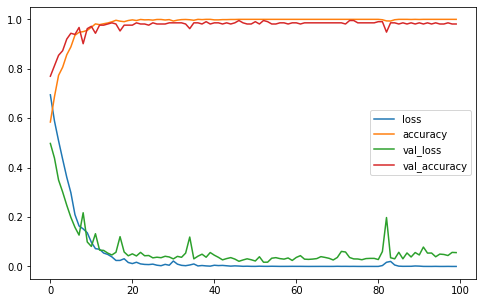

Results for fold 2
Epoch 1/100
30/30 [==============================] - 3s 70ms/step - loss: 0.7032 - accuracy: 0.5379 - val_loss: 0.6211 - val_accuracy: 0.7042
Epoch 2/100
30/30 [==============================] - 2s 58ms/step - loss: 0.6082 - accuracy: 0.6709 - val_loss: 0.5420 - val_accuracy: 0.7183
Epoch 3/100
30/30 [==============================] - 2s 58ms/step - loss: 0.5184 - accuracy: 0.7441 - val_loss: 0.4591 - val_accuracy: 0.7887
Epoch 4/100
30/30 [==============================] - 2s 58ms/step - loss: 0.4305 - accuracy: 0.8080 - val_loss: 0.3446 - val_accuracy: 0.8826
Epoch 5/100
30/30 [==============================] - 2s 58ms/step - loss: 0.3661 - accuracy: 0.8493 - val_loss: 0.2712 - val_accuracy: 0.9061
Epoch 6/100
30/30 [==============================] - 2s 58ms/step - loss: 0.2896 - accuracy: 0.8901 - val_loss: 0.2668 - val_accuracy: 0.8967
Epoch 7/100
30/30 [==============================] - 2s 58ms/step - loss: 0.2082 - accuracy: 0.9351 - val_loss: 0.2328 - val_accu

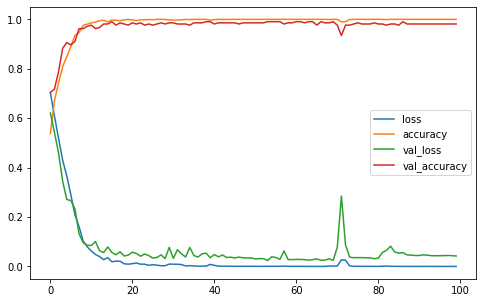

Results for fold 3
Epoch 1/100
30/30 [==============================] - 3s 70ms/step - loss: 0.6701 - accuracy: 0.5887 - val_loss: 0.5858 - val_accuracy: 0.6573
Epoch 2/100
30/30 [==============================] - 2s 59ms/step - loss: 0.5395 - accuracy: 0.7305 - val_loss: 0.4905 - val_accuracy: 0.7793
Epoch 3/100
30/30 [==============================] - 2s 59ms/step - loss: 0.4657 - accuracy: 0.7902 - val_loss: 0.3658 - val_accuracy: 0.8779
Epoch 4/100
30/30 [==============================] - 2s 59ms/step - loss: 0.3927 - accuracy: 0.8268 - val_loss: 0.3106 - val_accuracy: 0.9202
Epoch 5/100
30/30 [==============================] - 2s 59ms/step - loss: 0.2912 - accuracy: 0.8833 - val_loss: 0.2383 - val_accuracy: 0.9343
Epoch 6/100
30/30 [==============================] - 2s 59ms/step - loss: 0.2266 - accuracy: 0.9210 - val_loss: 0.2020 - val_accuracy: 0.9296
Epoch 7/100
30/30 [==============================] - 2s 59ms/step - loss: 0.1468 - accuracy: 0.9592 - val_loss: 0.1414 - val_accu

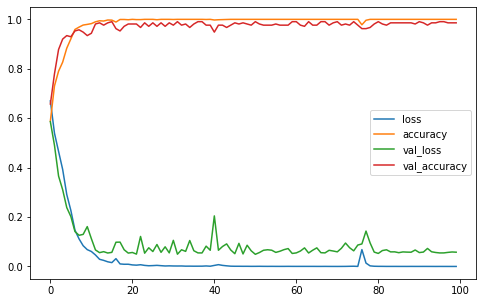

Results for fold 4
Epoch 1/100
30/30 [==============================] - 3s 71ms/step - loss: 0.7760 - accuracy: 0.5327 - val_loss: 0.6739 - val_accuracy: 0.5493
Epoch 2/100
30/30 [==============================] - 2s 59ms/step - loss: 0.6689 - accuracy: 0.5824 - val_loss: 0.6002 - val_accuracy: 0.7371
Epoch 3/100
30/30 [==============================] - 2s 59ms/step - loss: 0.6263 - accuracy: 0.6593 - val_loss: 0.5490 - val_accuracy: 0.7512
Epoch 4/100
30/30 [==============================] - 2s 59ms/step - loss: 0.5934 - accuracy: 0.6960 - val_loss: 0.4982 - val_accuracy: 0.7934
Epoch 5/100
30/30 [==============================] - 2s 59ms/step - loss: 0.5402 - accuracy: 0.7425 - val_loss: 0.4558 - val_accuracy: 0.8169
Epoch 6/100
30/30 [==============================] - 2s 59ms/step - loss: 0.4741 - accuracy: 0.7985 - val_loss: 0.4098 - val_accuracy: 0.8404
Epoch 7/100
30/30 [==============================] - 2s 60ms/step - loss: 0.4459 - accuracy: 0.8059 - val_loss: 0.3287 - val_accu

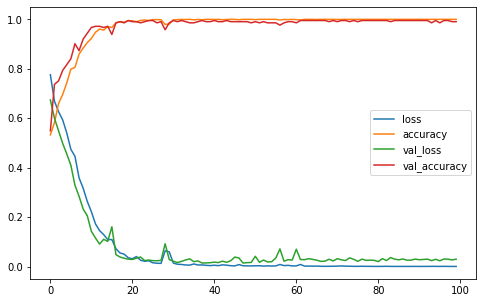

Results for fold 5
Epoch 1/100
30/30 [==============================] - 3s 71ms/step - loss: 0.7402 - accuracy: 0.5439 - val_loss: 0.5799 - val_accuracy: 0.6792
Epoch 2/100
30/30 [==============================] - 2s 59ms/step - loss: 0.6226 - accuracy: 0.6522 - val_loss: 0.5323 - val_accuracy: 0.7877
Epoch 3/100
30/30 [==============================] - 2s 59ms/step - loss: 0.5704 - accuracy: 0.7050 - val_loss: 0.5534 - val_accuracy: 0.7830
Epoch 4/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5165 - accuracy: 0.7500 - val_loss: 0.6936 - val_accuracy: 0.6462
Epoch 5/100
30/30 [==============================] - 2s 59ms/step - loss: 0.5172 - accuracy: 0.7495 - val_loss: 0.5139 - val_accuracy: 0.7783
Epoch 6/100
30/30 [==============================] - 2s 59ms/step - loss: 0.4075 - accuracy: 0.8217 - val_loss: 0.2999 - val_accuracy: 0.9057
Epoch 7/100
30/30 [==============================] - 2s 60ms/step - loss: 0.3357 - accuracy: 0.8729 - val_loss: 0.2427 - val_accu

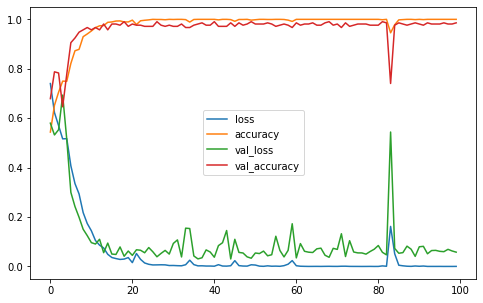

Results for fold 6
Epoch 1/100
30/30 [==============================] - 3s 71ms/step - loss: 0.7051 - accuracy: 0.5544 - val_loss: 0.6155 - val_accuracy: 0.6981
Epoch 2/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5989 - accuracy: 0.6878 - val_loss: 0.4899 - val_accuracy: 0.7736
Epoch 3/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5323 - accuracy: 0.7327 - val_loss: 0.3741 - val_accuracy: 0.8585
Epoch 4/100
30/30 [==============================] - 2s 60ms/step - loss: 0.4419 - accuracy: 0.7955 - val_loss: 0.3263 - val_accuracy: 0.9104
Epoch 5/100
30/30 [==============================] - 2s 60ms/step - loss: 0.3566 - accuracy: 0.8551 - val_loss: 0.2442 - val_accuracy: 0.8915
Epoch 6/100
30/30 [==============================] - 2s 60ms/step - loss: 0.2643 - accuracy: 0.9012 - val_loss: 0.1652 - val_accuracy: 0.9340
Epoch 7/100
30/30 [==============================] - 2s 60ms/step - loss: 0.1847 - accuracy: 0.9388 - val_loss: 0.1178 - val_accu

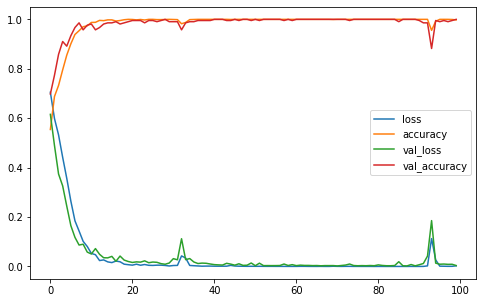

Results for fold 7
Epoch 1/100
30/30 [==============================] - 3s 71ms/step - loss: 0.6903 - accuracy: 0.5847 - val_loss: 0.6091 - val_accuracy: 0.6934
Epoch 2/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6011 - accuracy: 0.6684 - val_loss: 0.4999 - val_accuracy: 0.7783
Epoch 3/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5048 - accuracy: 0.7657 - val_loss: 0.4164 - val_accuracy: 0.8160
Epoch 4/100
30/30 [==============================] - 2s 59ms/step - loss: 0.4095 - accuracy: 0.8300 - val_loss: 0.2844 - val_accuracy: 0.9009
Epoch 5/100
30/30 [==============================] - 2s 60ms/step - loss: 0.3260 - accuracy: 0.8672 - val_loss: 0.2538 - val_accuracy: 0.9104
Epoch 6/100
30/30 [==============================] - 2s 61ms/step - loss: 0.2626 - accuracy: 0.9027 - val_loss: 0.2499 - val_accuracy: 0.8962
Epoch 7/100
30/30 [==============================] - 2s 60ms/step - loss: 0.2124 - accuracy: 0.9294 - val_loss: 0.1224 - val_accu

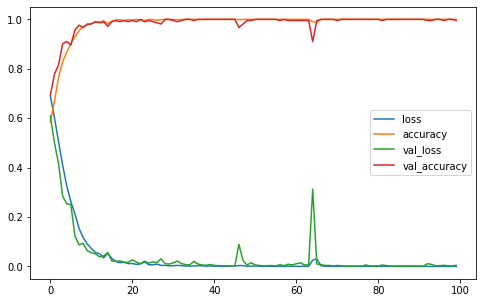

Results for fold 8
Epoch 1/100
30/30 [==============================] - 3s 71ms/step - loss: 0.6813 - accuracy: 0.5868 - val_loss: 0.6257 - val_accuracy: 0.7264
Epoch 2/100
30/30 [==============================] - 2s 59ms/step - loss: 0.5727 - accuracy: 0.7082 - val_loss: 0.4831 - val_accuracy: 0.7783
Epoch 3/100
30/30 [==============================] - 2s 60ms/step - loss: 0.4988 - accuracy: 0.7751 - val_loss: 0.4667 - val_accuracy: 0.7783
Epoch 4/100
30/30 [==============================] - 2s 59ms/step - loss: 0.4744 - accuracy: 0.7772 - val_loss: 0.4064 - val_accuracy: 0.8019
Epoch 5/100
30/30 [==============================] - 2s 60ms/step - loss: 0.3564 - accuracy: 0.8598 - val_loss: 0.2899 - val_accuracy: 0.8679
Epoch 6/100
30/30 [==============================] - 2s 60ms/step - loss: 0.2731 - accuracy: 0.8891 - val_loss: 0.2083 - val_accuracy: 0.9151
Epoch 7/100
30/30 [==============================] - 2s 60ms/step - loss: 0.1991 - accuracy: 0.9289 - val_loss: 0.1513 - val_accu

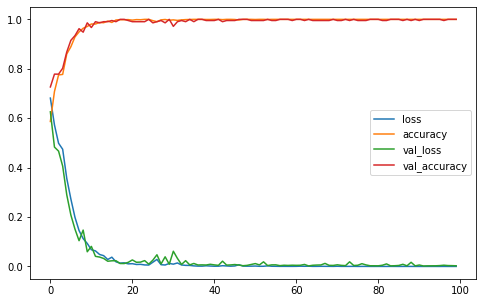

Results for fold 9
Epoch 1/100
30/30 [==============================] - 3s 70ms/step - loss: 0.6894 - accuracy: 0.5638 - val_loss: 0.5977 - val_accuracy: 0.6745
Epoch 2/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6107 - accuracy: 0.6768 - val_loss: 0.5431 - val_accuracy: 0.7500
Epoch 3/100
30/30 [==============================] - 2s 61ms/step - loss: 0.5367 - accuracy: 0.7469 - val_loss: 0.4976 - val_accuracy: 0.8160
Epoch 4/100
30/30 [==============================] - 2s 61ms/step - loss: 0.5031 - accuracy: 0.7594 - val_loss: 0.4995 - val_accuracy: 0.7170
Epoch 5/100
30/30 [==============================] - 2s 60ms/step - loss: 0.4624 - accuracy: 0.7986 - val_loss: 0.4213 - val_accuracy: 0.8302
Epoch 6/100
30/30 [==============================] - 2s 60ms/step - loss: 0.3834 - accuracy: 0.8389 - val_loss: 0.3552 - val_accuracy: 0.8679
Epoch 7/100
30/30 [==============================] - 2s 60ms/step - loss: 0.3525 - accuracy: 0.8525 - val_loss: 0.3054 - val_accu

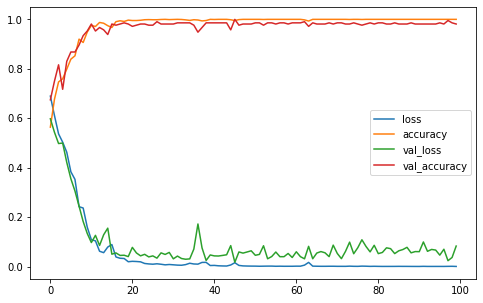

Results for fold 10
Epoch 1/100
30/30 [==============================] - 3s 72ms/step - loss: 0.6922 - accuracy: 0.5863 - val_loss: 0.5907 - val_accuracy: 0.6934
Epoch 2/100
30/30 [==============================] - 2s 61ms/step - loss: 0.6316 - accuracy: 0.6752 - val_loss: 0.5927 - val_accuracy: 0.6745
Epoch 3/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5689 - accuracy: 0.7160 - val_loss: 0.5719 - val_accuracy: 0.6981
Epoch 4/100
30/30 [==============================] - 2s 61ms/step - loss: 0.5325 - accuracy: 0.7537 - val_loss: 0.5045 - val_accuracy: 0.7594
Epoch 5/100
30/30 [==============================] - 2s 61ms/step - loss: 0.4881 - accuracy: 0.7746 - val_loss: 0.4518 - val_accuracy: 0.8443
Epoch 6/100
30/30 [==============================] - 2s 60ms/step - loss: 0.4069 - accuracy: 0.8316 - val_loss: 0.3612 - val_accuracy: 0.8679
Epoch 7/100
30/30 [==============================] - 2s 61ms/step - loss: 0.3329 - accuracy: 0.8719 - val_loss: 0.2974 - val_acc

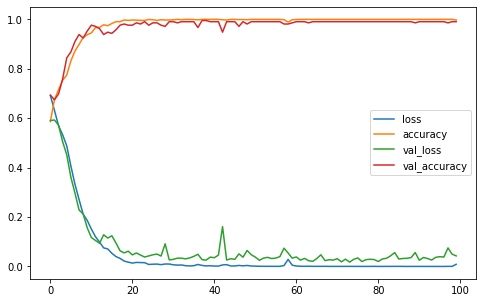

In [ ]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9902542233467102
F1_Score  : 0.9898355352365721


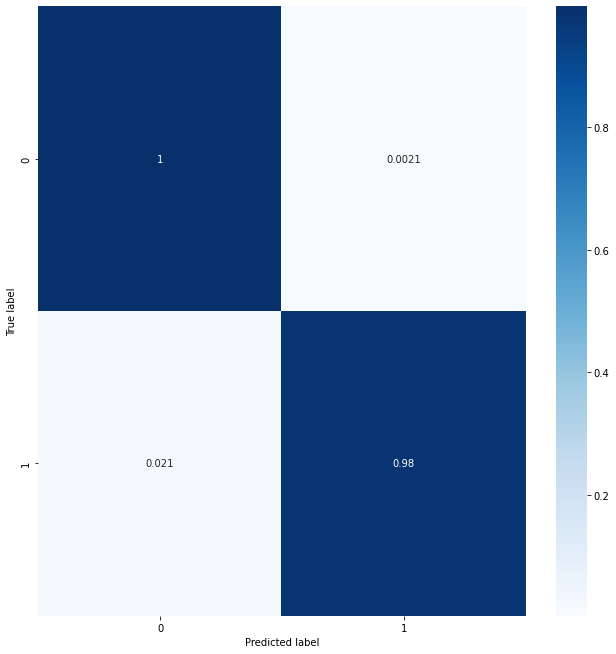

In [ ]:
#50 epochs
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Arousal**

In [ ]:
#arousal
X_train, x_test, Y_train, y_test = train_test_split(data,arousal, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(2124, 36, 256, 1) (236, 36, 256, 1) (2124, 2) (236, 2)


Results for fold 1
Epoch 1/100
30/30 [==============================] - 3s 69ms/step - loss: 0.6638 - accuracy: 0.6002 - val_loss: 0.5592 - val_accuracy: 0.7277
Epoch 2/100
30/30 [==============================] - 2s 58ms/step - loss: 0.5878 - accuracy: 0.6803 - val_loss: 0.4865 - val_accuracy: 0.7559
Epoch 3/100
30/30 [==============================] - 2s 58ms/step - loss: 0.4881 - accuracy: 0.7718 - val_loss: 0.4061 - val_accuracy: 0.8451
Epoch 4/100
30/30 [==============================] - 2s 59ms/step - loss: 0.4352 - accuracy: 0.8053 - val_loss: 0.3563 - val_accuracy: 0.8685
Epoch 5/100
30/30 [==============================] - 2s 59ms/step - loss: 0.3535 - accuracy: 0.8582 - val_loss: 0.3024 - val_accuracy: 0.8685
Epoch 6/100
30/30 [==============================] - 2s 58ms/step - loss: 0.2648 - accuracy: 0.9016 - val_loss: 0.3219 - val_accuracy: 0.8826
Epoch 7/100
30/30 [==============================] - 2s 58ms/step - loss: 0.2111 - accuracy: 0.9236 - val_loss: 0.2032 - val_accu

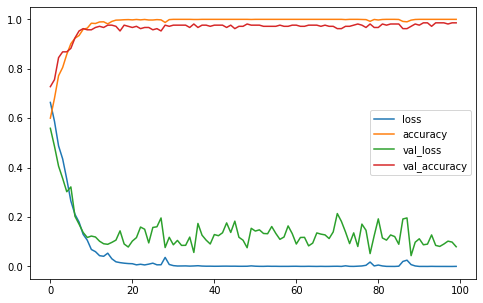

Results for fold 2
Epoch 1/100
30/30 [==============================] - 3s 69ms/step - loss: 0.7189 - accuracy: 0.5463 - val_loss: 0.6269 - val_accuracy: 0.7042
Epoch 2/100
30/30 [==============================] - 2s 58ms/step - loss: 0.6200 - accuracy: 0.6651 - val_loss: 0.5445 - val_accuracy: 0.7606
Epoch 3/100
30/30 [==============================] - 2s 58ms/step - loss: 0.5609 - accuracy: 0.7211 - val_loss: 0.4716 - val_accuracy: 0.8404
Epoch 4/100
30/30 [==============================] - 2s 58ms/step - loss: 0.4666 - accuracy: 0.8017 - val_loss: 0.3794 - val_accuracy: 0.8685
Epoch 5/100
30/30 [==============================] - 2s 58ms/step - loss: 0.4016 - accuracy: 0.8189 - val_loss: 0.4206 - val_accuracy: 0.7887
Epoch 6/100
30/30 [==============================] - 2s 58ms/step - loss: 0.3828 - accuracy: 0.8226 - val_loss: 0.3718 - val_accuracy: 0.8169
Epoch 7/100
30/30 [==============================] - 2s 58ms/step - loss: 0.2802 - accuracy: 0.8932 - val_loss: 0.2301 - val_accu

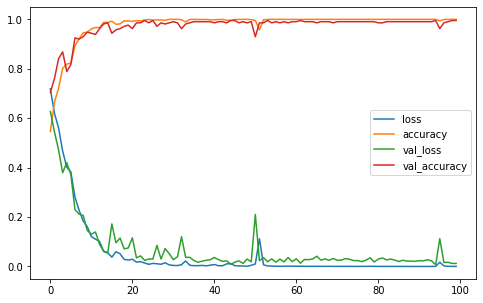

Results for fold 3
Epoch 1/100
30/30 [==============================] - 3s 68ms/step - loss: 0.6422 - accuracy: 0.6353 - val_loss: 0.4927 - val_accuracy: 0.8263
Epoch 2/100
30/30 [==============================] - 2s 58ms/step - loss: 0.4874 - accuracy: 0.7703 - val_loss: 0.4029 - val_accuracy: 0.8451
Epoch 3/100
30/30 [==============================] - 2s 59ms/step - loss: 0.3856 - accuracy: 0.8299 - val_loss: 0.2998 - val_accuracy: 0.8873
Epoch 4/100
30/30 [==============================] - 2s 58ms/step - loss: 0.2876 - accuracy: 0.9006 - val_loss: 0.2262 - val_accuracy: 0.9296
Epoch 5/100
30/30 [==============================] - 2s 59ms/step - loss: 0.2300 - accuracy: 0.9257 - val_loss: 0.2455 - val_accuracy: 0.9155
Epoch 6/100
30/30 [==============================] - 2s 59ms/step - loss: 0.1730 - accuracy: 0.9435 - val_loss: 0.1507 - val_accuracy: 0.9484
Epoch 7/100
30/30 [==============================] - 2s 59ms/step - loss: 0.1402 - accuracy: 0.9566 - val_loss: 0.1144 - val_accu

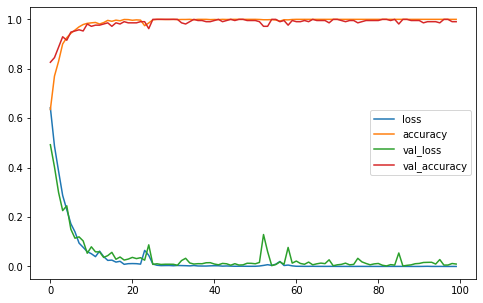

Results for fold 4
Epoch 1/100
30/30 [==============================] - 3s 70ms/step - loss: 0.6952 - accuracy: 0.5777 - val_loss: 0.5941 - val_accuracy: 0.7042
Epoch 2/100
30/30 [==============================] - 2s 59ms/step - loss: 0.5920 - accuracy: 0.6766 - val_loss: 0.5398 - val_accuracy: 0.7136
Epoch 3/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5021 - accuracy: 0.7577 - val_loss: 0.3975 - val_accuracy: 0.8826
Epoch 4/100
30/30 [==============================] - 2s 59ms/step - loss: 0.4091 - accuracy: 0.8237 - val_loss: 0.3541 - val_accuracy: 0.8216
Epoch 5/100
30/30 [==============================] - 2s 59ms/step - loss: 0.3308 - accuracy: 0.8645 - val_loss: 0.2486 - val_accuracy: 0.9484
Epoch 6/100
30/30 [==============================] - 2s 59ms/step - loss: 0.2941 - accuracy: 0.8849 - val_loss: 0.2110 - val_accuracy: 0.9390
Epoch 7/100
30/30 [==============================] - 2s 60ms/step - loss: 0.2184 - accuracy: 0.9273 - val_loss: 0.2003 - val_accu

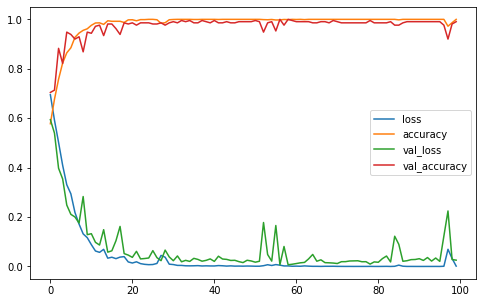

Results for fold 5
Epoch 1/100
30/30 [==============================] - 3s 70ms/step - loss: 0.6954 - accuracy: 0.5685 - val_loss: 0.6181 - val_accuracy: 0.7406
Epoch 2/100
30/30 [==============================] - 2s 59ms/step - loss: 0.6018 - accuracy: 0.6804 - val_loss: 0.5257 - val_accuracy: 0.7642
Epoch 3/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5253 - accuracy: 0.7537 - val_loss: 0.4699 - val_accuracy: 0.7972
Epoch 4/100
30/30 [==============================] - 2s 60ms/step - loss: 0.4336 - accuracy: 0.8117 - val_loss: 0.3323 - val_accuracy: 0.8726
Epoch 5/100
30/30 [==============================] - 2s 60ms/step - loss: 0.3144 - accuracy: 0.8855 - val_loss: 0.2688 - val_accuracy: 0.8868
Epoch 6/100
30/30 [==============================] - 2s 60ms/step - loss: 0.2363 - accuracy: 0.9263 - val_loss: 0.1713 - val_accuracy: 0.9528
Epoch 7/100
30/30 [==============================] - 2s 59ms/step - loss: 0.1959 - accuracy: 0.9367 - val_loss: 0.1411 - val_accu

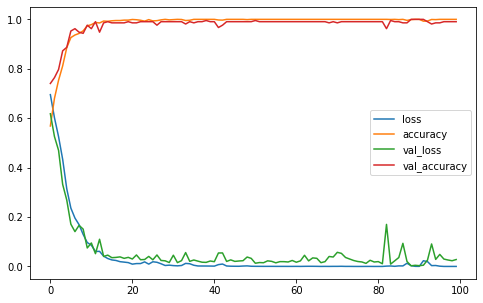

Results for fold 6
Epoch 1/100
30/30 [==============================] - 3s 70ms/step - loss: 0.6741 - accuracy: 0.5858 - val_loss: 0.5822 - val_accuracy: 0.7500
Epoch 2/100
30/30 [==============================] - 2s 59ms/step - loss: 0.5959 - accuracy: 0.6851 - val_loss: 0.5056 - val_accuracy: 0.7123
Epoch 3/100
30/30 [==============================] - 2s 59ms/step - loss: 0.5094 - accuracy: 0.7605 - val_loss: 0.3695 - val_accuracy: 0.8962
Epoch 4/100
30/30 [==============================] - 2s 59ms/step - loss: 0.4103 - accuracy: 0.8384 - val_loss: 0.3159 - val_accuracy: 0.9009
Epoch 5/100
30/30 [==============================] - 2s 60ms/step - loss: 0.3354 - accuracy: 0.8828 - val_loss: 0.2265 - val_accuracy: 0.9198
Epoch 6/100
30/30 [==============================] - 2s 60ms/step - loss: 0.2710 - accuracy: 0.9027 - val_loss: 0.1797 - val_accuracy: 0.9434
Epoch 7/100
30/30 [==============================] - 2s 59ms/step - loss: 0.2372 - accuracy: 0.9168 - val_loss: 0.1392 - val_accu

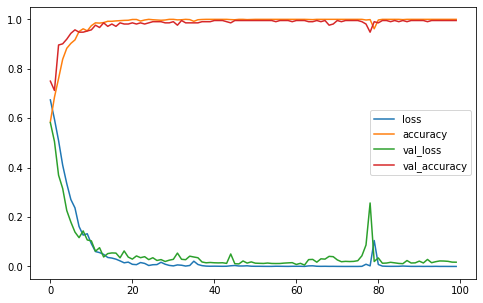

Results for fold 7
Epoch 1/100
30/30 [==============================] - 3s 69ms/step - loss: 0.6666 - accuracy: 0.6015 - val_loss: 0.5775 - val_accuracy: 0.6887
Epoch 2/100
30/30 [==============================] - 2s 59ms/step - loss: 0.5617 - accuracy: 0.7191 - val_loss: 0.4903 - val_accuracy: 0.7736
Epoch 3/100
30/30 [==============================] - 2s 60ms/step - loss: 0.4743 - accuracy: 0.7824 - val_loss: 0.4045 - val_accuracy: 0.8679
Epoch 4/100
30/30 [==============================] - 2s 60ms/step - loss: 0.3889 - accuracy: 0.8379 - val_loss: 0.2971 - val_accuracy: 0.9104
Epoch 5/100
30/30 [==============================] - 2s 60ms/step - loss: 0.2992 - accuracy: 0.8876 - val_loss: 0.2005 - val_accuracy: 0.9387
Epoch 6/100
30/30 [==============================] - 2s 60ms/step - loss: 0.2306 - accuracy: 0.9200 - val_loss: 0.1501 - val_accuracy: 0.9575
Epoch 7/100
30/30 [==============================] - 2s 60ms/step - loss: 0.1894 - accuracy: 0.9310 - val_loss: 0.1587 - val_accu

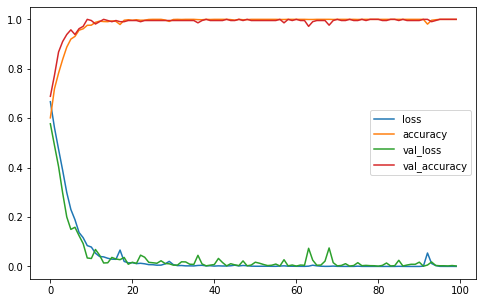

Results for fold 8
Epoch 1/100
30/30 [==============================] - 3s 71ms/step - loss: 0.6782 - accuracy: 0.5758 - val_loss: 0.6127 - val_accuracy: 0.7028
Epoch 2/100
30/30 [==============================] - 2s 59ms/step - loss: 0.5700 - accuracy: 0.7003 - val_loss: 0.5332 - val_accuracy: 0.7689
Epoch 3/100
30/30 [==============================] - 2s 60ms/step - loss: 0.4930 - accuracy: 0.7709 - val_loss: 0.4986 - val_accuracy: 0.7500
Epoch 4/100
30/30 [==============================] - 2s 60ms/step - loss: 0.4008 - accuracy: 0.8290 - val_loss: 0.3900 - val_accuracy: 0.7972
Epoch 5/100
30/30 [==============================] - 2s 61ms/step - loss: 0.3086 - accuracy: 0.8844 - val_loss: 0.2550 - val_accuracy: 0.8962
Epoch 6/100
30/30 [==============================] - 2s 60ms/step - loss: 0.2250 - accuracy: 0.9268 - val_loss: 0.2149 - val_accuracy: 0.9340
Epoch 7/100
30/30 [==============================] - 2s 60ms/step - loss: 0.1902 - accuracy: 0.9372 - val_loss: 0.1897 - val_accu

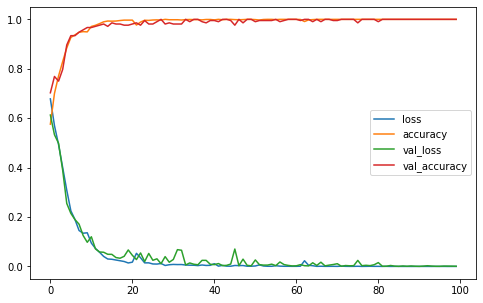

Results for fold 9
Epoch 1/100
30/30 [==============================] - 3s 71ms/step - loss: 0.6926 - accuracy: 0.5821 - val_loss: 0.6015 - val_accuracy: 0.7594
Epoch 2/100
30/30 [==============================] - 2s 59ms/step - loss: 0.6020 - accuracy: 0.6747 - val_loss: 0.5097 - val_accuracy: 0.7830
Epoch 3/100
30/30 [==============================] - 2s 61ms/step - loss: 0.5138 - accuracy: 0.7610 - val_loss: 0.4309 - val_accuracy: 0.8349
Epoch 4/100
30/30 [==============================] - 2s 61ms/step - loss: 0.4133 - accuracy: 0.8279 - val_loss: 0.3888 - val_accuracy: 0.8349
Epoch 5/100
30/30 [==============================] - 2s 60ms/step - loss: 0.3700 - accuracy: 0.8410 - val_loss: 0.2363 - val_accuracy: 0.9292
Epoch 6/100
30/30 [==============================] - 2s 60ms/step - loss: 0.2561 - accuracy: 0.9069 - val_loss: 0.1534 - val_accuracy: 0.9575
Epoch 7/100
30/30 [==============================] - 2s 60ms/step - loss: 0.2187 - accuracy: 0.9205 - val_loss: 0.1173 - val_accu

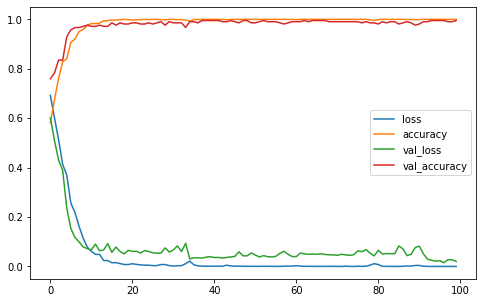

Results for fold 10
Epoch 1/100
30/30 [==============================] - 3s 70ms/step - loss: 0.6737 - accuracy: 0.5978 - val_loss: 0.5545 - val_accuracy: 0.7500
Epoch 2/100
30/30 [==============================] - 2s 59ms/step - loss: 0.5980 - accuracy: 0.6789 - val_loss: 0.5155 - val_accuracy: 0.8019
Epoch 3/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5332 - accuracy: 0.7181 - val_loss: 0.4564 - val_accuracy: 0.7830
Epoch 4/100
30/30 [==============================] - 2s 60ms/step - loss: 0.4554 - accuracy: 0.8002 - val_loss: 0.3761 - val_accuracy: 0.8302
Epoch 5/100
30/30 [==============================] - 2s 60ms/step - loss: 0.4028 - accuracy: 0.8201 - val_loss: 0.2997 - val_accuracy: 0.8962
Epoch 6/100
30/30 [==============================] - 2s 60ms/step - loss: 0.3100 - accuracy: 0.8849 - val_loss: 0.2318 - val_accuracy: 0.9151
Epoch 7/100
30/30 [==============================] - 2s 60ms/step - loss: 0.2536 - accuracy: 0.9079 - val_loss: 0.1643 - val_acc

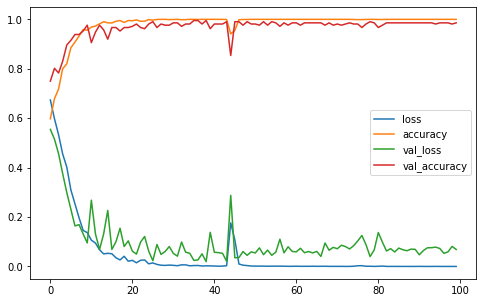

In [ ]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.994915246963501
F1_Score  : 0.9948967128169327


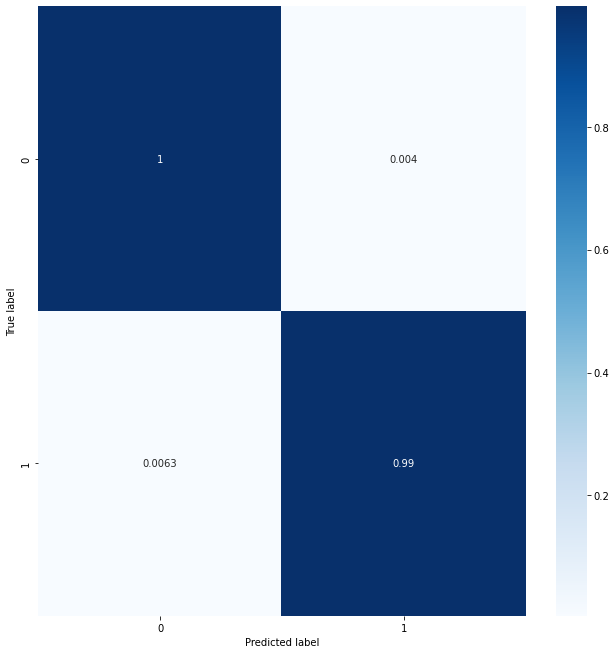

In [ ]:
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Subject 17**

In [ ]:
eeg_signal = []
valence = []
arousal = []
window_size = 256
no_channels = 32
no_new_channels = len(new_channels)
no_videos = 40
Trsld = 5

for person in range(17,18):
  print('Person No.' + str(person))
  
  
  # EEG files address
  if person < 10 :
    address = input_path+'s0'+str(person)+'.dat'
  else :
    address = input_path+'s'+str(person)+'.dat'

  with open(address, 'rb') as file:
    data = pkl.load(file, encoding = 'latin1')

  eeg = data['data']
  label = data['labels']
  
  # Assigning classes
  label[label<Trsld] = 0
  label[label>=Trsld] = 1

  val = label.T[0] # Valence label
  aro = label.T[1] # Arousal label

  del data, label
  # Iterating through 40 vidoes/trials
  for i in range(no_videos):
    sig = eeg[i][:no_channels, :]
    sig = baseline_remove(sig)
    temp = []
    for j in new_channels:
      temp.append(sig[j, :])
    sig = np.reshape(temp,[no_new_channels,-1])
    # Segmenting into 2 seconds (256 timesteps) windows without overlap
    start = 0
    while start + window_size <=sig.shape[1]:
      eeg_signal.append(sig[:, start:start+window_size])
      valence.append(val[i])
      arousal.append(aro[i])
      start += skip
  del eeg, val, aro, sig
eeg_signal = np.reshape(eeg_signal,[-1,no_new_channels,window_size,1])
data = np.asarray(eeg_signal, dtype = np.float32) # Using 32 bit floating point value to save memory
del eeg_signal
valence = np.asarray(valence, dtype = np.int8)
arousal = np.asarray(arousal, dtype = np.int8)

print(data.shape)
print(valence.shape, valence[valence == 0].shape, valence[valence == 1].shape)
print(arousal.shape, arousal[arousal == 0].shape, arousal[arousal == 1].shape)

valence = np_utils.to_categorical(valence)
arousal = np_utils.to_categorical(arousal)
gc.collect()

Person No.17
(2360, 36, 256, 1)
(2360,) (1062,) (1298,)
(2360,) (885,) (1475,)


0

# **Valence**

In [ ]:
#valence
X_train, x_test, Y_train, y_test = train_test_split(data, valence, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(2124, 36, 256, 1) (236, 36, 256, 1) (2124, 2) (236, 2)


Results for fold 1
Epoch 1/100
30/30 [==============================] - 17s 100ms/step - loss: 0.7118 - accuracy: 0.5196 - val_loss: 0.7544 - val_accuracy: 0.3615
Epoch 2/100
30/30 [==============================] - 2s 58ms/step - loss: 0.6892 - accuracy: 0.5327 - val_loss: 0.6641 - val_accuracy: 0.6338
Epoch 3/100
30/30 [==============================] - 2s 57ms/step - loss: 0.6755 - accuracy: 0.5683 - val_loss: 0.7777 - val_accuracy: 0.3803
Epoch 4/100
30/30 [==============================] - 2s 57ms/step - loss: 0.6443 - accuracy: 0.6201 - val_loss: 0.6914 - val_accuracy: 0.5446
Epoch 5/100
30/30 [==============================] - 2s 58ms/step - loss: 0.5743 - accuracy: 0.7028 - val_loss: 0.7155 - val_accuracy: 0.5352
Epoch 6/100
30/30 [==============================] - 2s 58ms/step - loss: 0.5137 - accuracy: 0.7368 - val_loss: 0.7985 - val_accuracy: 0.5305
Epoch 7/100
30/30 [==============================] - 2s 58ms/step - loss: 0.4545 - accuracy: 0.7933 - val_loss: 0.4751 - val_ac

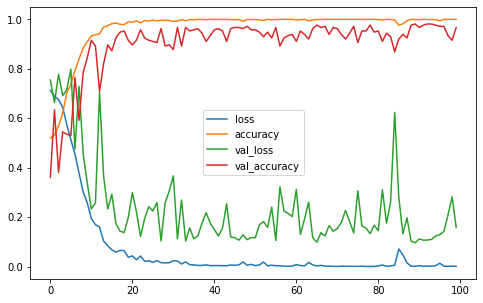

Results for fold 2
Epoch 1/100
30/30 [==============================] - 4s 72ms/step - loss: 0.7177 - accuracy: 0.5243 - val_loss: 0.7382 - val_accuracy: 0.4225
Epoch 2/100
30/30 [==============================] - 2s 59ms/step - loss: 0.7070 - accuracy: 0.4966 - val_loss: 0.7113 - val_accuracy: 0.4366
Epoch 3/100
30/30 [==============================] - 2s 59ms/step - loss: 0.7033 - accuracy: 0.5102 - val_loss: 0.6947 - val_accuracy: 0.4883
Epoch 4/100
30/30 [==============================] - 2s 58ms/step - loss: 0.6916 - accuracy: 0.5259 - val_loss: 0.6873 - val_accuracy: 0.5822
Epoch 5/100
30/30 [==============================] - 2s 60ms/step - loss: 0.7003 - accuracy: 0.4997 - val_loss: 0.6948 - val_accuracy: 0.4507
Epoch 6/100
30/30 [==============================] - 2s 61ms/step - loss: 0.6949 - accuracy: 0.5113 - val_loss: 0.7028 - val_accuracy: 0.4178
Epoch 7/100
30/30 [==============================] - 2s 61ms/step - loss: 0.6892 - accuracy: 0.5196 - val_loss: 0.6916 - val_accu

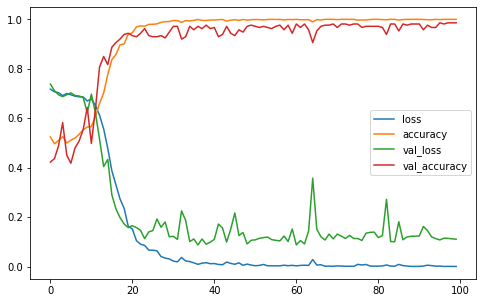

Results for fold 3
Epoch 1/100
30/30 [==============================] - 3s 70ms/step - loss: 0.7280 - accuracy: 0.5238 - val_loss: 0.7323 - val_accuracy: 0.5023
Epoch 2/100
30/30 [==============================] - 2s 58ms/step - loss: 0.7013 - accuracy: 0.5411 - val_loss: 0.6764 - val_accuracy: 0.5728
Epoch 3/100
30/30 [==============================] - 2s 59ms/step - loss: 0.6950 - accuracy: 0.5447 - val_loss: 0.6639 - val_accuracy: 0.6150
Epoch 4/100
30/30 [==============================] - 2s 59ms/step - loss: 0.6745 - accuracy: 0.5730 - val_loss: 0.6623 - val_accuracy: 0.6150
Epoch 5/100
30/30 [==============================] - 2s 59ms/step - loss: 0.6505 - accuracy: 0.6217 - val_loss: 0.6343 - val_accuracy: 0.6526
Epoch 6/100
30/30 [==============================] - 2s 59ms/step - loss: 0.6259 - accuracy: 0.6641 - val_loss: 0.6157 - val_accuracy: 0.6620
Epoch 7/100
30/30 [==============================] - 2s 60ms/step - loss: 0.5970 - accuracy: 0.6824 - val_loss: 0.6065 - val_accu

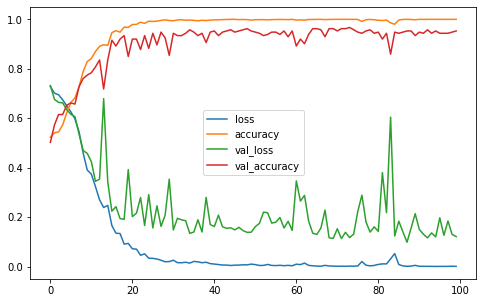

Results for fold 4
Epoch 1/100
30/30 [==============================] - 3s 71ms/step - loss: 0.7483 - accuracy: 0.5029 - val_loss: 0.6885 - val_accuracy: 0.5587
Epoch 2/100
30/30 [==============================] - 2s 59ms/step - loss: 0.7173 - accuracy: 0.5092 - val_loss: 0.7036 - val_accuracy: 0.4460
Epoch 3/100
30/30 [==============================] - 2s 59ms/step - loss: 0.7166 - accuracy: 0.4956 - val_loss: 0.6910 - val_accuracy: 0.4930
Epoch 4/100
30/30 [==============================] - 2s 60ms/step - loss: 0.7080 - accuracy: 0.5133 - val_loss: 0.6848 - val_accuracy: 0.5822
Epoch 5/100
30/30 [==============================] - 2s 60ms/step - loss: 0.7063 - accuracy: 0.5217 - val_loss: 0.6943 - val_accuracy: 0.4460
Epoch 6/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6980 - accuracy: 0.5243 - val_loss: 0.6859 - val_accuracy: 0.4930
Epoch 7/100
30/30 [==============================] - 2s 60ms/step - loss: 0.7085 - accuracy: 0.4987 - val_loss: 0.6835 - val_accu

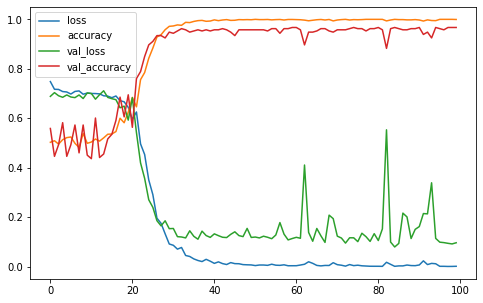

Results for fold 5
Epoch 1/100
30/30 [==============================] - 4s 105ms/step - loss: 0.7091 - accuracy: 0.4984 - val_loss: 0.7202 - val_accuracy: 0.4292
Epoch 2/100
30/30 [==============================] - 2s 59ms/step - loss: 0.7060 - accuracy: 0.5073 - val_loss: 0.7004 - val_accuracy: 0.4481
Epoch 3/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6974 - accuracy: 0.5026 - val_loss: 0.6958 - val_accuracy: 0.4528
Epoch 4/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6918 - accuracy: 0.5272 - val_loss: 0.6912 - val_accuracy: 0.5142
Epoch 5/100
30/30 [==============================] - 2s 64ms/step - loss: 0.6956 - accuracy: 0.5136 - val_loss: 0.6863 - val_accuracy: 0.5755
Epoch 6/100
30/30 [==============================] - 2s 63ms/step - loss: 0.6900 - accuracy: 0.5403 - val_loss: 0.7116 - val_accuracy: 0.4575
Epoch 7/100
30/30 [==============================] - 2s 63ms/step - loss: 0.6883 - accuracy: 0.5309 - val_loss: 0.6806 - val_acc

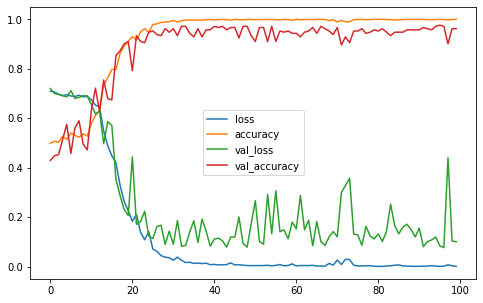

Results for fold 6
Epoch 1/100
30/30 [==============================] - 4s 75ms/step - loss: 0.7430 - accuracy: 0.5037 - val_loss: 0.6926 - val_accuracy: 0.5094
Epoch 2/100
30/30 [==============================] - 2s 62ms/step - loss: 0.7249 - accuracy: 0.5131 - val_loss: 0.6893 - val_accuracy: 0.5094
Epoch 3/100
30/30 [==============================] - 2s 63ms/step - loss: 0.7252 - accuracy: 0.4660 - val_loss: 0.6818 - val_accuracy: 0.5566
Epoch 4/100
30/30 [==============================] - 2s 63ms/step - loss: 0.6885 - accuracy: 0.5481 - val_loss: 0.6922 - val_accuracy: 0.5283
Epoch 5/100
30/30 [==============================] - 2s 62ms/step - loss: 0.7087 - accuracy: 0.5063 - val_loss: 0.6997 - val_accuracy: 0.5283
Epoch 6/100
30/30 [==============================] - 2s 61ms/step - loss: 0.7000 - accuracy: 0.4990 - val_loss: 0.6867 - val_accuracy: 0.5613
Epoch 7/100
30/30 [==============================] - 2s 61ms/step - loss: 0.6851 - accuracy: 0.5403 - val_loss: 0.6713 - val_accu

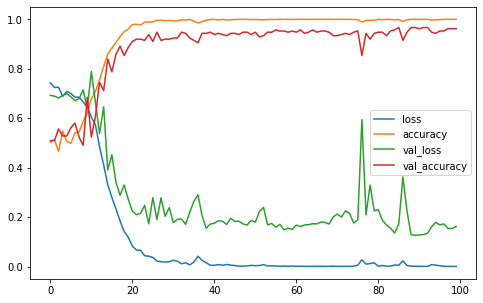

Results for fold 7
Epoch 1/100
30/30 [==============================] - 4s 71ms/step - loss: 0.7337 - accuracy: 0.4916 - val_loss: 0.6919 - val_accuracy: 0.4717
Epoch 2/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6991 - accuracy: 0.5031 - val_loss: 0.6916 - val_accuracy: 0.5142
Epoch 3/100
30/30 [==============================] - 2s 60ms/step - loss: 0.7043 - accuracy: 0.4995 - val_loss: 0.6947 - val_accuracy: 0.5094
Epoch 4/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6984 - accuracy: 0.4969 - val_loss: 0.6883 - val_accuracy: 0.5708
Epoch 5/100
30/30 [==============================] - 2s 61ms/step - loss: 0.6939 - accuracy: 0.5052 - val_loss: 0.6853 - val_accuracy: 0.5189
Epoch 6/100
30/30 [==============================] - 2s 61ms/step - loss: 0.6895 - accuracy: 0.5481 - val_loss: 0.6815 - val_accuracy: 0.5755
Epoch 7/100
30/30 [==============================] - 2s 62ms/step - loss: 0.6878 - accuracy: 0.5565 - val_loss: 0.6811 - val_accu

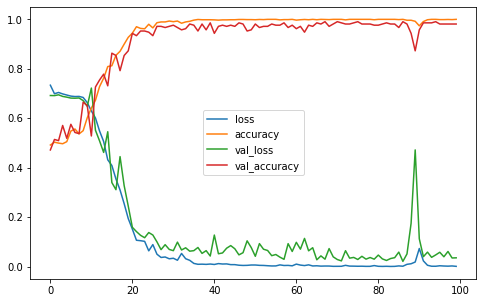

Results for fold 8
Epoch 1/100
30/30 [==============================] - 3s 71ms/step - loss: 0.7538 - accuracy: 0.5094 - val_loss: 0.6954 - val_accuracy: 0.4858
Epoch 2/100
30/30 [==============================] - 2s 60ms/step - loss: 0.7077 - accuracy: 0.4963 - val_loss: 0.6893 - val_accuracy: 0.5142
Epoch 3/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6996 - accuracy: 0.4932 - val_loss: 0.6879 - val_accuracy: 0.5943
Epoch 4/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6963 - accuracy: 0.5031 - val_loss: 0.6956 - val_accuracy: 0.4292
Epoch 5/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6935 - accuracy: 0.5288 - val_loss: 0.6958 - val_accuracy: 0.4340
Epoch 6/100
30/30 [==============================] - 2s 61ms/step - loss: 0.6916 - accuracy: 0.5188 - val_loss: 0.7006 - val_accuracy: 0.4151
Epoch 7/100
30/30 [==============================] - 2s 60ms/step - loss: 0.6872 - accuracy: 0.5424 - val_loss: 0.6863 - val_accu

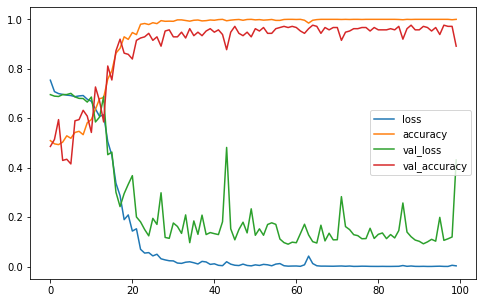

Results for fold 9
Epoch 1/100
30/30 [==============================] - 3s 72ms/step - loss: 0.7339 - accuracy: 0.4948 - val_loss: 0.6894 - val_accuracy: 0.4953
Epoch 2/100
30/30 [==============================] - 2s 59ms/step - loss: 0.7081 - accuracy: 0.5089 - val_loss: 0.6922 - val_accuracy: 0.5047
Epoch 3/100
30/30 [==============================] - 2s 60ms/step - loss: 0.7112 - accuracy: 0.5115 - val_loss: 0.6938 - val_accuracy: 0.4670
Epoch 4/100
30/30 [==============================] - 2s 61ms/step - loss: 0.7057 - accuracy: 0.5063 - val_loss: 0.6912 - val_accuracy: 0.5000
Epoch 5/100
30/30 [==============================] - 2s 62ms/step - loss: 0.7073 - accuracy: 0.5010 - val_loss: 0.6874 - val_accuracy: 0.6085
Epoch 6/100
30/30 [==============================] - 2s 61ms/step - loss: 0.7070 - accuracy: 0.4963 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 7/100
30/30 [==============================] - 2s 61ms/step - loss: 0.7091 - accuracy: 0.4843 - val_loss: 0.6909 - val_accu

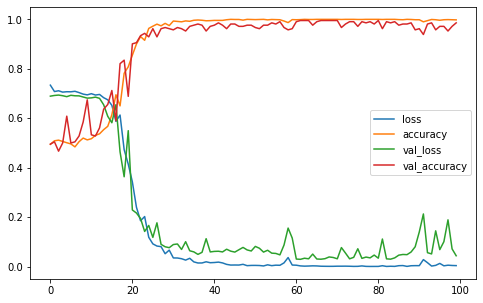

Results for fold 10
Epoch 1/100
30/30 [==============================] - 4s 74ms/step - loss: 0.7559 - accuracy: 0.5078 - val_loss: 0.7158 - val_accuracy: 0.4670
Epoch 2/100
30/30 [==============================] - 2s 63ms/step - loss: 0.7241 - accuracy: 0.4854 - val_loss: 0.6875 - val_accuracy: 0.5283
Epoch 3/100
30/30 [==============================] - 2s 62ms/step - loss: 0.7143 - accuracy: 0.5005 - val_loss: 0.6941 - val_accuracy: 0.4623
Epoch 4/100
30/30 [==============================] - 2s 62ms/step - loss: 0.7119 - accuracy: 0.5126 - val_loss: 0.6913 - val_accuracy: 0.5283
Epoch 5/100
30/30 [==============================] - 2s 61ms/step - loss: 0.6964 - accuracy: 0.5241 - val_loss: 0.7147 - val_accuracy: 0.4717
Epoch 6/100
30/30 [==============================] - 2s 61ms/step - loss: 0.6778 - accuracy: 0.5664 - val_loss: 0.6812 - val_accuracy: 0.5755
Epoch 7/100
30/30 [==============================] - 2s 62ms/step - loss: 0.6674 - accuracy: 0.5915 - val_loss: 0.6461 - val_acc

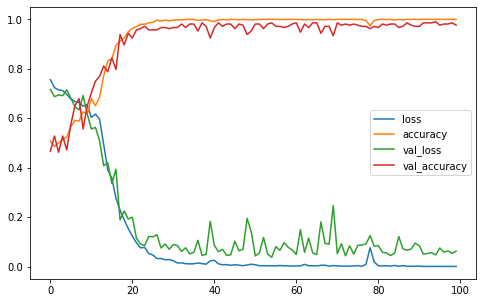

In [ ]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9686440765857697
F1_Score  : 0.9679633341708271


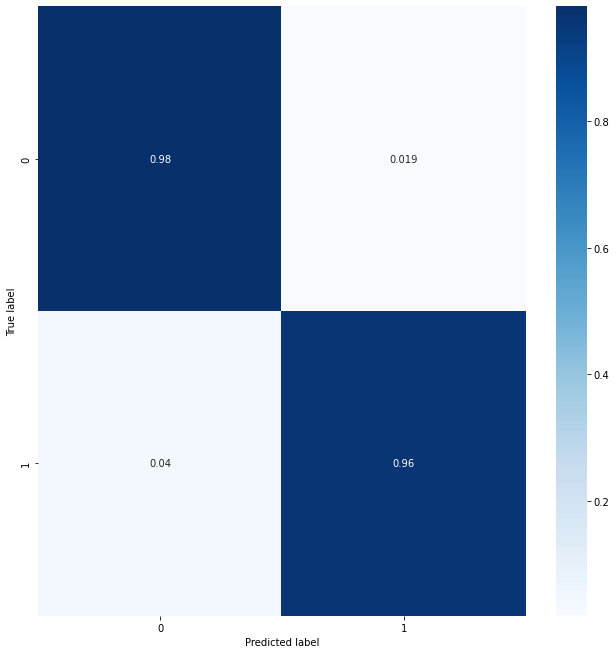

In [ ]:
#50 epochs
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Arousal**

In [ ]:
#arousal
X_train, x_test, Y_train, y_test = train_test_split(data,arousal, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(2124, 36, 256, 1) (236, 36, 256, 1) (2124, 2) (236, 2)


Results for fold 1
Epoch 1/100
30/30 [==============================] - 22s 212ms/step - loss: 0.6997 - accuracy: 0.5390 - val_loss: 0.6127 - val_accuracy: 0.6479
Epoch 2/100
30/30 [==============================] - 5s 157ms/step - loss: 0.6677 - accuracy: 0.5814 - val_loss: 0.6329 - val_accuracy: 0.6620
Epoch 3/100
30/30 [==============================] - 5s 157ms/step - loss: 0.6604 - accuracy: 0.6164 - val_loss: 0.5936 - val_accuracy: 0.7371
Epoch 4/100
30/30 [==============================] - 5s 158ms/step - loss: 0.6464 - accuracy: 0.6170 - val_loss: 0.6023 - val_accuracy: 0.6526
Epoch 5/100
30/30 [==============================] - 5s 157ms/step - loss: 0.6117 - accuracy: 0.6709 - val_loss: 0.5624 - val_accuracy: 0.7136
Epoch 6/100
30/30 [==============================] - 5s 157ms/step - loss: 0.5976 - accuracy: 0.6693 - val_loss: 0.6751 - val_accuracy: 0.5915
Epoch 7/100
30/30 [==============================] - 5s 162ms/step - loss: 0.5605 - accuracy: 0.7070 - val_loss: 0.4706 - 

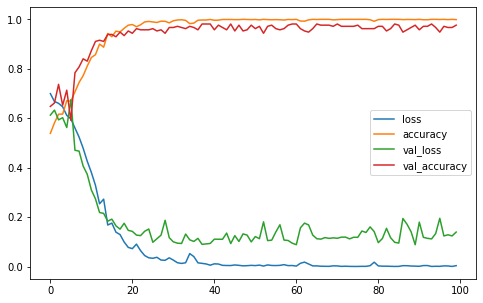

Results for fold 2
Epoch 1/100
30/30 [==============================] - 7s 170ms/step - loss: 0.7091 - accuracy: 0.5542 - val_loss: 0.6463 - val_accuracy: 0.6244
Epoch 2/100
30/30 [==============================] - 5s 157ms/step - loss: 0.6609 - accuracy: 0.6102 - val_loss: 0.6253 - val_accuracy: 0.6808
Epoch 3/100
30/30 [==============================] - 5s 162ms/step - loss: 0.6336 - accuracy: 0.6436 - val_loss: 0.5910 - val_accuracy: 0.6761
Epoch 4/100
30/30 [==============================] - 5s 157ms/step - loss: 0.6333 - accuracy: 0.6552 - val_loss: 0.5870 - val_accuracy: 0.6995
Epoch 5/100
30/30 [==============================] - 5s 157ms/step - loss: 0.6159 - accuracy: 0.6698 - val_loss: 0.6297 - val_accuracy: 0.6291
Epoch 6/100
30/30 [==============================] - 5s 158ms/step - loss: 0.5956 - accuracy: 0.6818 - val_loss: 0.5428 - val_accuracy: 0.7230
Epoch 7/100
30/30 [==============================] - 5s 163ms/step - loss: 0.5670 - accuracy: 0.7101 - val_loss: 0.5053 - v

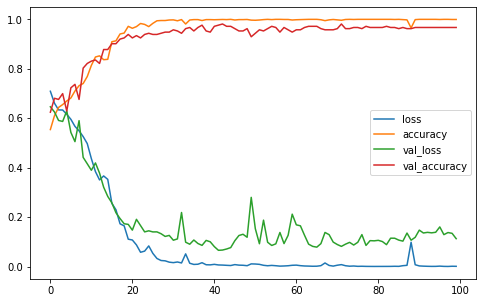

Results for fold 3
Epoch 1/100
30/30 [==============================] - 7s 177ms/step - loss: 0.7354 - accuracy: 0.5515 - val_loss: 0.6088 - val_accuracy: 0.6761
Epoch 2/100
30/30 [==============================] - 5s 158ms/step - loss: 0.6696 - accuracy: 0.5981 - val_loss: 0.5991 - val_accuracy: 0.6667
Epoch 3/100
30/30 [==============================] - 5s 157ms/step - loss: 0.6480 - accuracy: 0.6279 - val_loss: 0.7092 - val_accuracy: 0.5634
Epoch 4/100
30/30 [==============================] - 5s 158ms/step - loss: 0.6380 - accuracy: 0.6353 - val_loss: 0.5748 - val_accuracy: 0.7371
Epoch 5/100
30/30 [==============================] - 5s 158ms/step - loss: 0.6311 - accuracy: 0.6421 - val_loss: 0.5129 - val_accuracy: 0.7840
Epoch 6/100
30/30 [==============================] - 5s 157ms/step - loss: 0.6188 - accuracy: 0.6625 - val_loss: 0.5176 - val_accuracy: 0.7606
Epoch 7/100
30/30 [==============================] - 5s 158ms/step - loss: 0.6151 - accuracy: 0.6667 - val_loss: 0.6346 - v

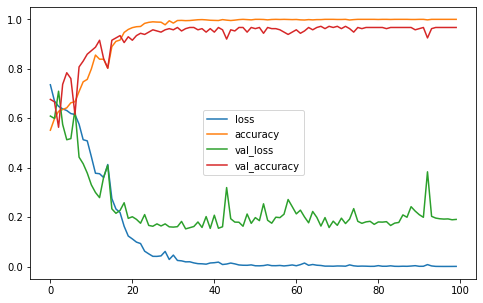

Results for fold 4
Epoch 1/100
30/30 [==============================] - 7s 178ms/step - loss: 0.7147 - accuracy: 0.5437 - val_loss: 0.6710 - val_accuracy: 0.6009
Epoch 2/100
30/30 [==============================] - 5s 157ms/step - loss: 0.6705 - accuracy: 0.5965 - val_loss: 0.6281 - val_accuracy: 0.6479
Epoch 3/100
30/30 [==============================] - 5s 157ms/step - loss: 0.6334 - accuracy: 0.6510 - val_loss: 0.6304 - val_accuracy: 0.6197
Epoch 4/100
30/30 [==============================] - 5s 157ms/step - loss: 0.6235 - accuracy: 0.6656 - val_loss: 0.6025 - val_accuracy: 0.6620
Epoch 5/100
30/30 [==============================] - 5s 163ms/step - loss: 0.5947 - accuracy: 0.6850 - val_loss: 0.5670 - val_accuracy: 0.6901
Epoch 6/100
30/30 [==============================] - 5s 157ms/step - loss: 0.5930 - accuracy: 0.6866 - val_loss: 0.5609 - val_accuracy: 0.6995
Epoch 7/100
30/30 [==============================] - 5s 157ms/step - loss: 0.5511 - accuracy: 0.7169 - val_loss: 0.6009 - v

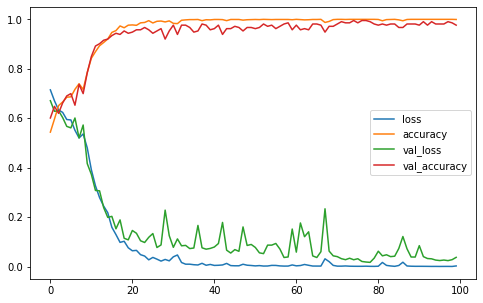

Results for fold 5
Epoch 1/100
30/30 [==============================] - 8s 218ms/step - loss: 0.6970 - accuracy: 0.5633 - val_loss: 0.6587 - val_accuracy: 0.6132
Epoch 2/100
30/30 [==============================] - 5s 157ms/step - loss: 0.6505 - accuracy: 0.6219 - val_loss: 0.6543 - val_accuracy: 0.5991
Epoch 3/100
30/30 [==============================] - 5s 158ms/step - loss: 0.6298 - accuracy: 0.6323 - val_loss: 0.6483 - val_accuracy: 0.6415
Epoch 4/100
30/30 [==============================] - 5s 158ms/step - loss: 0.5917 - accuracy: 0.6867 - val_loss: 0.6343 - val_accuracy: 0.6509
Epoch 5/100
30/30 [==============================] - 5s 158ms/step - loss: 0.5566 - accuracy: 0.7296 - val_loss: 0.5248 - val_accuracy: 0.7736
Epoch 6/100
30/30 [==============================] - 5s 158ms/step - loss: 0.5067 - accuracy: 0.7631 - val_loss: 0.5172 - val_accuracy: 0.7925
Epoch 7/100
30/30 [==============================] - 5s 159ms/step - loss: 0.4898 - accuracy: 0.7720 - val_loss: 0.4755 - v

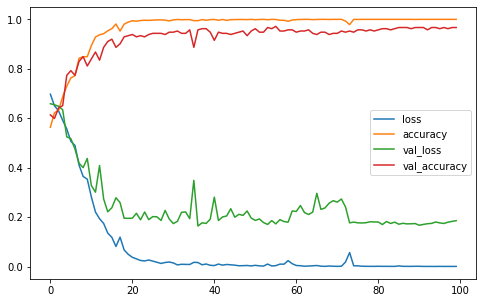

Results for fold 6
Epoch 1/100
30/30 [==============================] - 7s 177ms/step - loss: 0.7227 - accuracy: 0.5298 - val_loss: 0.6528 - val_accuracy: 0.6557
Epoch 2/100
30/30 [==============================] - 5s 159ms/step - loss: 0.6777 - accuracy: 0.5690 - val_loss: 0.6538 - val_accuracy: 0.6462
Epoch 3/100
30/30 [==============================] - 5s 159ms/step - loss: 0.6631 - accuracy: 0.5947 - val_loss: 0.6097 - val_accuracy: 0.6698
Epoch 4/100
30/30 [==============================] - 5s 163ms/step - loss: 0.6476 - accuracy: 0.6245 - val_loss: 0.5733 - val_accuracy: 0.7075
Epoch 5/100
30/30 [==============================] - 5s 159ms/step - loss: 0.6225 - accuracy: 0.6522 - val_loss: 0.5615 - val_accuracy: 0.7264
Epoch 6/100
30/30 [==============================] - 5s 163ms/step - loss: 0.5945 - accuracy: 0.6904 - val_loss: 0.5633 - val_accuracy: 0.6840
Epoch 7/100
30/30 [==============================] - 5s 158ms/step - loss: 0.5405 - accuracy: 0.7265 - val_loss: 0.4933 - v

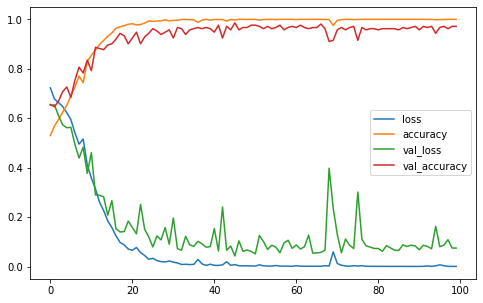

Results for fold 7
Epoch 1/100
30/30 [==============================] - 7s 180ms/step - loss: 0.7081 - accuracy: 0.5382 - val_loss: 0.6692 - val_accuracy: 0.6038
Epoch 2/100
30/30 [==============================] - 5s 158ms/step - loss: 0.6667 - accuracy: 0.5936 - val_loss: 0.6214 - val_accuracy: 0.6698
Epoch 3/100
30/30 [==============================] - 5s 158ms/step - loss: 0.6656 - accuracy: 0.6056 - val_loss: 0.6098 - val_accuracy: 0.6745
Epoch 4/100
30/30 [==============================] - 5s 158ms/step - loss: 0.6445 - accuracy: 0.6224 - val_loss: 0.5793 - val_accuracy: 0.6840
Epoch 5/100
30/30 [==============================] - 5s 157ms/step - loss: 0.6269 - accuracy: 0.6470 - val_loss: 0.6019 - val_accuracy: 0.6887
Epoch 6/100
30/30 [==============================] - 5s 158ms/step - loss: 0.6162 - accuracy: 0.6606 - val_loss: 0.5304 - val_accuracy: 0.7170
Epoch 7/100
30/30 [==============================] - 5s 163ms/step - loss: 0.5713 - accuracy: 0.7123 - val_loss: 0.4922 - v

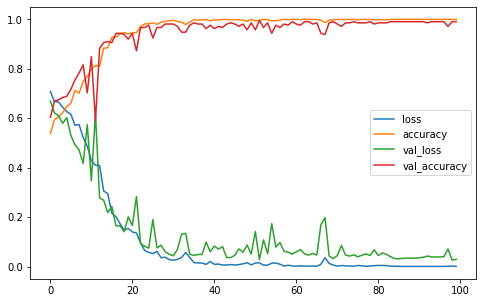

Results for fold 8
Epoch 1/100
30/30 [==============================] - 7s 178ms/step - loss: 0.8844 - accuracy: 0.5392 - val_loss: 0.5778 - val_accuracy: 0.7123
Epoch 2/100
30/30 [==============================] - 5s 158ms/step - loss: 0.6826 - accuracy: 0.5779 - val_loss: 0.5661 - val_accuracy: 0.7170
Epoch 3/100
30/30 [==============================] - 5s 164ms/step - loss: 0.6868 - accuracy: 0.5758 - val_loss: 0.5755 - val_accuracy: 0.7406
Epoch 4/100
30/30 [==============================] - 5s 158ms/step - loss: 0.6731 - accuracy: 0.5968 - val_loss: 0.6105 - val_accuracy: 0.6981
Epoch 5/100
30/30 [==============================] - 5s 158ms/step - loss: 0.6415 - accuracy: 0.6370 - val_loss: 0.5616 - val_accuracy: 0.7311
Epoch 6/100
30/30 [==============================] - 5s 160ms/step - loss: 0.6256 - accuracy: 0.6423 - val_loss: 0.6392 - val_accuracy: 0.6226
Epoch 7/100
30/30 [==============================] - 5s 158ms/step - loss: 0.6216 - accuracy: 0.6726 - val_loss: 0.5395 - v

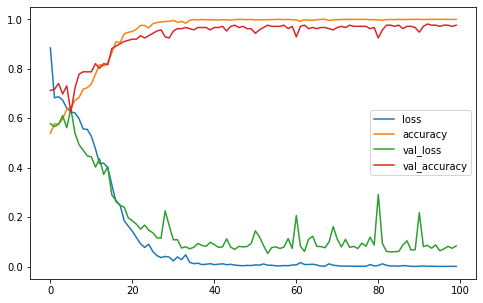

Results for fold 9
Epoch 1/100
30/30 [==============================] - 7s 173ms/step - loss: 0.7044 - accuracy: 0.5533 - val_loss: 0.6397 - val_accuracy: 0.6509
Epoch 2/100
30/30 [==============================] - 5s 163ms/step - loss: 0.6617 - accuracy: 0.5884 - val_loss: 0.6084 - val_accuracy: 0.6462
Epoch 3/100
30/30 [==============================] - 5s 159ms/step - loss: 0.6530 - accuracy: 0.6015 - val_loss: 0.5937 - val_accuracy: 0.6651
Epoch 4/100
30/30 [==============================] - 5s 158ms/step - loss: 0.6512 - accuracy: 0.6015 - val_loss: 0.6203 - val_accuracy: 0.6462
Epoch 5/100
30/30 [==============================] - 5s 158ms/step - loss: 0.6470 - accuracy: 0.5973 - val_loss: 0.5856 - val_accuracy: 0.6509
Epoch 6/100
30/30 [==============================] - 5s 158ms/step - loss: 0.6280 - accuracy: 0.6328 - val_loss: 0.5692 - val_accuracy: 0.6887
Epoch 7/100
30/30 [==============================] - 5s 164ms/step - loss: 0.6081 - accuracy: 0.6642 - val_loss: 0.5730 - v

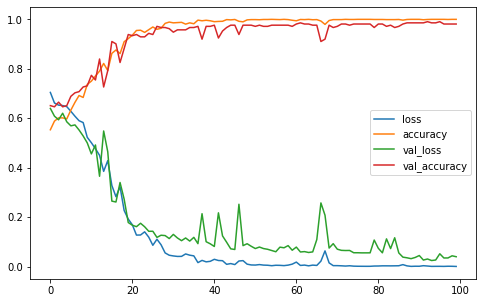

Results for fold 10
Epoch 1/100
30/30 [==============================] - 7s 174ms/step - loss: 0.7159 - accuracy: 0.5424 - val_loss: 0.6300 - val_accuracy: 0.6274
Epoch 2/100
30/30 [==============================] - 5s 159ms/step - loss: 0.6949 - accuracy: 0.5565 - val_loss: 0.6194 - val_accuracy: 0.6509
Epoch 3/100
30/30 [==============================] - 5s 157ms/step - loss: 0.6743 - accuracy: 0.5847 - val_loss: 0.6276 - val_accuracy: 0.6321
Epoch 4/100
30/30 [==============================] - 5s 158ms/step - loss: 0.6449 - accuracy: 0.6234 - val_loss: 0.6033 - val_accuracy: 0.6887
Epoch 5/100
30/30 [==============================] - 5s 158ms/step - loss: 0.6429 - accuracy: 0.6260 - val_loss: 0.5838 - val_accuracy: 0.6745
Epoch 6/100
30/30 [==============================] - 5s 158ms/step - loss: 0.6278 - accuracy: 0.6559 - val_loss: 0.5638 - val_accuracy: 0.7028
Epoch 7/100
30/30 [==============================] - 5s 157ms/step - loss: 0.6103 - accuracy: 0.6721 - val_loss: 0.5689 - 

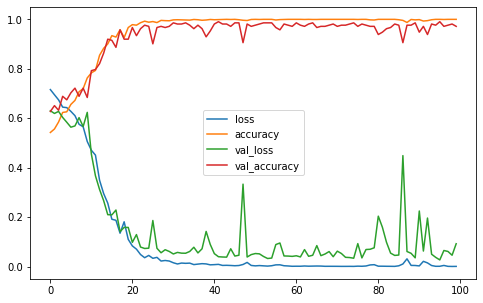

In [ ]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.978389835357666
F1_Score  : 0.9775141448597668


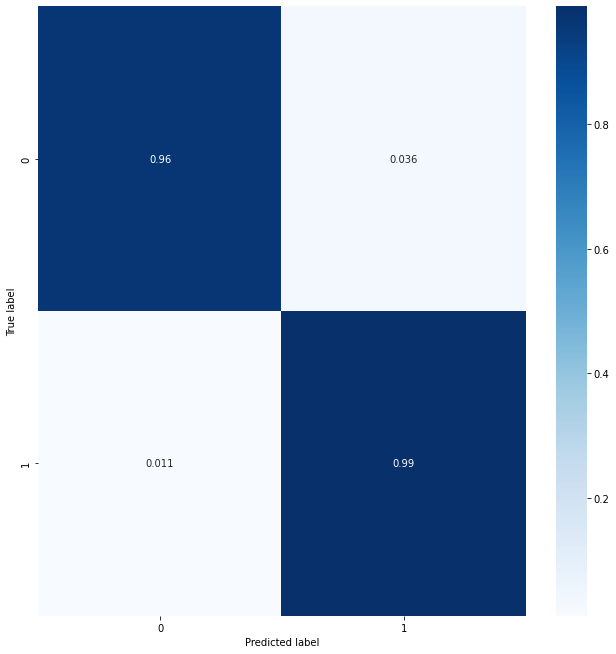

In [ ]:
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Subject 18**

In [ ]:
eeg_signal = []
valence = []
arousal = []
window_size = 256
no_channels = 32
no_new_channels = len(new_channels)
no_videos = 40
Trsld = 5

for person in range(18,19):
  print('Person No.' + str(person))
  
  
  # EEG files address
  if person < 10 :
    address = input_path+'s0'+str(person)+'.dat'
  else :
    address = input_path+'s'+str(person)+'.dat'

  with open(address, 'rb') as file:
    data = pkl.load(file, encoding = 'latin1')

  eeg = data['data']
  label = data['labels']
  
  # Assigning classes
  label[label<Trsld] = 0
  label[label>=Trsld] = 1

  val = label.T[0] # Valence label
  aro = label.T[1] # Arousal label

  del data, label
  # Iterating through 40 vidoes/trials
  for i in range(no_videos):
    sig = eeg[i][:no_channels, :]
    sig = baseline_remove(sig)
    temp = []
    for j in new_channels:
      temp.append(sig[j, :])
    sig = np.reshape(temp,[no_new_channels,-1])
    # Segmenting into 2 seconds (256 timesteps) windows without overlap
    start = 0
    while start + window_size <=sig.shape[1]:
      eeg_signal.append(sig[:, start:start+window_size])
      valence.append(val[i])
      arousal.append(aro[i])
      start += skip
  del eeg, val, aro, sig
eeg_signal = np.reshape(eeg_signal,[-1,no_new_channels,window_size,1])
data = np.asarray(eeg_signal, dtype = np.float32) # Using 32 bit floating point value to save memory
del eeg_signal
valence = np.asarray(valence, dtype = np.int8)
arousal = np.asarray(arousal, dtype = np.int8)

print(data.shape)
print(valence.shape, valence[valence == 0].shape, valence[valence == 1].shape)
print(arousal.shape, arousal[arousal == 0].shape, arousal[arousal == 1].shape)

valence = np_utils.to_categorical(valence)
arousal = np_utils.to_categorical(arousal)
gc.collect()

Person No.18
(2360, 36, 256, 1)
(2360,) (826,) (1534,)
(2360,) (885,) (1475,)


0

# **Valence**

In [ ]:
#valence
X_train, x_test, Y_train, y_test = train_test_split(data, valence, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(2124, 36, 256, 1) (236, 36, 256, 1) (2124, 2) (236, 2)


Results for fold 1
Epoch 1/100
30/30 [==============================] - 7s 178ms/step - loss: 0.7054 - accuracy: 0.5557 - val_loss: 0.6853 - val_accuracy: 0.5305
Epoch 2/100
30/30 [==============================] - 5s 156ms/step - loss: 0.6730 - accuracy: 0.5720 - val_loss: 0.6344 - val_accuracy: 0.6948
Epoch 3/100
30/30 [==============================] - 5s 156ms/step - loss: 0.6213 - accuracy: 0.6724 - val_loss: 0.7249 - val_accuracy: 0.5540
Epoch 4/100
30/30 [==============================] - 5s 162ms/step - loss: 0.5050 - accuracy: 0.7692 - val_loss: 0.5472 - val_accuracy: 0.7183
Epoch 5/100
30/30 [==============================] - 5s 157ms/step - loss: 0.4040 - accuracy: 0.8357 - val_loss: 0.4563 - val_accuracy: 0.7653
Epoch 6/100
30/30 [==============================] - 5s 156ms/step - loss: 0.3347 - accuracy: 0.8707 - val_loss: 0.2995 - val_accuracy: 0.8920
Epoch 7/100
30/30 [==============================] - 5s 156ms/step - loss: 0.2855 - accuracy: 0.8906 - val_loss: 0.2493 - v

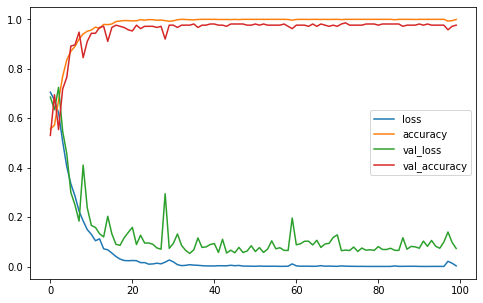

Results for fold 2
Epoch 1/100
30/30 [==============================] - 7s 172ms/step - loss: 0.7349 - accuracy: 0.5233 - val_loss: 0.6393 - val_accuracy: 0.7559
Epoch 2/100
30/30 [==============================] - 5s 157ms/step - loss: 0.6533 - accuracy: 0.6159 - val_loss: 0.5240 - val_accuracy: 0.7700
Epoch 3/100
30/30 [==============================] - 5s 157ms/step - loss: 0.5936 - accuracy: 0.6944 - val_loss: 0.4814 - val_accuracy: 0.8216
Epoch 4/100
30/30 [==============================] - 5s 162ms/step - loss: 0.4787 - accuracy: 0.7745 - val_loss: 0.3626 - val_accuracy: 0.8732
Epoch 5/100
30/30 [==============================] - 5s 157ms/step - loss: 0.4691 - accuracy: 0.7760 - val_loss: 0.5103 - val_accuracy: 0.7277
Epoch 6/100
30/30 [==============================] - 5s 158ms/step - loss: 0.3637 - accuracy: 0.8462 - val_loss: 0.2706 - val_accuracy: 0.8967
Epoch 7/100
30/30 [==============================] - 5s 158ms/step - loss: 0.2818 - accuracy: 0.8864 - val_loss: 0.1897 - v

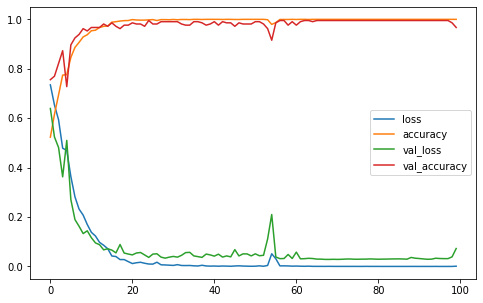

Results for fold 3
Epoch 1/100
30/30 [==============================] - 7s 169ms/step - loss: 0.7528 - accuracy: 0.5076 - val_loss: 0.6823 - val_accuracy: 0.5775
Epoch 2/100
30/30 [==============================] - 5s 162ms/step - loss: 0.6749 - accuracy: 0.5646 - val_loss: 0.6007 - val_accuracy: 0.8451
Epoch 3/100
30/30 [==============================] - 5s 156ms/step - loss: 0.6276 - accuracy: 0.6515 - val_loss: 0.7395 - val_accuracy: 0.4366
Epoch 4/100
30/30 [==============================] - 5s 157ms/step - loss: 0.5491 - accuracy: 0.7373 - val_loss: 0.4712 - val_accuracy: 0.8169
Epoch 5/100
30/30 [==============================] - 5s 157ms/step - loss: 0.5004 - accuracy: 0.7734 - val_loss: 0.5128 - val_accuracy: 0.7465
Epoch 6/100
30/30 [==============================] - 5s 156ms/step - loss: 0.4821 - accuracy: 0.7750 - val_loss: 0.3250 - val_accuracy: 0.8920
Epoch 7/100
30/30 [==============================] - 5s 157ms/step - loss: 0.3930 - accuracy: 0.8284 - val_loss: 0.3096 - v

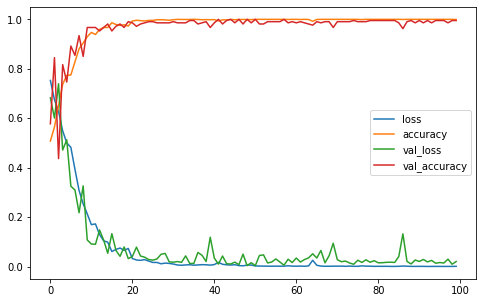

Results for fold 4
Epoch 1/100
30/30 [==============================] - 7s 177ms/step - loss: 0.7129 - accuracy: 0.5631 - val_loss: 0.5692 - val_accuracy: 0.7653
Epoch 2/100
30/30 [==============================] - 5s 157ms/step - loss: 0.6466 - accuracy: 0.6149 - val_loss: 0.5285 - val_accuracy: 0.7512
Epoch 3/100
30/30 [==============================] - 5s 158ms/step - loss: 0.5718 - accuracy: 0.6986 - val_loss: 0.4827 - val_accuracy: 0.7606
Epoch 4/100
30/30 [==============================] - 5s 158ms/step - loss: 0.5240 - accuracy: 0.7342 - val_loss: 0.4979 - val_accuracy: 0.7512
Epoch 5/100
30/30 [==============================] - 5s 157ms/step - loss: 0.4412 - accuracy: 0.7886 - val_loss: 0.3985 - val_accuracy: 0.8122
Epoch 6/100
30/30 [==============================] - 5s 158ms/step - loss: 0.3540 - accuracy: 0.8524 - val_loss: 0.4023 - val_accuracy: 0.8216
Epoch 7/100
30/30 [==============================] - 5s 158ms/step - loss: 0.3452 - accuracy: 0.8592 - val_loss: 0.4060 - v

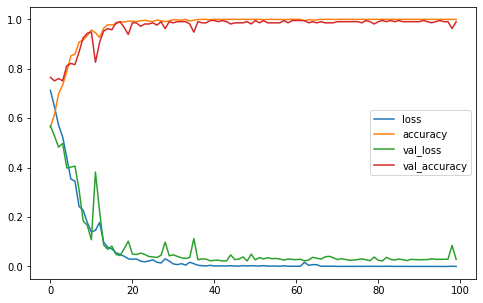

Results for fold 5
Epoch 1/100
30/30 [==============================] - 7s 177ms/step - loss: 0.6858 - accuracy: 0.5936 - val_loss: 0.6465 - val_accuracy: 0.6085
Epoch 2/100
30/30 [==============================] - 5s 157ms/step - loss: 0.5943 - accuracy: 0.6899 - val_loss: 0.4895 - val_accuracy: 0.7830
Epoch 3/100
30/30 [==============================] - 5s 158ms/step - loss: 0.5190 - accuracy: 0.7432 - val_loss: 0.4077 - val_accuracy: 0.8160
Epoch 4/100
30/30 [==============================] - 5s 157ms/step - loss: 0.4368 - accuracy: 0.7913 - val_loss: 0.2926 - val_accuracy: 0.8821
Epoch 5/100
30/30 [==============================] - 5s 158ms/step - loss: 0.3565 - accuracy: 0.8457 - val_loss: 0.2574 - val_accuracy: 0.9057
Epoch 6/100
30/30 [==============================] - 5s 158ms/step - loss: 0.3015 - accuracy: 0.8755 - val_loss: 0.2086 - val_accuracy: 0.9245
Epoch 7/100
30/30 [==============================] - 5s 158ms/step - loss: 0.2308 - accuracy: 0.9121 - val_loss: 0.1795 - v

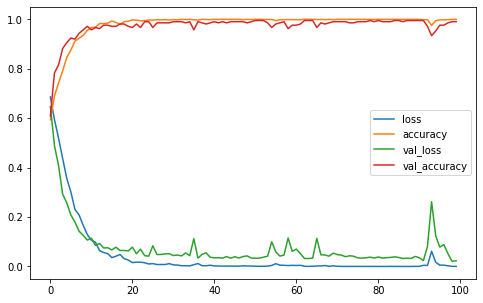

Results for fold 6
Epoch 1/100
30/30 [==============================] - 7s 178ms/step - loss: 0.6748 - accuracy: 0.5785 - val_loss: 0.6145 - val_accuracy: 0.7500
Epoch 2/100
30/30 [==============================] - 5s 158ms/step - loss: 0.5921 - accuracy: 0.6919 - val_loss: 0.5234 - val_accuracy: 0.7217
Epoch 3/100
30/30 [==============================] - 5s 157ms/step - loss: 0.5387 - accuracy: 0.7186 - val_loss: 0.4677 - val_accuracy: 0.8302
Epoch 4/100
30/30 [==============================] - 5s 158ms/step - loss: 0.4244 - accuracy: 0.8086 - val_loss: 0.3804 - val_accuracy: 0.8443
Epoch 5/100
30/30 [==============================] - 5s 164ms/step - loss: 0.3455 - accuracy: 0.8567 - val_loss: 0.3449 - val_accuracy: 0.8679
Epoch 6/100
30/30 [==============================] - 5s 158ms/step - loss: 0.2963 - accuracy: 0.8792 - val_loss: 0.3219 - val_accuracy: 0.8726
Epoch 7/100
30/30 [==============================] - 5s 158ms/step - loss: 0.2325 - accuracy: 0.9163 - val_loss: 0.2746 - v

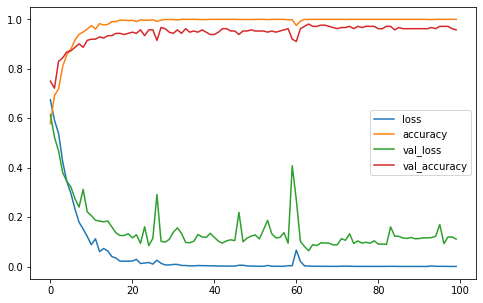

Results for fold 7
Epoch 1/100
30/30 [==============================] - 7s 177ms/step - loss: 0.7488 - accuracy: 0.5293 - val_loss: 0.5905 - val_accuracy: 0.7500
Epoch 2/100
30/30 [==============================] - 5s 158ms/step - loss: 0.6731 - accuracy: 0.5900 - val_loss: 0.6265 - val_accuracy: 0.6651
Epoch 3/100
30/30 [==============================] - 5s 158ms/step - loss: 0.6100 - accuracy: 0.6402 - val_loss: 0.4803 - val_accuracy: 0.8019
Epoch 4/100
30/30 [==============================] - 5s 159ms/step - loss: 0.5471 - accuracy: 0.7244 - val_loss: 0.6530 - val_accuracy: 0.6321
Epoch 5/100
30/30 [==============================] - 5s 158ms/step - loss: 0.4903 - accuracy: 0.7599 - val_loss: 0.4127 - val_accuracy: 0.8208
Epoch 6/100
30/30 [==============================] - 5s 158ms/step - loss: 0.4128 - accuracy: 0.8081 - val_loss: 0.3424 - val_accuracy: 0.8679
Epoch 7/100
30/30 [==============================] - 5s 163ms/step - loss: 0.3496 - accuracy: 0.8577 - val_loss: 0.3036 - v

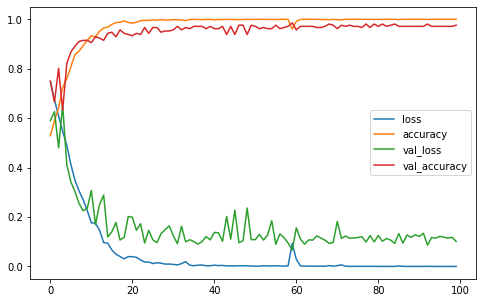

Results for fold 8
Epoch 1/100
30/30 [==============================] - 7s 173ms/step - loss: 0.7512 - accuracy: 0.5445 - val_loss: 0.6047 - val_accuracy: 0.7075
Epoch 2/100
30/30 [==============================] - 5s 158ms/step - loss: 0.6040 - accuracy: 0.6595 - val_loss: 0.4907 - val_accuracy: 0.7783
Epoch 3/100
30/30 [==============================] - 5s 164ms/step - loss: 0.5544 - accuracy: 0.7191 - val_loss: 0.4037 - val_accuracy: 0.8302
Epoch 4/100
30/30 [==============================] - 5s 158ms/step - loss: 0.4650 - accuracy: 0.7646 - val_loss: 0.3347 - val_accuracy: 0.8726
Epoch 5/100
30/30 [==============================] - 5s 158ms/step - loss: 0.3853 - accuracy: 0.8373 - val_loss: 0.4860 - val_accuracy: 0.7925
Epoch 6/100
30/30 [==============================] - 5s 158ms/step - loss: 0.3273 - accuracy: 0.8656 - val_loss: 0.2216 - val_accuracy: 0.9151
Epoch 7/100
30/30 [==============================] - 5s 158ms/step - loss: 0.2529 - accuracy: 0.9059 - val_loss: 0.1827 - v

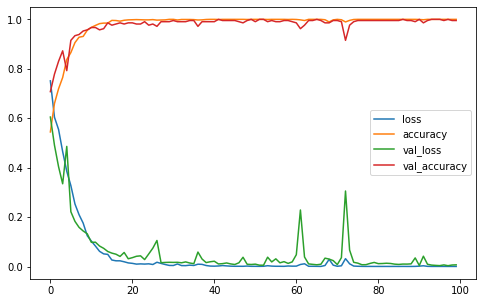

Results for fold 9
Epoch 1/100
30/30 [==============================] - 7s 180ms/step - loss: 0.7133 - accuracy: 0.5371 - val_loss: 0.6436 - val_accuracy: 0.7075
Epoch 2/100
30/30 [==============================] - 5s 158ms/step - loss: 0.6504 - accuracy: 0.6166 - val_loss: 0.5714 - val_accuracy: 0.7877
Epoch 3/100
30/30 [==============================] - 5s 157ms/step - loss: 0.5957 - accuracy: 0.6857 - val_loss: 0.4997 - val_accuracy: 0.8160
Epoch 4/100
30/30 [==============================] - 5s 158ms/step - loss: 0.5143 - accuracy: 0.7526 - val_loss: 0.3794 - val_accuracy: 0.8726
Epoch 5/100
30/30 [==============================] - 5s 159ms/step - loss: 0.4236 - accuracy: 0.8086 - val_loss: 0.3983 - val_accuracy: 0.8066
Epoch 6/100
30/30 [==============================] - 5s 159ms/step - loss: 0.3423 - accuracy: 0.8635 - val_loss: 0.3765 - val_accuracy: 0.8208
Epoch 7/100
30/30 [==============================] - 5s 157ms/step - loss: 0.2985 - accuracy: 0.8740 - val_loss: 0.3213 - v

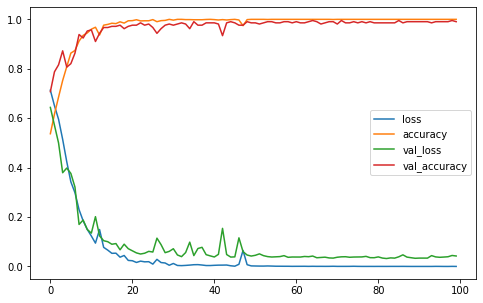

Results for fold 10
Epoch 1/100
30/30 [==============================] - 7s 171ms/step - loss: 0.7517 - accuracy: 0.5157 - val_loss: 0.6762 - val_accuracy: 0.5896
Epoch 2/100
30/30 [==============================] - 5s 158ms/step - loss: 0.6825 - accuracy: 0.5455 - val_loss: 0.6071 - val_accuracy: 0.6651
Epoch 3/100
30/30 [==============================] - 5s 158ms/step - loss: 0.6477 - accuracy: 0.6145 - val_loss: 0.6561 - val_accuracy: 0.5802
Epoch 4/100
30/30 [==============================] - 5s 159ms/step - loss: 0.5614 - accuracy: 0.6836 - val_loss: 0.3988 - val_accuracy: 0.8538
Epoch 5/100
30/30 [==============================] - 5s 158ms/step - loss: 0.4553 - accuracy: 0.7840 - val_loss: 0.3616 - val_accuracy: 0.8868
Epoch 6/100
30/30 [==============================] - 5s 157ms/step - loss: 0.3779 - accuracy: 0.8394 - val_loss: 0.3023 - val_accuracy: 0.8632
Epoch 7/100
30/30 [==============================] - 5s 158ms/step - loss: 0.3038 - accuracy: 0.8734 - val_loss: 0.1730 - 

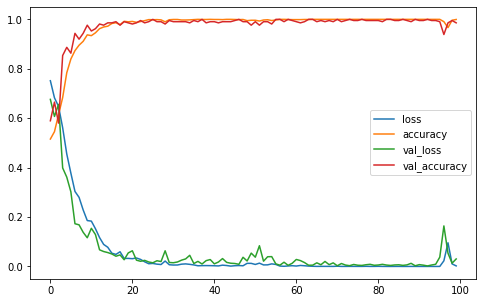

In [ ]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Accuracy  : 0.9936440587043762
F1_Score  : 0.9929741189645626


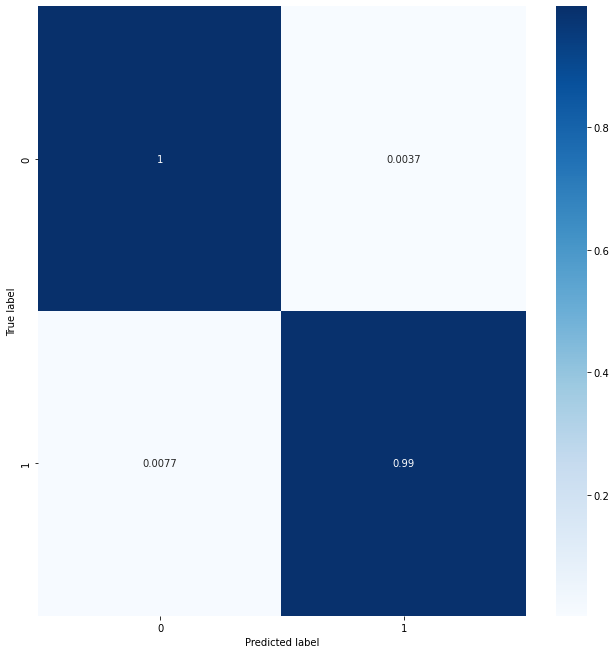

In [ ]:
#50 epochs
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# **Arousal**

In [ ]:
#arousal
X_train, x_test, Y_train, y_test = train_test_split(data,arousal, test_size=0.1, random_state=4)
print(X_train.shape,x_test.shape,Y_train.shape,y_test.shape)

(2124, 36, 256, 1) (236, 36, 256, 1) (2124, 2) (236, 2)


In [ ]:
val_res = {'accuracy': [], 'f1_score': [], 'confusion_matrix': []}
foldNum=0
#model = get_model()
for train_index, val_index in kfold.split(X_train, Y_train):
  foldNum = foldNum + 1
  model = get_model()
  print("Results for fold",foldNum)
  x_train, x_val = X_train[train_index], X_train[val_index]
  y_train, y_val = Y_train[train_index], Y_train[val_index]
  class_weight = call_class_weights(y_train)
  history = model.fit(x_train, y_train, epochs=epochs, class_weight=class_weight, batch_size=batch_size, verbose=1, validation_data=(x_val, y_val),shuffle=True)
  acc = model.evaluate(x_test, y_test)
  print(acc)
  val_res['accuracy'].append(acc)
  pred = model.predict(x_test)
  f1scr = f1_score(y_test.argmax(1), pred.argmax(1), average='macro')
  print(f1scr)
  pd.DataFrame(history.history).plot(figsize=(8,5))
  plt.show()
  val_res['f1_score'].append(f1scr)
  val_res['confusion_matrix'].append(confusion_matrix(y_test.argmax(1), pred.argmax(1)))
  gc.collect() # Garbage collecter
  del x_train, x_val, y_train, y_val, acc, f1scr
  gc.collect()

Results for fold 1
Epoch 1/100
14/30 [=============>................] - ETA: 39s - loss: 0.7632 - accuracy: 0.5179

KeyboardInterrupt: ignored

In [ ]:
acrc = np.array(val_res['accuracy']).mean(axis=0)
f1scr = np.array(val_res['f1_score']).mean(axis=0)
print("Accuracy  : {}".format(acrc[1]))
print("F1_Score  : {}".format(f1scr))
cmatrix = np.array(val_res['confusion_matrix']).mean(axis=0)
c_matrix = cmatrix/np.sum(cmatrix, axis=1).reshape(2,1)
import seaborn as sns
figure = plt.figure(figsize=(9, 9))
sns.heatmap(c_matrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()